In [1]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [2]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/emd_masksift_CA1_config_2500.yml')

In [3]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [4]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [5]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [6]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [ ]:
# # version 1

# def prepare_data_for_umap(imfs, imf_frequencies):

#   waveforms = pd.DataFrame()
#   all_trials = pd.DataFrame()
#   all_FPPs = []

#   theta_range = [5, 12]
#   frequencies = np.arange(15, 141, 1)
#   angles=np.linspace(-180,180,19)
#   fs = 2500

#   for idx, imf in enumerate(imfs):
#     cycle_data = get_cycle_data(imf[:, 5], fs=2500)

#     amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
#     lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
#     hi_freq_duration = fs/12

#     conditions = ['is_good==1',
#                         f'duration_samples<{lo_freq_duration}',
#                         f'duration_samples>{hi_freq_duration}',
#                         f'max_amp>{amp_thresh}']
#     print(len(cycle_data['theta_imf']))
#     all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
#     # Check if any cycles satisfy the conditions
#     if all_cycles is None or all_cycles.chain_vect.size == 0:
#         print("No cycles satisfy the conditions.")
#         return pd.DataFrame(), pd.DataFrame(), []
    
#     subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
#     subset_indices = subset_cycles_df['index'].values

#     all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
#     cycles_inds = arrange_cycle_inds(all_cycles_inds)

#     freqs = imf_frequencies[idx]
#     sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
#     supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

#     # # Corrected Wavelet Transform Computation
#     raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
#     # supraPlot = scipy.stats.zscore(raw_data, axis=1)
#     FPP = bin_tf_to_fpp(cycles_inds, raw_data, bin_count=19)
#     all_FPPs.append(FPP)

#     # Compute mode frequency for each cycle
#     mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

#     all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
#                                                             cycles=all_cycles.iterate(through='subset'), npoints=100)
#     all_waveforms = pd.DataFrame(all_waveforms.T)

#     waveforms = pd.concat([waveforms, all_waveforms])

#     trial = all_cycles.get_metric_dataframe(subset=True)
#     trial['mode_freqs'] = mode_freqs
#     trial['entropy'] = entropies
#     all_trials = pd.concat([all_trials, trial])

#   return waveforms, all_trials, all_FPPs

In [ ]:
# # version 1

# def prepare_data_for_umap_v2(imfs, imf_frequencies):

#   waveforms = pd.DataFrame()
#   all_trials = pd.DataFrame()
#   all_FPPs = []

#   theta_range = [5, 12]
#   frequencies = np.arange(15, 141, 1)
#   angles=np.linspace(-180,180,19)
#   fs = 2500

#   for idx, imf in enumerate(imfs):
#     cycle_data = get_cycle_data(imf[:, 5], fs=2500)

#     amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
#     lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
#     hi_freq_duration = fs/12

#     conditions = ['is_good==1',
#                         f'duration_samples<{lo_freq_duration}',
#                         f'duration_samples>{hi_freq_duration}',
#                         f'max_amp>{amp_thresh}']
#     print(len(cycle_data['theta_imf']))
#     all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
#     # Check if any cycles satisfy the conditions
#     if all_cycles is None or all_cycles.chain_vect.size == 0:
#         print("No cycles satisfy the conditions.")
#         return pd.DataFrame(), pd.DataFrame(), []
    
#     subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
#     subset_indices = subset_cycles_df['index'].values

#     all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
#     cycles_inds = arrange_cycle_inds(all_cycles_inds)

#     freqs = imf_frequencies[idx]
#     sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
#     supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

#     # # Corrected Wavelet Transform Computation
#     raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
#     # supraPlot = scipy.stats.zscore(raw_data, axis=1)
#     FPP = bin_tf_to_fpp(cycles_inds, raw_data, bin_count=19)
#     all_FPPs.append(FPP)

#     # Compute mode frequency for each cycle
#     mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

#     all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
#                                                             cycles=all_cycles.iterate(through='subset'), npoints=100)
#     all_waveforms = pd.DataFrame(all_waveforms.T)

#     waveforms = pd.concat([waveforms, all_waveforms])

#     trial = all_cycles.get_metric_dataframe(subset=True)
#     trial['mode_freqs'] = mode_freqs
#     trial['entropy'] = entropies
#     all_trials = pd.concat([all_trials, trial])

#   return waveforms, all_trials, all_FPPs

In [15]:
import numpy as np
import pandas as pd
import scipy
import sails

def build_cycle_signatures_from_supra(raw_spec, cycles_inds):
    """
    raw_spec: 2-D array (n_freqs x n_timepoints) of *raw* Morlet amplitudes or power
    cycles_inds: list of 1-D index arrays (samples belonging to each theta cycle)
    returns: 2-D array (n_cycles x n_freqs) of cycle-mean spectra
    """
    n_freqs, n_t = raw_spec.shape
    n_cycles = len(cycles_inds)
    sigs = np.zeros((n_cycles, n_freqs), dtype=float)

    for i, idx in enumerate(cycles_inds):
        if idx is None: 
            continue
        idx = np.asarray(idx, dtype=int)
        # keep only valid time indices
        idx = idx[(idx >= 0) & (idx < n_t)]
        if idx.size == 0:
            continue
        # average amplitude/power over the cycle window -> 1 vector per cycle
        sigs[i, :] = raw_spec[:, idx].mean(axis=1)
    return sigs

In [38]:
import numpy as np
import pandas as pd
import sails

def prepare_data_for_components_v2(imfs, imf_frequencies, fs=2500):
    """
    For each IMF chunk (episode):
      • detect theta cycles from theta IMF
      • build supra-theta spectrogram (Morlet power, energy-normalized) → log10
      • FPPs from that spectrogram (freq x phase)
      • SIGNATURES = cycle-mean (log-power) per frequency  [for PCA/ICA]
      • mode_freqs_sig = argmax(signature)  [no per-cycle normalization]
      • (kept) mode_freqs & entropy from FPPs, for backward compatibility
      • phase-aligned waveforms

    Returns
      waveforms_df : DataFrame
      all_trials   : DataFrame (includes mode_freqs_sig)
      all_FPPs     : list of 3D arrays (n_cycles x n_freqs x n_phase)
      all_SIGS     : list of 2D arrays (n_cycles x n_freqs)
    """
    waveforms = pd.DataFrame()
    all_trials = pd.DataFrame()
    all_FPPs   = []
    all_SIGS   = []

    theta_range = [5, 12]
    frequencies = np.arange(15, 141, 1)     # 15–140 Hz
    angles = np.linspace(-180, 180, 19)

    for idx, imf in enumerate(imfs):
        # --- theta cycles from theta IMF (your channel index 5)
        cycle_data = get_cycle_data(imf[:, 5], fs=fs)

        # cycle quality gates (same as your code)
        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5   # 5 Hz
        hi_freq_duration = fs/12  # 12 Hz
        conditions = [
            'is_good==1',
            f'duration_samples<{lo_freq_duration}',
            f'duration_samples>{hi_freq_duration}',
            f'max_amp>{amp_thresh}',
        ]
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
        if all_cycles is None or all_cycles.chain_vect.size == 0:
            continue

        subset_df   = all_cycles.get_metric_dataframe(subset=True)
        subset_idxs = subset_df['index'].values
        all_cycle_inds = get_cycle_inds(all_cycles, subset_idxs)
        cycles_inds    = arrange_cycle_inds(all_cycle_inds)  # list of sample index arrays

        # --- supra-theta = sum of IMFs with mean freq > 12 Hz
        freqs = imf_frequencies[idx]
        sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
        supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

        # --- Morlet of supra-theta: POWER + energy-normalization -> LOG10
        #     using same spectrogram for FPP + SIGNATURES
        raw_power = sails.wavelet.morlet(
            supra_theta_sig,
            freqs=frequencies,
            sample_rate=fs,
            ncycles=5,
            ret_mode='power',
            normalise=None      # <-- makes magnitudes comparable across freqs
        )  # shape: (n_freqs x n_time)
        #spec = np.log10(raw_power + 1e-12)   # compress dynamic range

        # --- FPP (keep for phase-resolved analyses)
        FPP = bin_tf_to_fpp(cycles_inds, raw_power, bin_count=19)   # (n_cycles x n_freqs x n_phase)
        all_FPPs.append(FPP)

        # --- paper-style SIGNATURES (what PCA/ICA uses)
        SIG = build_cycle_signatures_from_supra(raw_power, cycles_inds)  # (n_cycles x n_freqs)
        all_SIGS.append(SIG)

        # --- NEW: mode frequency directly from signatures (no normalization)
        sig_mode_idx   = np.argmax(SIG, axis=1)
        sig_mode_freqs = frequencies[sig_mode_idx]

        # --- (kept) old metrics from FPP if you still use them elsewhere
        try:
            mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)
        except Exception:
            # fall back to NaNs if helper not available
            mode_freqs = np.full(SIG.shape[0], np.nan)
            entropies  = np.full(SIG.shape[0], np.nan)

        # --- phase-aligned waveforms (unchanged)
        all_waveforms, _ = emd.cycles.phase_align(
            cycle_data['IP'], cycle_data['theta_imf'],
            cycles=all_cycles.iterate(through='subset'), npoints=100
        )
        waveforms = pd.concat([waveforms, pd.DataFrame(all_waveforms.T)], ignore_index=True)

        # --- pack per-cycle trial metrics
        trial = subset_df.copy()
        trial['mode_freqs_sig'] = sig_mode_freqs     # <-- use this for histograms
        trial['mode_freqs']     = mode_freqs         # (legacy)
        trial['entropy']        = entropies          # (legacy)
        all_trials = pd.concat([all_trials, trial], ignore_index=True)

    return waveforms, all_trials, all_FPPs, all_SIGS

In [39]:
import os
import pandas as pd
import re

def extract_data_for_rat(rat_id):
    # Define the base path to OS Basic datasets
    base_path = '/Users/amir/Desktop/for Abdel/OS Basic'
    fs = 2500  # Sample frequency

    # Initialize empty DataFrames for concatenation across all recordings and trials for the specified rat
    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()
    all_phasic_fpps = []
    all_tonic_fpps = []
    all_phasic_sigs, all_tonic_sigs = [], []

    rat_path = os.path.join(base_path, str(rat_id))

    # Check if the specified rat folder exists
    if not os.path.isdir(rat_path):
        print(f"Rat folder {rat_id} does not exist.")
        return None, None

    # List all recording folders in the rat directory
    recording_folders = [
        f for f in os.listdir(rat_path)
        if os.path.isdir(os.path.join(rat_path, f))
    ]

    if not recording_folders:
        print(f"No recording folders found for Rat {rat_id}.")
        return None, None

    # Loop over each recording folder
    for recording_folder in recording_folders:
        print(f"Processing recording folder: {recording_folder}")
        recording_path = os.path.join(rat_path, recording_folder)

        # Use regular expressions to parse the folder name
        match = re.match(r'^Rat-OS-Ephys_(Rat\d+)_SD(\d+)_([\w-]+)_([\d-]+)$', recording_folder)
        if not match:
            print(f"Unexpected folder name format: {recording_folder}. Skipping...")
            continue

        rat_id_part = match.group(1)       # e.g., 'Rat6'
        sd_number = match.group(2)         # e.g., '4'
        condition = match.group(3)         # e.g., 'CON'
        date_part = match.group(4)         # e.g., '22-02-2018'

        rat_id_from_folder = ''.join(filter(str.isdigit, rat_id_part))

        # Check if rat_id_from_folder matches rat_id
        if rat_id_from_folder != str(rat_id):
            print(f"Rat ID mismatch in folder {recording_folder}. Expected Rat{rat_id}, found Rat{rat_id_from_folder}. Skipping...")
            continue

        # Detect all trial folders and filter for post_trial2 to post_trial5, considering various folder name formats
        trial_folders = [
            f for f in os.listdir(recording_path)
            if os.path.isdir(os.path.join(recording_path, f)) and
            re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', f)
        ]

        if not trial_folders:
            print(f"No trial folders found in {recording_folder}.")
            continue

        for trial_folder in trial_folders:
            print(f"Processing trial folder: {trial_folder}")
            trial_path = os.path.join(recording_path, trial_folder)

            # Search for LFP and state files in the trial folder
            lfp_file = None
            state_file = None

            for file_name in os.listdir(trial_path):
                if 'HPC' in file_name and file_name.endswith('.mat'):
                    lfp_file = os.path.join(trial_path, file_name)
                elif 'states' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)
                elif 'States' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)

            # Ensure both LFP and state files were found
            if not lfp_file or not state_file:
                print(f"Missing LFP or state file in {trial_path}. Skipping...")
                continue

            # Extract trial number from folder name
            trial_number_match = re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', trial_folder)
            if trial_number_match:
                trial_number = int(trial_number_match.group(1))
            else:
                print(f"Unable to extract trial number from folder name: {trial_folder}. Skipping...")
                continue

            # Load data using custom functions
            try:
                lfpHPC, hypno, _ = get_data(lfp_file, state_file)

                # Extract phasic and tonic intervals, handling cases with no REM sleep
                try:
                    phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
                except ValueError as e:
                    print(f"No REM sleep found in {trial_folder} for Rat {rat_id}, Condition {condition}. Filling with empty intervals.")
                    phasic_interval, tonic_interval, lfp = [[], [], []]

                # Extract IMFs and frequencies for phasic and tonic intervals if intervals are not empty
                if phasic_interval and tonic_interval:
                    # Assume 'config' is defined elsewhere in your code
                    tonic_imfs, tonic_freqs, tonic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                    phasic_imfs, phasic_freqs, phasic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, phasic_interval, config, return_imfs_freqs=True)

                    # Prepare UMAP data for both phasic and tonic
                    phasic_waveforms, phasic_trials, phasic_fpps, phasic_sig = prepare_data_for_components_v2(phasic_imfs, phasic_freqs)
                    tonic_waveforms, tonic_trials, tonic_fpps, tonic_sig = prepare_data_for_components_v2(tonic_imfs, tonic_freqs)

                    # Add metadata columns, including cycle type labels
                    for df in [phasic_waveforms, phasic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'phasic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    for df in [tonic_waveforms, tonic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'tonic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    # Concatenate into combined DataFrames
                    all_combined_waveforms = pd.concat(
                        [all_combined_waveforms, phasic_waveforms, tonic_waveforms], ignore_index=True)
                    all_combined_trials = pd.concat(
                        [all_combined_trials, phasic_trials, tonic_trials], ignore_index=True)
                    all_phasic_fpps.extend(phasic_fpps)
                    all_tonic_fpps.extend(tonic_fpps)
                    all_phasic_sigs.extend(phasic_sig)
                    all_tonic_sigs.extend(tonic_sig)


            except FileNotFoundError:
                print(f"Data not found in {trial_path}. Skipping...")

    if all_combined_waveforms.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None

    return all_combined_waveforms, all_combined_trials, all_phasic_fpps, all_tonic_fpps, all_phasic_sigs, all_tonic_sigs

In [40]:
rat_id = '11'
waveforms_df, trials_df, phasic_fpps, tonic_fpps, phasic_sigs, tonic_sigs = extract_data_for_rat(rat_id)

Processing recording folder: Rat-OS-Ephys_Rat11_SD1_CON_29-10-2018
Processing trial folder: 2018-10-29_12-41-45_Post_Trial2
There was 0 in the dataset
Number of detected Tonic intrevals:7
Number of detected Tonic intrevals after threshold:7
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'i

In [41]:
all_phasic_fpps = np.empty(1, dtype=object)
all_phasic_fpps[0] = phasic_fpps
print(all_phasic_fpps.shape)  # (1,)

all_tonic_fpps = np.empty(1, dtype=object)
all_tonic_fpps[0] = tonic_fpps
print(all_tonic_fpps.shape)  # (1,)

(1,)
(1,)


In [90]:
log_sig = np.log10(phasic_sigs[0][1] + 1e-12)

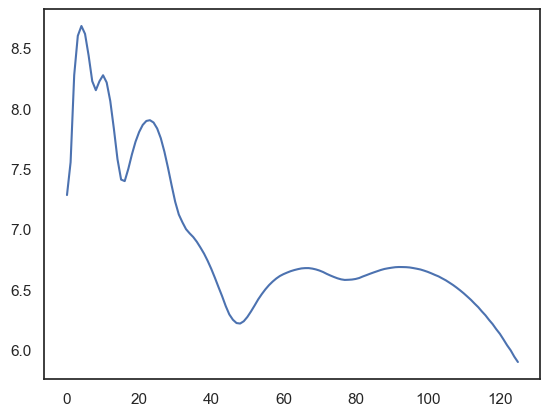

In [91]:
plt.plot(log_sig)

## new pipeline

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA, FastICA

# you already have:
# waveforms_df, trials_df, phasic_fpps, tonic_fpps, phasic_sigs, tonic_sigs

# signatures: lists of 2D arrays (n_cycles x n_freqs), freq=15..140
frequencies = np.arange(15, 141, 1)  # 15–140 Hz
def _stack_sigs(sig_list):
    sig_list = [a for a in sig_list if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[0] > 0]
    return np.vstack(sig_list) if sig_list else np.empty((0, len(frequencies)))

X_phasic  = _stack_sigs(phasic_sigs)
X_tonic   = _stack_sigs(tonic_sigs)
X_all     = np.vstack([X_phasic, X_tonic]) if (X_phasic.size or X_tonic.size) else np.empty((0, len(frequencies)))

print("Signatures (n_cycles x n_freqs):", X_phasic.shape, X_tonic.shape, X_all.shape)

# make sure trials_df counts match signatures
n_phasic_trials = int((trials_df['cycle_type'].str.lower() == 'phasic').sum())
n_tonic_trials  = int((trials_df['cycle_type'].str.lower()  == 'tonic').sum())
assert X_phasic.shape[0] == n_phasic_trials, f"phasic count mismatch: sigs={X_phasic.shape[0]} vs trials={n_phasic_trials}"
assert X_tonic.shape[0]  == n_tonic_trials,  f"tonic  count mismatch: sigs={X_tonic.shape[0]}  vs trials={n_tonic_trials}"


Signatures (n_cycles x n_freqs): (2899, 126) (58272, 126) (61171, 126)


In [43]:
def train_pca_ica_from_signatures(X, n_components=5, random_state=42):
    assert X.ndim == 2 and X.shape[0] >= n_components
    # center features (per frequency)
    Xc = X - X.mean(axis=0, keepdims=True)

    # quick QC: if std at high-γ is ~0, nothing to extract
    perfreq_std = Xc.std(axis=0)
    # (optional) print(f"min/std at 100–140 Hz:", perfreq_std[85:])  # 15->index0, so 100Hz≈idx 85

    pca = PCA(n_components=n_components, random_state=random_state)
    Z   = pca.fit_transform(Xc)
    ica = FastICA(n_components=n_components, random_state=random_state, max_iter=2000, tol=1e-4)
    S   = ica.fit_transform(Z)

    # tSCs in frequency space
    W = ica.components_.dot(pca.components_)   # (n_comp x n_freqs)

    # orient sign so the mean projection is positive (paper convention)
    strengths = Xc.dot(W.T)                    # (n_cycles x n_comp)
    signs = np.sign(strengths.mean(axis=0, keepdims=True))  # (1 x n_comp), 0 -> +1
    signs[signs == 0] = 1
    W *= signs.T
    strengths *= signs

    return pca, ica, Xc, W, strengths

In [44]:
X_phasic  = _stack_sigs(phasic_sigs)
X_tonic   = _stack_sigs(tonic_sigs)
X_all     = np.vstack([X_phasic, X_tonic]) if (X_phasic.size or X_tonic.size) else np.empty((0, len(frequencies)))

pca_model, ica_model, X_all_c, W, S_all = train_pca_ica_from_signatures(X_all, n_components=5)

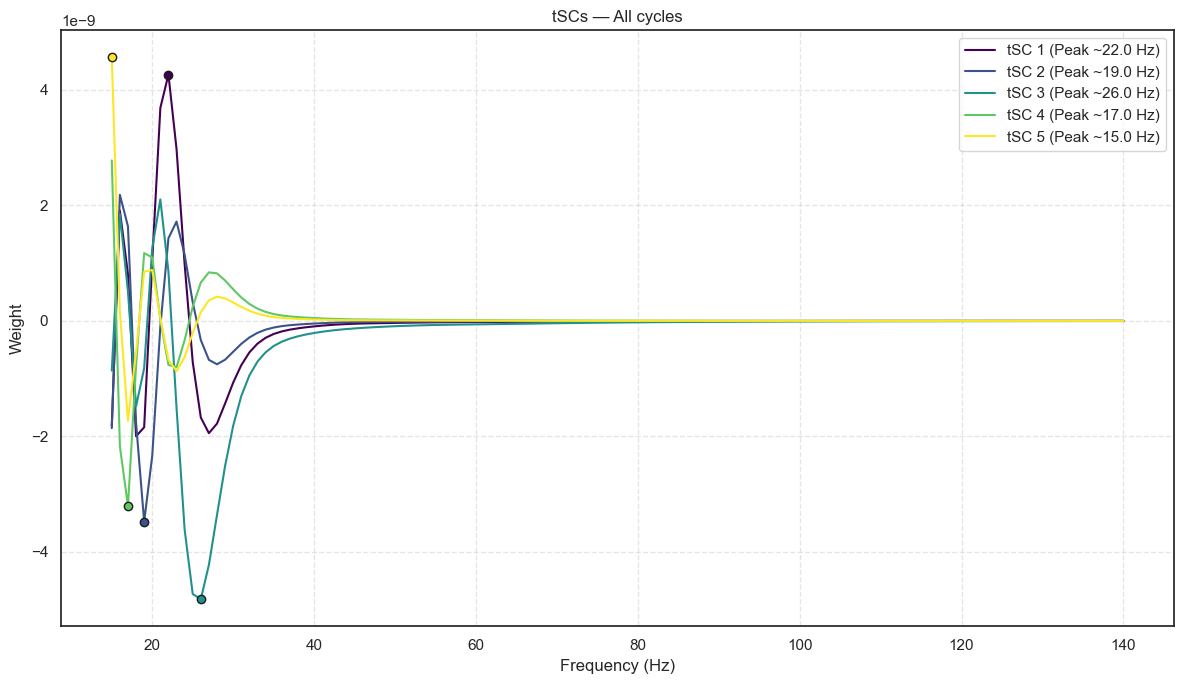

In [46]:
def plot_tSCs(W, freqs, title="tSCs — All cycles"):
    n = W.shape[0]
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    plt.figure(figsize=(12, 7))
    for i in range(n):
        w = W[i]
        pk = np.argmax(np.abs(w))
        plt.plot(freqs, w, color=colors[i], label=f"tSC {i+1} (Peak ~{freqs[pk]:.1f} Hz)")
        plt.scatter(freqs[pk], w[pk], color=colors[i], edgecolor='k', zorder=5)
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Weight"); plt.title(title)
    plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

plot_tSCs(W, np.arange(15,141), "tSCs — All cycles")

In [24]:
# split back to phasic/tonic
nP = X_phasic.shape[0]
S_phasic = S_all[:nP]
S_tonic  = S_all[nP:]

# MAD-threshold per component
def mad_masks(S, k=3.0):
    med = np.median(S, axis=0, keepdims=True)
    mad = np.median(np.abs(S - med), axis=0, keepdims=True) + 1e-12
    return S > (med + k*mad)

mask_all = mad_masks(S_all, k=3.0)
mask_ph  = mask_all[:nP]
mask_to  = mask_all[nP:]

# attach to trials_df (order is already aligned with how you appended)
trials_df = trials_df.copy()
cols_str  = [f"tSC{i+1}_strength" for i in range(W.shape[0])]
cols_bool = [f"tSC{i+1}_strong"   for i in range(W.shape[0])]
for c in cols_str + cols_bool:
    trials_df[c] = np.nan if c.endswith("strength") else False

maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values
trials_df.loc[maskP, cols_str]  = S_phasic
trials_df.loc[maskP, cols_bool] = mask_ph
if S_tonic.size:
    trials_df.loc[maskT, cols_str]  = S_tonic
    trials_df.loc[maskT, cols_bool] = mask_to

# single-label (for transitions etc.), using argmax(|strength|)
SA = trials_df[cols_str].to_numpy(float)
valid = ~np.any(np.isnan(SA), axis=1)
trials_df['tSC_component'] = np.nan
trials_df.loc[valid, 'tSC_component'] = np.argmax(np.abs(SA[valid]), axis=1)
trials_df['tSC_component_1based'] = trials_df['tSC_component'] + 1

In [25]:
frequencies = np.arange(15, 141, 1)

def _modes_from_sig_list(sig_list, freqs):
    modes = []
    for SIG in sig_list:
        if isinstance(SIG, np.ndarray) and SIG.ndim == 2 and SIG.shape[0] > 0:
            idx = np.argmax(SIG, axis=1)
            modes.append(freqs[idx])
    return np.concatenate(modes) if modes else np.array([], dtype=float)

modes_phasic = _modes_from_sig_list(phasic_sigs, frequencies)
modes_tonic  = _modes_from_sig_list(tonic_sigs,  frequencies)

trials_df = trials_df.copy()
maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values

assert modes_phasic.size == maskP.sum()
assert modes_tonic.size  == maskT.sum()

trials_df.loc[maskP, 'mode_freqs_sig'] = modes_phasic
trials_df.loc[maskT, 'mode_freqs_sig'] = modes_tonic

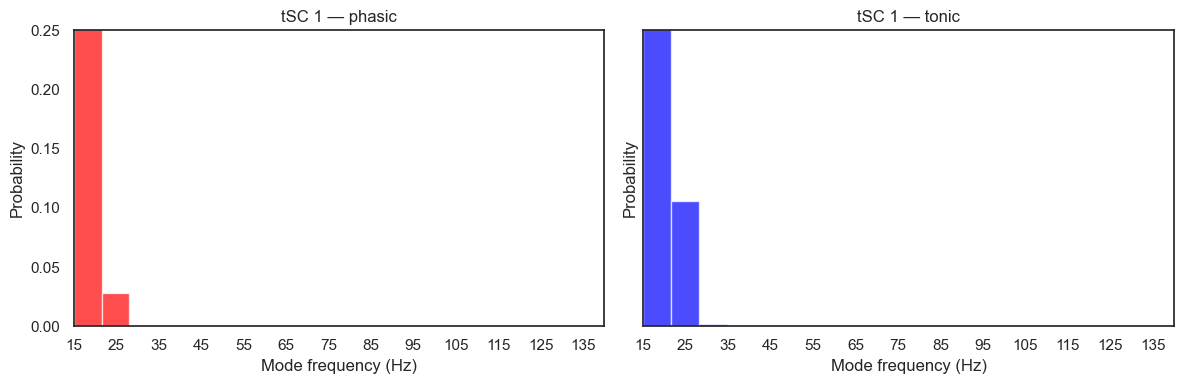

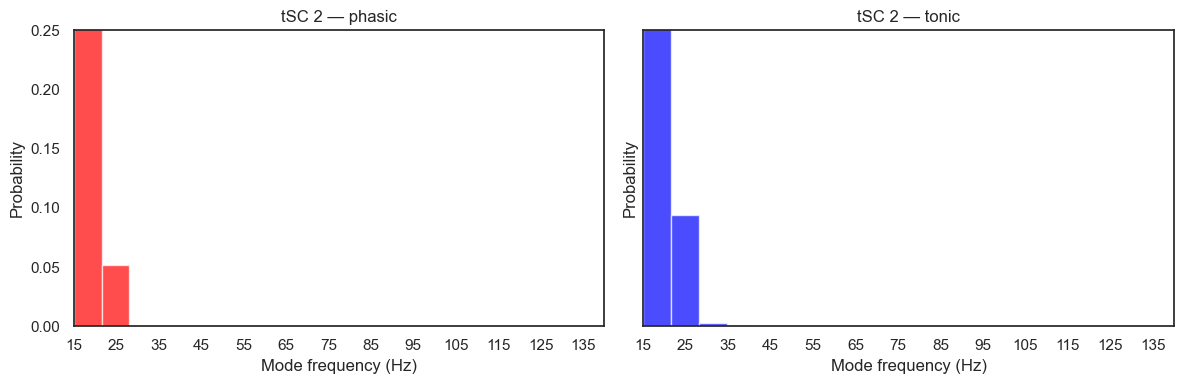

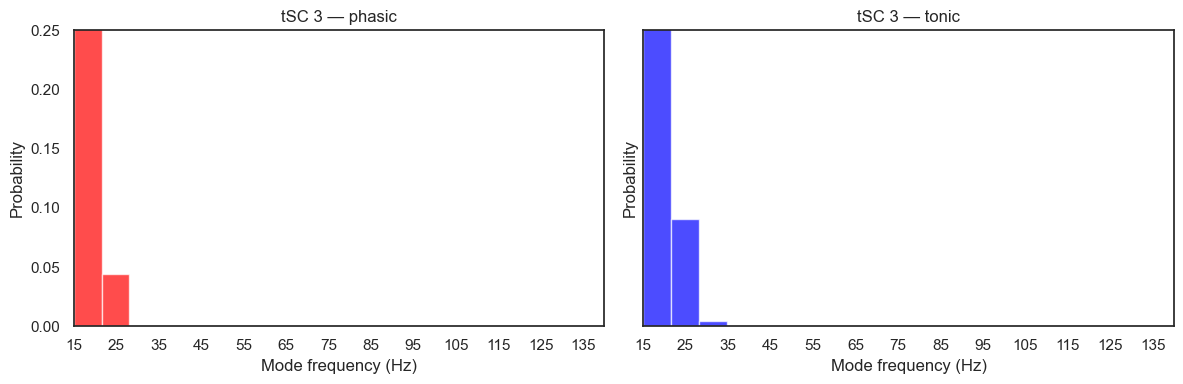

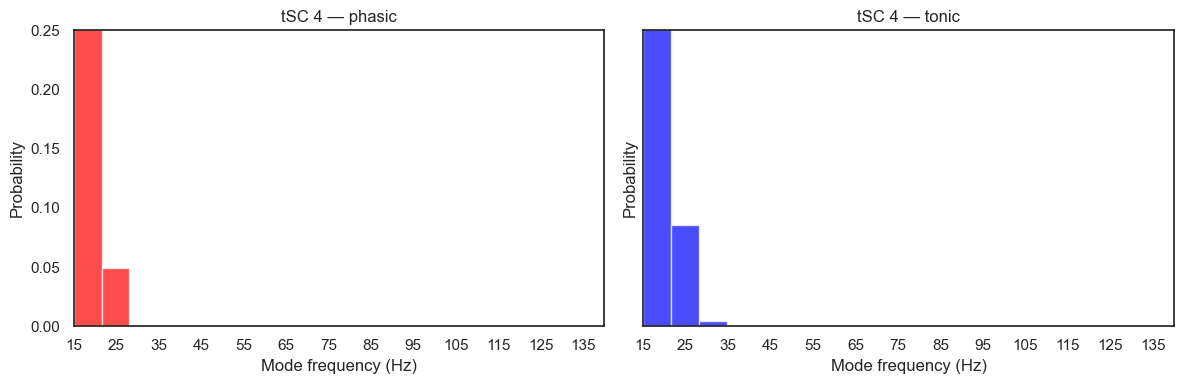

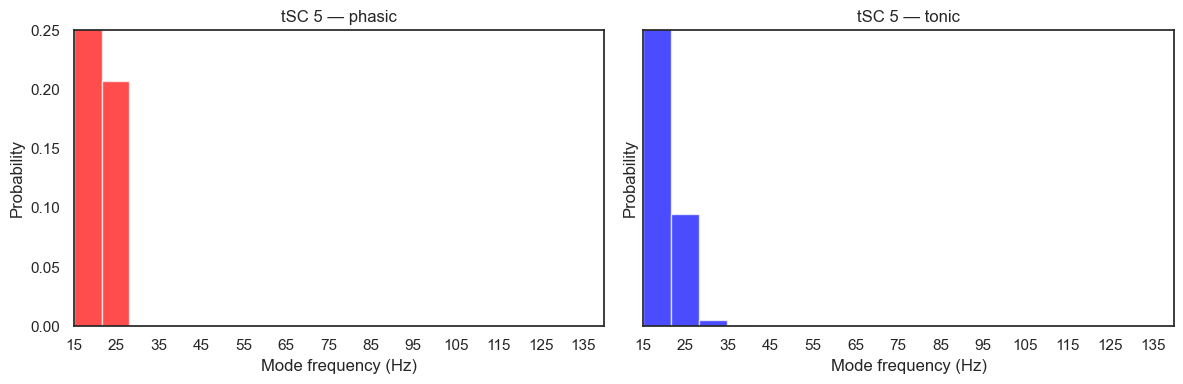

In [26]:
bins   = np.linspace(15, 140, 20)
xticks = np.arange(15, 141, 10)
ymax   = 0.25
for k in range(1, W.shape[0] + 1):
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    for j, ctype in enumerate(["phasic","tonic"]):
        ax = axes[j]
        sub = trials_df[
            (trials_df['cycle_type']==ctype) &
            (trials_df[f'tSC{k}_strong'] == True) &
            trials_df['mode_freqs_sig'].between(15,140)
        ]
        vals = sub['mode_freqs_sig'].to_numpy()
        if vals.size:
            ax.hist(vals, bins=bins, weights=np.ones_like(vals)/vals.size,
                    alpha=0.7, color=('red' if ctype=='phasic' else 'blue'))
        ax.set(title=f"tSC {k} — {ctype}", xlabel="Mode frequency (Hz)", ylabel="Probability",
               xlim=(15,140), ylim=(0,ymax)); ax.set_xticks(xticks)
    plt.tight_layout(); plt.show()

In [52]:
def mad_threshold_masks(S, k=3.0):
    """
    S: (n_cycles x n_comp) strengths
    Returns boolean mask (n_cycles x n_comp): strong per component
    """
    med = np.median(S, axis=0, keepdims=True)
    mad = np.median(np.abs(S - med), axis=0, keepdims=True) + 1e-12
    return S > (med + k * mad)

strong_mask_all = mad_threshold_masks(S_all, k=3.0)
strong_mask_ph  = strong_mask_all[:S_phasic.shape[0], :]
strong_mask_to  = strong_mask_all[S_phasic.shape[0]:, :] if S_tonic.size else np.empty((0, strong_mask_all.shape[1]), dtype=bool)

In [53]:
trials_df = trials_df.copy()
nP, nT = S_phasic.shape[0], S_tonic.shape[0]

# allocate columns
for j in range(n_components_pca):
    trials_df[f'tSC{j+1}_strength'] = np.nan
    trials_df[f'tSC{j+1}_strong']   = False

# fill phasic
maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
trials_df.loc[maskP, [f'tSC{i+1}_strength' for i in range(n_components_pca)]] = S_phasic
trials_df.loc[maskP, [f'tSC{i+1}_strong'   for i in range(n_components_pca)]] = strong_mask_ph

# fill tonic
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values
if nT > 0:
    trials_df.loc[maskT, [f'tSC{i+1}_strength' for i in range(n_components_pca)]] = S_tonic
    trials_df.loc[maskT, [f'tSC{i+1}_strong'   for i in range(n_components_pca)]] = strong_mask_to

# if you still want a single label per cycle (for transitions etc.), use argmax |strength|
strength_array = trials_df[[f'tSC{i+1}_strength' for i in range(n_components_pca)]].to_numpy(dtype=float)
trials_df['tSC_component'] = np.nan
valid_rows = ~np.any(np.isnan(strength_array), axis=1)
trials_df.loc[valid_rows, 'tSC_component'] = np.argmax(np.abs(strength_array[valid_rows]), axis=1)
trials_df['tSC_component_1based'] = trials_df['tSC_component'] + 1

In [54]:
def sequences_from_sig_list(sig_list, pca, ica):
    seqs = []
    if not sig_list: return seqs
    W = get_tSC_weight_vectors(pca, ica)
    # center per-frequency using the same global mean used in training:
    # we’ll pass the global mean as an argument to avoid recomputing; or recompute from X_all
    # Here we reuse the trained PCA mean (pca.mean_) applied to features
    for SIG in sig_list:
        if SIG.size == 0: 
            continue
        SIGc = SIG - pca.mean_  # same centering as training (since Xc = X - X.mean)
        S = SIGc.dot(W.T)       # strengths
        seq = np.argmax(np.abs(S), axis=1)
        seqs.append(seq)
    return seqs

phasic_sequences = sequences_from_sig_list(phasic_sigs, pca_model, ica_model)
tonic_sequences  = sequences_from_sig_list(tonic_sigs,  pca_model, ica_model)

def calculate_transition_matrix(component_sequences):
    if not any(len(s) > 1 for s in component_sequences):
        return np.array([[]])
    max_id = max((int(np.max(s)) for s in component_sequences if len(s) > 0), default=-1)
    n = max_id + 1
    M = np.zeros((n, n), dtype=int)
    for s in component_sequences:
        for i in range(len(s) - 1):
            M[s[i], s[i+1]] += 1
    return M

M_phasic = calculate_transition_matrix(phasic_sequences)
M_tonic  = calculate_transition_matrix(tonic_sequences)

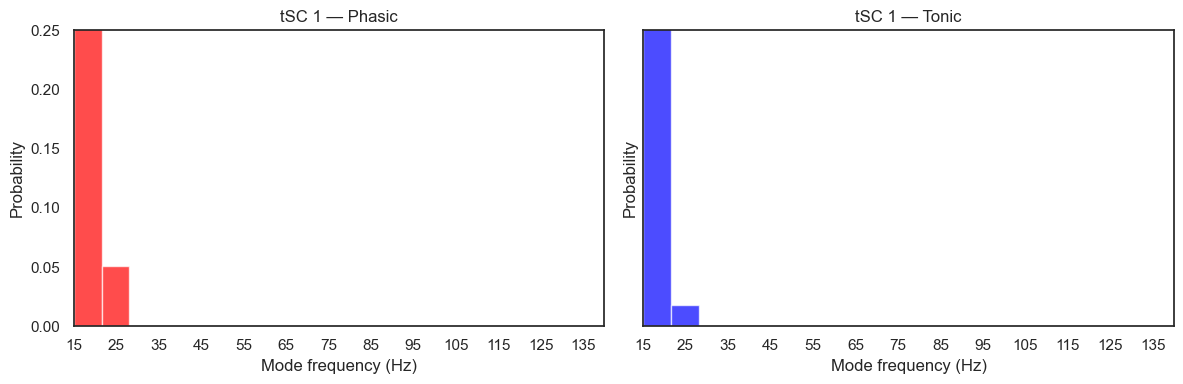

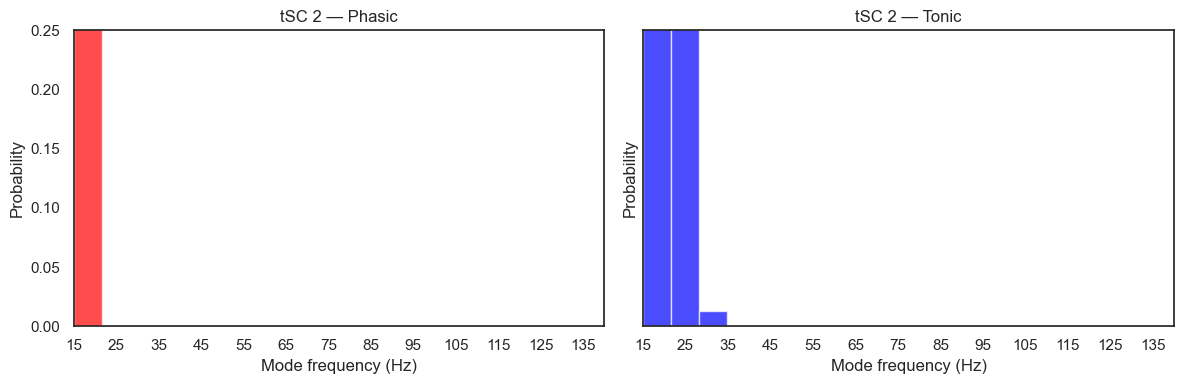

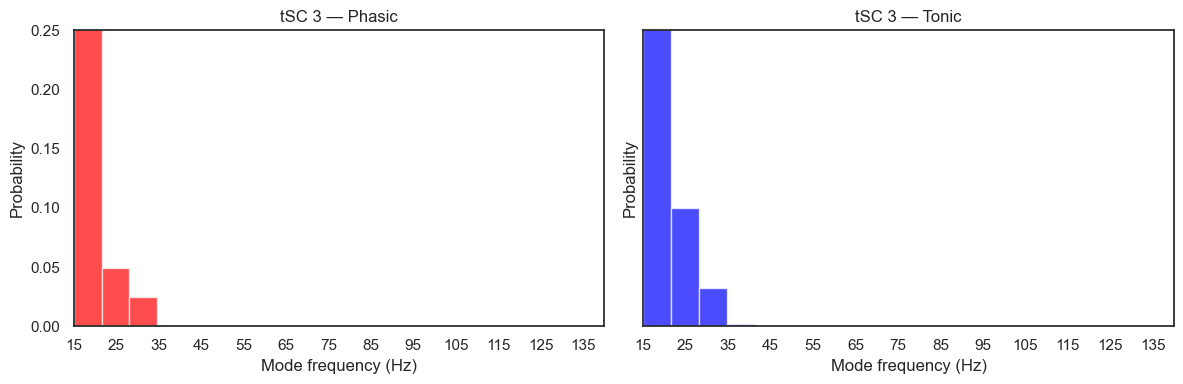

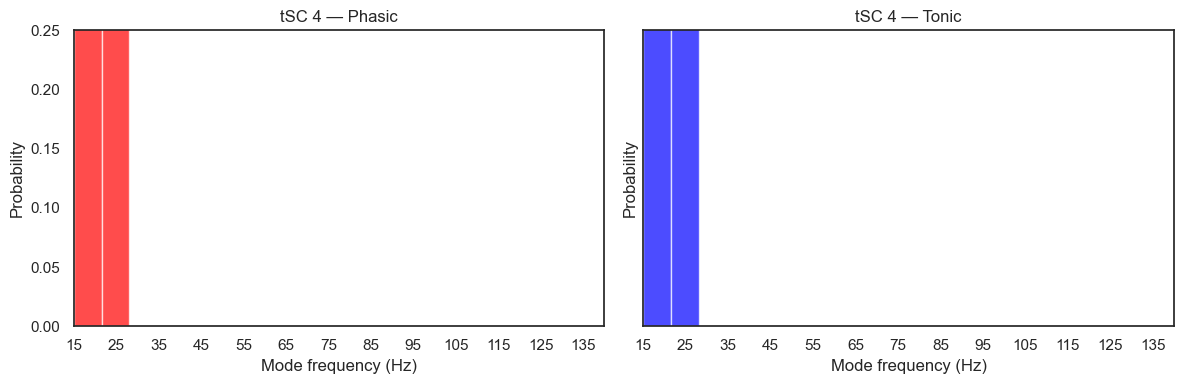

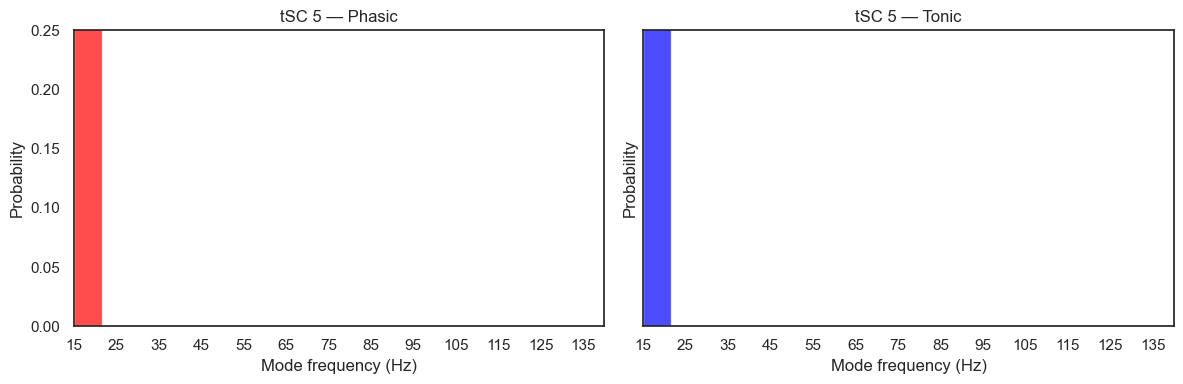

In [55]:
import numpy as np
import matplotlib.pyplot as plt

frequencies = np.arange(15, 141, 1)
bins = np.linspace(15, 140, 20)
xlim = (15, 140)
xticks = np.arange(15, 141, 10)
normalization = "prob"   # "prob" or "pdf"
ymax = 0.25 if normalization == "prob" else 0.05

components = range(1, n_components_pca + 1)
df = trials_df.loc[
    trials_df["mode_freqs"].between(15, 140) &
    trials_df["cycle_type"].isin(["phasic", "tonic"])
].copy()

for comp1 in components:
    comp_col_strength = f"tSC{comp1}_strength"
    comp_col_strong   = f"tSC{comp1}_strong"

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for j, ctype in enumerate(["phasic", "tonic"]):
        ax = axes[j]
        sub = df[(df["cycle_type"] == ctype) & (df[comp_col_strong] == True)]
        values = sub["mode_freqs"].to_numpy()

        if values.size > 0:
            if normalization == "prob":
                weights = np.ones_like(values, dtype=float) / values.size
                ax.hist(values, bins=bins, weights=weights, alpha=0.7,
                        color=("red" if ctype == "phasic" else "blue"))
                ylabel = "Probability"
            else:
                ax.hist(values, bins=bins, density=True, alpha=0.7,
                        color=("red" if ctype == "phasic" else "blue"))
                ylabel = "Probability density (1/Hz)"
        else:
            ylabel = "Probability" if normalization == "prob" else "Probability density (1/Hz)"

        ax.set_xlim(*xlim); ax.set_xticks(xticks)
        ax.set_xlabel("Mode frequency (Hz)"); ax.set_ylabel(ylabel)
        ax.set_title(f"tSC {comp1} — {ctype.capitalize()}")
        ax.set_ylim(0, ymax)

    plt.tight_layout(); plt.show()

In [56]:
# If you still want to visualize average FPP or average spectra (phase-collapsed) just for QC:
def flatten_fpp_data_final(fpps_by_rat):
    all_2d = []
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list): continue
        for arr3 in rat_data_list:
            if isinstance(arr3, np.ndarray) and arr3.ndim == 3 and arr3.shape[0] > 0:
                for i in range(arr3.shape[0]):  # cycles
                    all_2d.append(arr3[i, :, :]) # (freq x phase)
    return all_2d

def process_fpps_for_plotting(fpp_list, description=""):
    from collections import Counter
    if not fpp_list:
        print(f"No FPPs to process for {description}.")
        return None
    shape_counts = Counter(arr.shape for arr in fpp_list if isinstance(arr, np.ndarray))
    if not shape_counts: return None
    most_common_shape = shape_counts.most_common(1)[0][0]
    valid = [a for a in fpp_list if hasattr(a, 'shape') and a.shape == most_common_shape]
    stacked = np.stack(valid, axis=0)           # (n_cycles x freq x phase)
    avg_fpp = stacked.mean(axis=0)              # (freq x phase)
    all_signatures = stacked.mean(axis=2)       # collapse phase -> (n_cycles x freq)
    mean_signature = all_signatures.mean(axis=0)
    std_signature  = all_signatures.std(axis=0)
    return {'avg_fpp': avg_fpp, 'mean_signature': mean_signature, 'std_signature': std_signature}

# make wrappers from your np.empty(1,dtype=object) containers
flattened_phasic = flatten_fpp_data_final(all_phasic_fpps)
flattened_tonic  = flatten_fpp_data_final(all_tonic_fpps)

phasic_processed = process_fpps_for_plotting(flattened_phasic, "Phasic REM")
tonic_processed  = process_fpps_for_plotting(flattened_tonic,  "Tonic REM")

# new 2

Signatures raw shapes: (2899, 126) (58272, 126) (61171, 126)


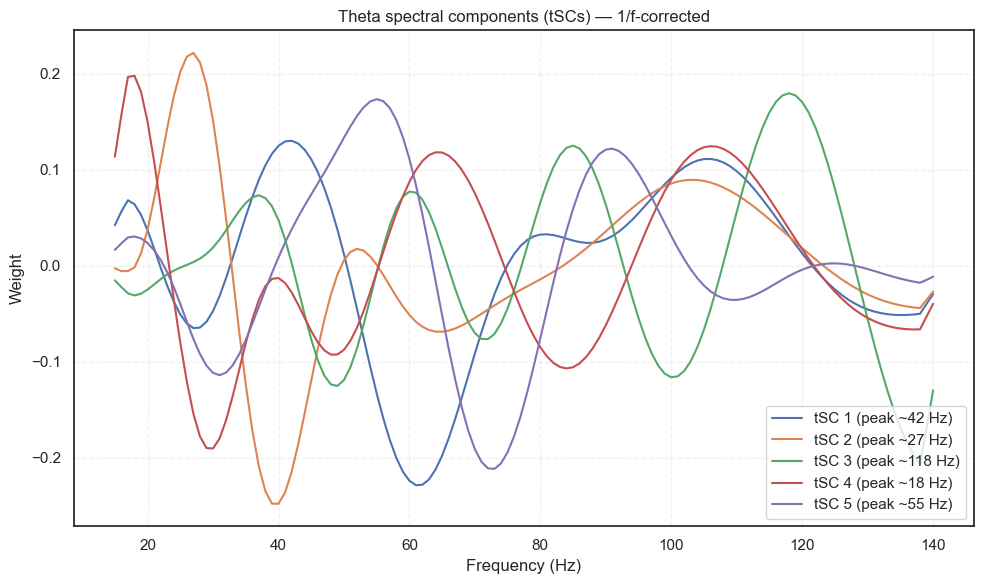

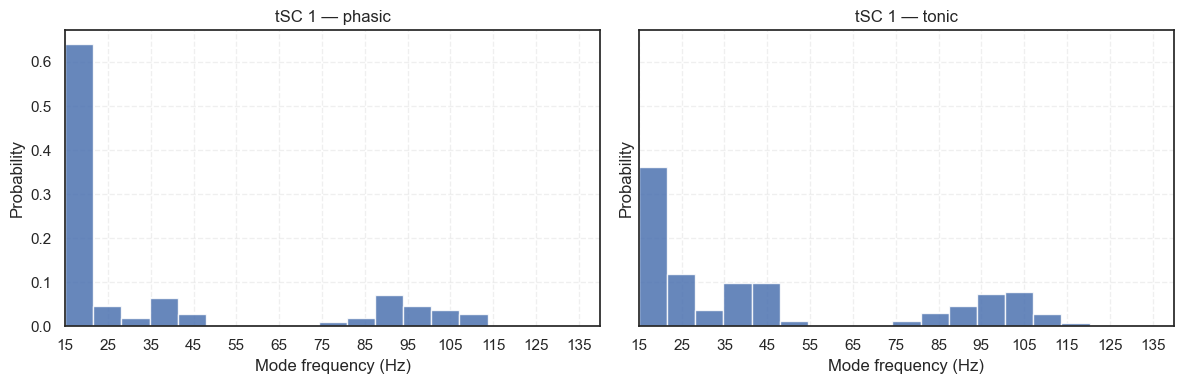

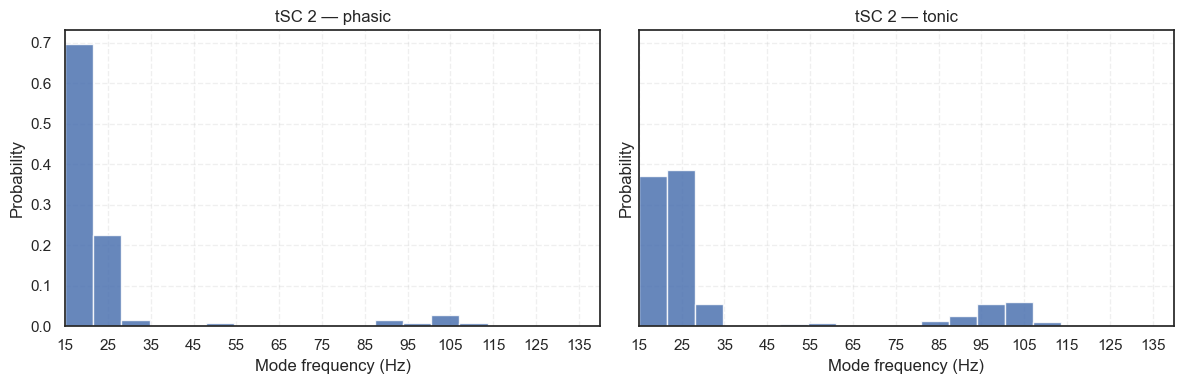

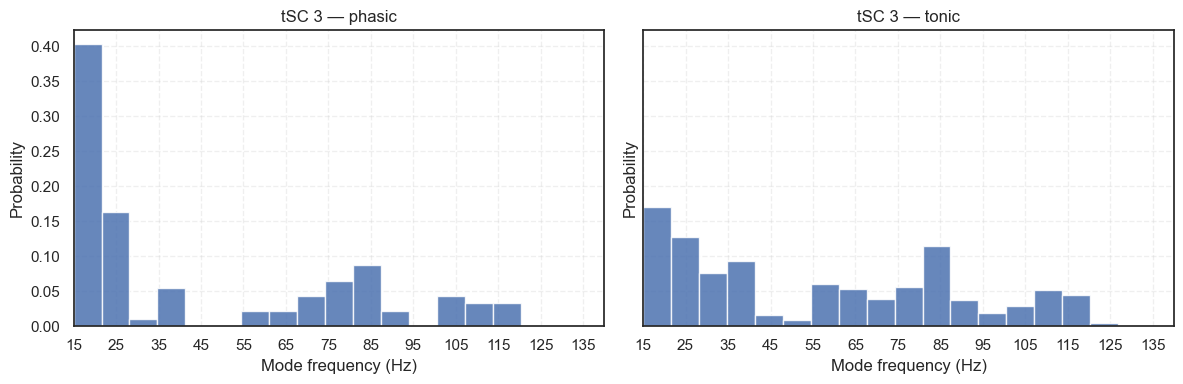

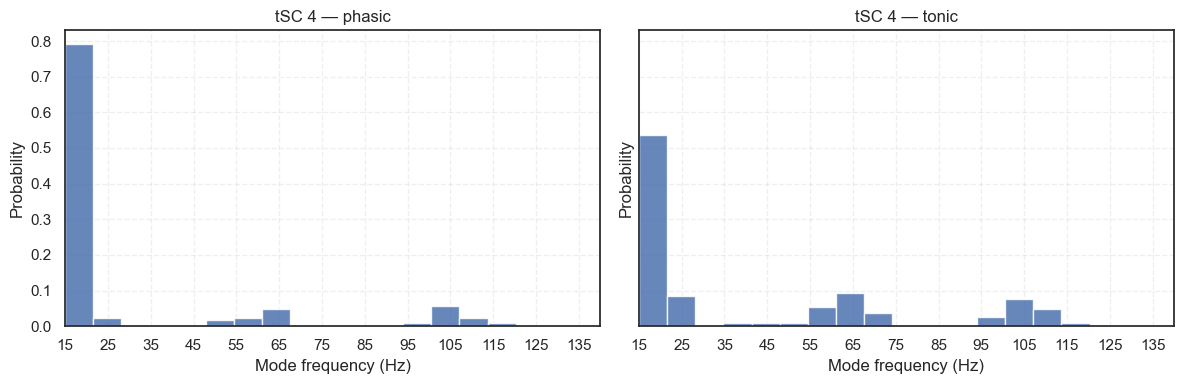

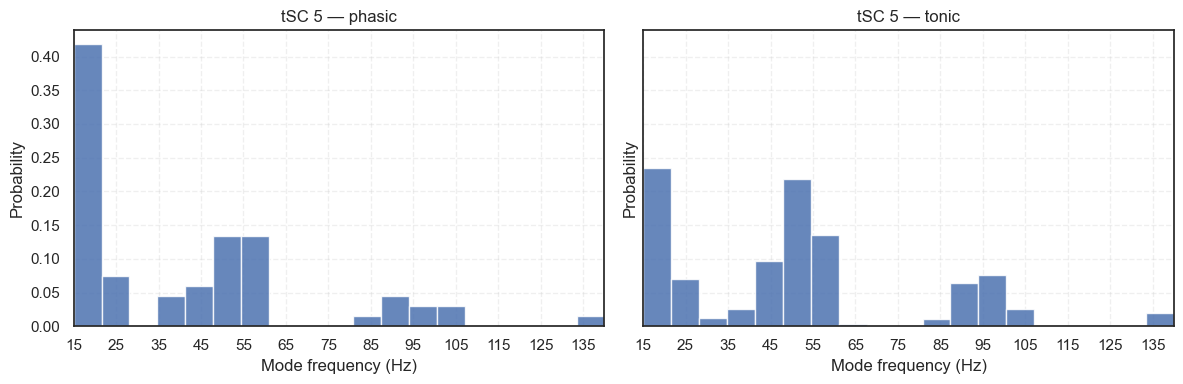

Thresholds per tSC: [2.33715014 2.15785439 1.50468911 2.06561788 2.02282454]


In [ ]:
# =========================
# FIXED tSCs + mode-frequency dists (paper-like)
# Train PCA/ICA on ALL cycles (phasic+tonic pooled), project back to each group,
# use 1/f-corrected cycle signatures, and compute mode frequencies from those corrected signatures.
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

frequencies = np.arange(15, 141, 1)   # 15–140 Hz
EPS = 1e-12

# -------------------------
# 0) OPTIONAL: if you still compute raw_power upstream with sails.wavelet.morlet(..., normalise=None),
#    switch that call to energy normalization in your prepare_data_for_components_v2:
#       raw_power = sails.wavelet.morlet(
#           supra_theta_sig, freqs=frequencies, sample_rate=fs,
#           ncycles=5, ret_mode='power', normalise='energy'
#       )
#    If 'energy' is not supported in your sails version, leave normalise=None and rely on the 1/f correction below.
# -------------------------

def _stack_sigs(sig_list, n_freqs):
    sig_list = [a for a in sig_list if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[1] == n_freqs and a.shape[0] > 0]
    return np.vstack(sig_list) if sig_list else np.empty((0, n_freqs))

def _mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m))

def _robust_thr(x):
    return np.median(x) + (2.0 / 0.6745) * _mad(x)

# --- PATCH: stable per-cycle 1/f removal (no explicit inverse; handles rank issues) ---

EPS = 1e-12  # keep if not already defined

def _log10_safe(x):
    return np.log10(np.maximum(x, EPS))

def _per_cycle_1overf_residuals(SIG_raw, freqs):
    """
    For each cycle's spectrum y(f)=log10(P), fit y ≈ a - β*log10(f) with least squares
    using a single design matrix for all cycles. Works even if XtX is singular.
    Returns residuals y - yhat (shape: n_cycles x n_freqs).
    """
    if SIG_raw.size == 0:
        return SIG_raw

    # ensure finite
    SIG_raw = np.asarray(SIG_raw, float)
    SIG_raw[~np.isfinite(SIG_raw)] = EPS

    y = _log10_safe(SIG_raw)                     # (n_cycles, n_freqs)
    x = np.log10(np.asarray(freqs, float) + 1e-9)  # (n_freqs,)
    # Design matrix: [1, -log10(f)]
    D = np.column_stack([np.ones_like(x), -x])   # (n_freqs, 2)

    # Solve D @ coef = y.T  -> coef = (2 x n_cycles)
    # Use lstsq (stable) or pinv fallback
    try:
        coef, *_ = np.linalg.lstsq(D, y.T, rcond=None)  # (2, n_cycles)
    except np.linalg.LinAlgError:
        coef = np.linalg.pinv(D) @ y.T                  # (2, n_cycles)

    yhat = (D @ coef).T                                 # (n_cycles, n_freqs)
    resid = y - yhat

    # Replace any tiny numerical issues
    resid[~np.isfinite(resid)] = 0.0
    return resid

# def _per_cycle_1overf_residuals(SIG_raw, freqs, fit_floor_hz=20):
#     """
#     Per-cycle 1/f removal with a *restricted fit range* (>= fit_floor_hz).
#     This avoids bias from band edge (15–18 Hz) and theta-harmonic bleed.
#     """
#     if SIG_raw.size == 0:
#         return SIG_raw

#     SIG_raw = np.asarray(SIG_raw, float)
#     SIG_raw[~np.isfinite(SIG_raw)] = EPS

#     ylog = _log10_safe(SIG_raw)                  # (n_cycles, n_freqs)

#     f = np.asarray(freqs, float)
#     mask = f >= float(fit_floor_hz)
#     x = np.log10(f[mask] + 1e-9)                 # (n_fit,)
#     D = np.column_stack([np.ones_like(x), -x])   # (n_fit, 2)

#     # solve D @ coef = ylog[:, mask].T  -> coef: (2, n_cycles)
#     coef, *_ = np.linalg.lstsq(D, ylog[:, mask].T, rcond=None)
#     # full design for all freqs (to compute yhat everywhere)
#     x_full = np.log10(f + 1e-9)
#     D_full = np.column_stack([np.ones_like(x_full), -x_full])  # (n_freqs, 2)
#     yhat = (D_full @ coef).T                                   # (n_cycles, n_freqs)
#     resid = ylog - yhat
#     resid[~np.isfinite(resid)] = 0.0
#     return resid

def _smooth_signatures(SIG, kernel_size=5):
    """smooth each row (spectrum of one cycle) with a flat kernel"""
    if SIG.size == 0:
        return SIG
    kernel = np.ones(kernel_size) / kernel_size
    SIG_sm = np.apply_along_axis(
        lambda v: np.convolve(v, kernel, mode='same'), axis=1, arr=SIG
    )
    return SIG_sm

def _prep_features(SIG_raw, freqs, strategy="per_cycle_fit", smooth_kernel=5):
    if strategy == "per_cycle_fit":
        SIG_corr = _per_cycle_1overf_residuals(SIG_raw, freqs)
        if smooth_kernel and smooth_kernel > 1:
            SIG_corr = _smooth_signatures(SIG_corr, kernel_size=smooth_kernel)
        X = SIG_corr
        meta = {"mode_source": SIG_corr, "do_log": False, "mu": None, "sd": None}
    elif strategy == "per_freq_z":
        Xlog = _log10_safe(SIG_raw)
        mu = Xlog.mean(axis=0, keepdims=True)
        sd = Xlog.std(axis=0, keepdims=True) + 1e-12
        X = (Xlog - mu) / sd
        if smooth_kernel and smooth_kernel > 1:
            X = _smooth_signatures(X, kernel_size=smooth_kernel)
        meta = {"mode_source": Xlog, "do_log": False, "mu": mu, "sd": sd}
    else:
        Xlog = _log10_safe(SIG_raw)
        mu = Xlog.mean(axis=0, keepdims=True)
        X = Xlog - mu
        if smooth_kernel and smooth_kernel > 1:
            X = _smooth_signatures(X, kernel_size=smooth_kernel)
        meta = {"mode_source": Xlog, "do_log": False, "mu": mu, "sd": np.ones_like(mu)}
    return X, meta

def _fit_pca_ica(X_all, n_pcs=None, var_target=0.85, n_ics=5, random_state=0):
    """
    PCA (whiten) -> FastICA; map IC axes back to frequency space:
      W = ICA_components @ PCA_components
    """
    if n_pcs is None:
        pca0 = PCA(random_state=random_state, whiten=False).fit(X_all)
        evr  = pca0.explained_variance_ratio_
        n_pcs = int(np.searchsorted(np.cumsum(evr), var_target) + 1)
    n_pcs = max(1, min(n_pcs, X_all.shape[1]))

    pca = PCA(n_components=n_pcs, random_state=random_state, whiten=True)
    Z   = pca.fit_transform(X_all)                           # (n_cycles, n_pcs)
    ica = FastICA(n_components=n_ics, random_state=random_state,
                  whiten="unit-variance", max_iter=1000)
    S   = ica.fit_transform(Z)                               # (n_cycles, n_ics)
    W   = ica.components_.dot(pca.components_)               # (n_ics, n_freqs)

    # orient by positive mean projection on ALL cycles
    strengths_all = X_all.dot(W.T)
    sgn = np.sign(strengths_all.mean(axis=0, keepdims=True)); sgn[sgn == 0] = 1
    W *= sgn.T
    strengths_all *= sgn
    return W, pca, ica, strengths_all

def _project_strengths(SIG_group_raw, freqs, W, meta, strategy="per_cycle_fit"):
    """
    Use the SAME preprocessing as training to project a group's signatures.
    """
    if SIG_group_raw.size == 0:
        return np.empty((0, W.shape[0]))
    if strategy == "per_cycle_fit":
        Xg = _per_cycle_1overf_residuals(SIG_group_raw, freqs)
    elif strategy == "per_freq_z":
        Xlog = _log10_safe(SIG_group_raw)
        Xg   = (Xlog - meta["mu"]) / meta["sd"]
    else:
        Xlog = _log10_safe(SIG_group_raw)
        Xg   = Xlog - meta["mu"]
    return Xg.dot(W.T)

def _mode_freqs(SIG_group_for_modes, freqs):
    """Mode frequency from the array provided (we pass the 1/f-corrected signatures)."""
    if SIG_group_for_modes.size == 0:
        return np.array([], dtype=float)
    idx = np.argmax(SIG_group_for_modes, axis=1)
    return freqs[idx]

# -------------------------
# 1) Stack PHASIC/TONIC signatures from your existing extraction
#     (phasic_sigs / tonic_sigs must be lists of (n_cycles x n_freqs) arrays)
# -------------------------
X_phasic_raw = _stack_sigs(phasic_sigs, len(frequencies))
X_tonic_raw  = _stack_sigs(tonic_sigs,  len(frequencies))
X_all_raw    = np.vstack([X_phasic_raw, X_tonic_raw]) if (X_phasic_raw.size or X_tonic_raw.size) else np.empty((0, len(frequencies)))
print("Signatures raw shapes:", X_phasic_raw.shape, X_tonic_raw.shape, X_all_raw.shape)

# optional sanity: counts should match trials_df rows by cycle_type
nP = int((trials_df['cycle_type'].str.lower() == 'phasic').sum())
nT = int((trials_df['cycle_type'].str.lower()  == 'tonic').sum())
assert X_phasic_raw.shape[0] == nP, f"phasic mismatch {X_phasic_raw.shape[0]} vs {nP}"
assert X_tonic_raw.shape[0]  == nT, f"tonic  mismatch {X_tonic_raw.shape[0]} vs {nT}"

# -------------------------
# 2) FEATURES: 1/f-corrected (per-cycle fit)  <<--- KEY CHANGE
# -------------------------
X_all, meta = _prep_features(X_all_raw, frequencies, strategy="per_cycle_fit", smooth_kernel=5)

# -------------------------
# 3) PCA→ICA once on ALL cycles
# -------------------------
W, pca_model, ica_model, S_all = _fit_pca_ica(X_all, n_pcs=None, var_target=0.85, n_ics=5, random_state=42)
n_ics = W.shape[0]

# -------------------------
# 4) Project groups using the SAME preprocessing
# -------------------------
S_phasic = _project_strengths(X_phasic_raw, frequencies, W, meta, strategy=strategy)
S_tonic  = _project_strengths(X_tonic_raw,  frequencies, W, meta, strategy=strategy)

# -------------------------
# 5) Robust thresholds from ALL strengths, mark strong per group
# -------------------------
thr = np.array([_robust_thr(S_all[:, j]) for j in range(n_ics)])
phasic_strong = (S_phasic >= thr.reshape(1, -1))
tonic_strong  = (S_tonic  >= thr.reshape(1, -1))

# -------------------------
# 6) Mode frequencies from 1/f-corrected signatures  <<--- KEY CHANGE
#     (use meta['mode_source'] for ALL cycles; split back into phasic/tonic)
# -------------------------
SIG_corr_all = _per_cycle_1overf_residuals(X_all_raw, frequencies)    # same as training
SIG_corr_P   = SIG_corr_all[:nP, :]
SIG_corr_T   = SIG_corr_all[nP:, :] if nT > 0 else np.empty((0, len(frequencies)))

modes_phasic = _mode_freqs(SIG_corr_P, frequencies)
modes_tonic  = _mode_freqs(SIG_corr_T, frequencies)

# attach to trials_df in original order (phasic rows first, then tonic rows)
trials_df = trials_df.copy()
maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values

trials_df.loc[maskP, 'mode_freqs_sig'] = modes_phasic
trials_df.loc[maskT, 'mode_freqs_sig'] = modes_tonic

for k in range(n_ics):
    trials_df.loc[maskP, f"tSC{k+1}_strong"] = phasic_strong[:, k]
    trials_df.loc[maskT, f"tSC{k+1}_strong"] = tonic_strong[:,  k]

# -------------------------
# 7) Plots: tSC shapes and per-tSC mode-frequency distributions
# -------------------------
plt.figure(figsize=(10, 6))
for i in range(n_ics):
    w = W[i]
    pk = np.argmax(w)
    plt.plot(frequencies, w, label=f"tSC {i+1} (peak ~{frequencies[pk]} Hz)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Weight"); plt.title("Theta spectral components (tSCs) — 1/f-corrected")
plt.grid(alpha=0.3, ls='--'); plt.legend(); plt.tight_layout(); plt.show()

bins   = np.linspace(15, 140, 20)
xticks = np.arange(15, 141, 10)
for k in range(n_ics):
    col = f"tSC{k+1}_strong"
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for j, ctype in enumerate(['phasic', 'tonic']):
        ax = axes[j]
        sub = trials_df[
            (trials_df['cycle_type'].str.lower() == ctype) &
            (trials_df[col] == True) &
            trials_df['mode_freqs_sig'].between(15, 140)
        ]
        vals = sub['mode_freqs_sig'].to_numpy(dtype=float)
        if vals.size:
            ax.hist(vals, bins=bins, weights=np.ones_like(vals)/vals.size, alpha=0.85)
        ax.set(title=f"tSC {k+1} — {ctype}", xlabel="Mode frequency (Hz)", ylabel="Probability",
               xlim=(15, 140))
        ax.set_xticks(xticks); ax.grid(alpha=0.3, ls='--')
    plt.tight_layout(); plt.show()

print("Thresholds per tSC:", thr)

Signatures raw shapes: (2899, 126) (58272, 126) (61171, 126)
tSCs learned: (5, 126)


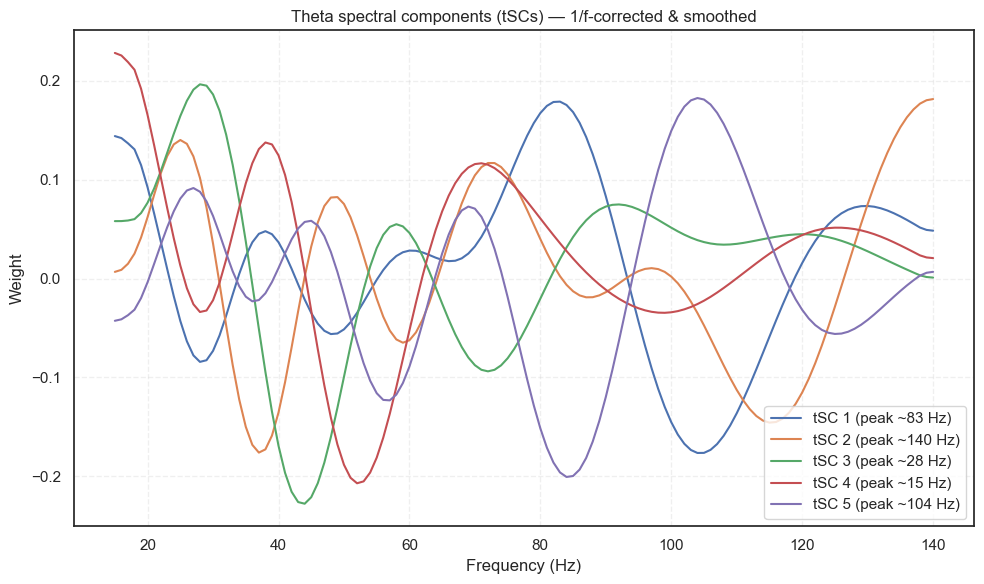

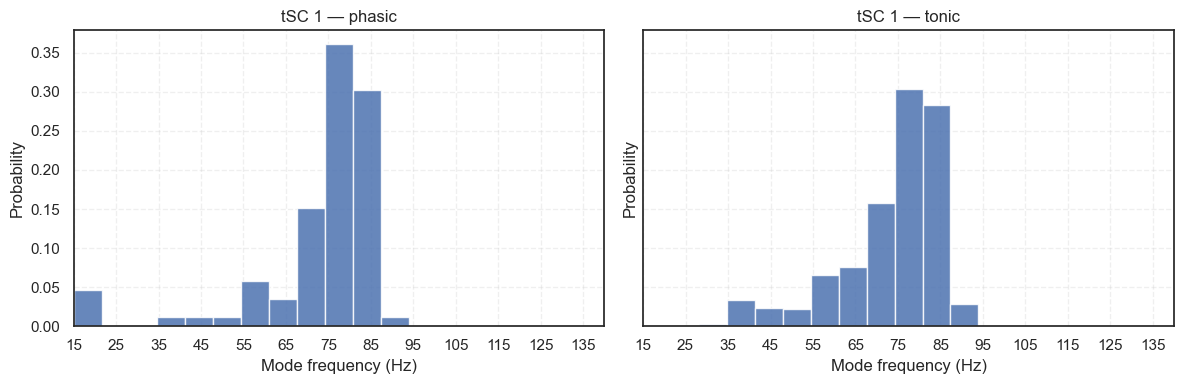

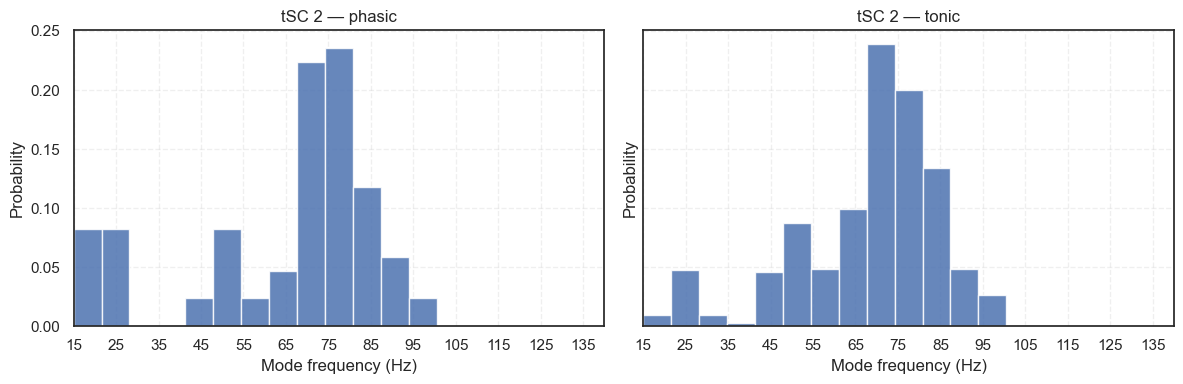

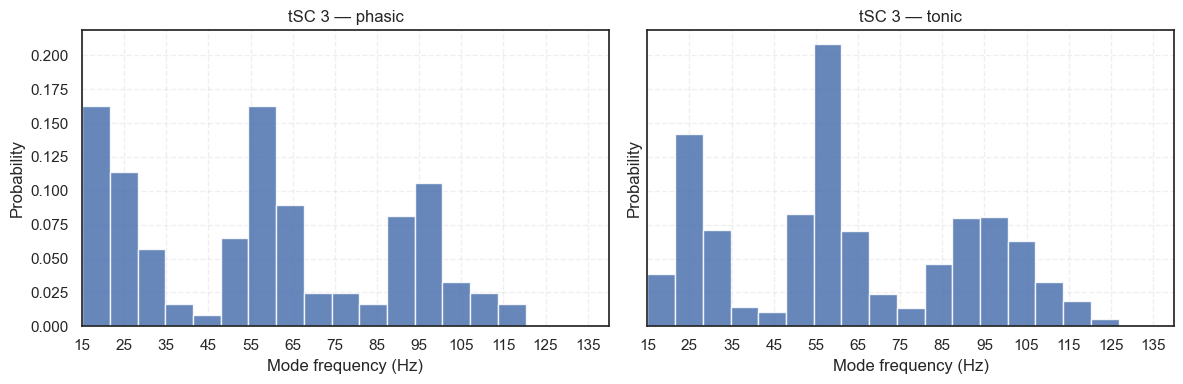

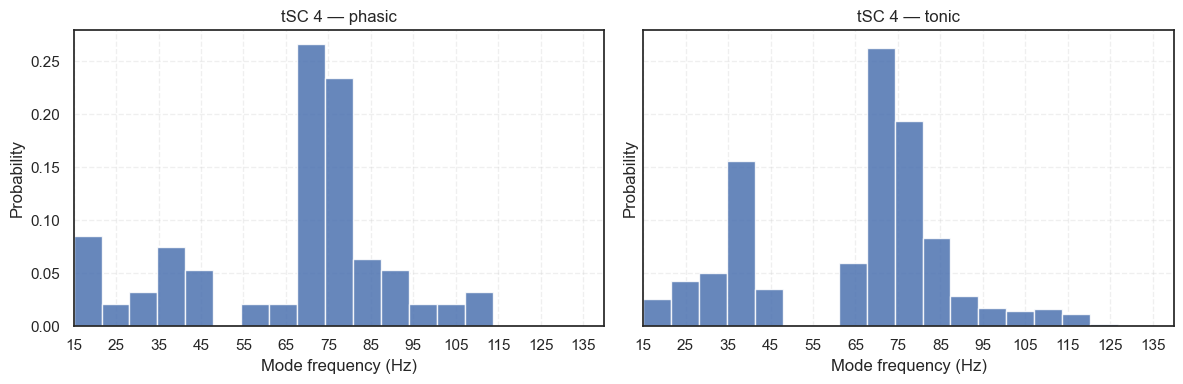

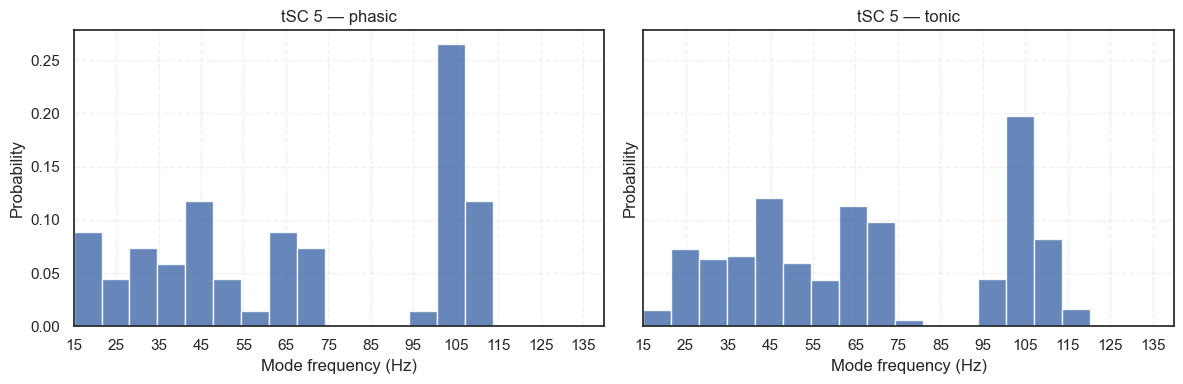

tSC thresholds: [2.24735225 1.96745922 2.22746742 2.23214668 2.02896291]


In [ ]:
# ============================================================
# Revised tSC pipeline (paper-like) for your existing notebook
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA, FastICA

# -----------------------
# Parameters you can tune
# -----------------------
frequencies     = np.arange(15, 141, 1)   # 15–140 Hz (matches your signatures)
n_ics           = 5                       # number of ICA components (tSCs)
var_target      = 0.85                    # keep PCs up to this variance
fit_floor_hz    = 20                      # fit 1/f only above this frequency
smooth_kernel   = 5                       # 5-Hz moving average over frequency
peak_fmin_hz    = 20                      # only count peaks ≥ this frequency
peak_prominence = 0.02                    # minimum local-peak prominence
use_power_filter= False                   # optionally drop lowest-power cycles
power_pct_thr   = 10                      # percentile for power filter if used

EPS = 1e-12

# -----------------------
# Helpers
# -----------------------
def _stack_sigs(sig_list, n_freqs):
    sig_list = [a for a in sig_list if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[1] == n_freqs and a.shape[0] > 0]
    return np.vstack(sig_list) if sig_list else np.empty((0, n_freqs))

def _mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m))

def _robust_thr(x):
    return np.median(x) + (2.0 / 0.6745) * _mad(x)

def _log10_safe(x):
    return np.log10(np.maximum(x, EPS))

# def _per_cycle_1overf_residuals(SIG_raw, freqs, fit_floor_hz=20):
#     """
#     Per-cycle 1/f removal: for each cycle's log-power spectrum y(f), fit y ≈ a - β*log10(f)
#     using only freqs >= fit_floor_hz (to avoid band-edge effects), then return residuals.
#     """
#     if SIG_raw.size == 0:
#         return SIG_raw

#     SIG_raw = np.asarray(SIG_raw, float)
#     SIG_raw[~np.isfinite(SIG_raw)] = EPS

#     ylog = _log10_safe(SIG_raw)                   # (n_cycles, n_freqs)

#     f = np.asarray(freqs, float)
#     mask = f >= float(fit_floor_hz)
#     x_fit = np.log10(f[mask] + 1e-9)              # (n_fit,)
#     D_fit = np.column_stack([np.ones_like(x_fit), -x_fit])    # (n_fit, 2)

#     # solve D_fit @ coef = ylog[:, mask].T  -> coef: (2, n_cycles)
#     coef, *_ = np.linalg.lstsq(D_fit, ylog[:, mask].T, rcond=None)

#     # predict across full band
#     x_full = np.log10(f + 1e-9)
#     D_full = np.column_stack([np.ones_like(x_full), -x_full]) # (n_freqs, 2)
#     yhat = (D_full @ coef).T                                  # (n_cycles, n_freqs)

#     resid = ylog - yhat
#     resid[~np.isfinite(resid)] = 0.0
#     return resid


def _per_cycle_1overf_residuals(SIG_raw, freqs, fit_floor_hz=25, fit_ceiling_hz=110):
    """
    Per-cycle 1/f removal: fit y ≈ a - β*log10(f) only on [fit_floor_hz, fit_ceiling_hz]
    to avoid absorbing >~110 Hz content. Return residuals across the full 15–140 Hz band.
    """
    if SIG_raw.size == 0:
        return SIG_raw

    SIG_raw = np.asarray(SIG_raw, float)
    SIG_raw[~np.isfinite(SIG_raw)] = EPS

    ylog = _log10_safe(SIG_raw)  # (n_cycles, n_freqs)

    f = np.asarray(freqs, float)
    mask = (f >= float(fit_floor_hz)) & (f <= float(fit_ceiling_hz))
    if mask.sum() < 3:
        # fallback to previous behavior if window is too small
        mask = f >= float(fit_floor_hz)

    x_fit = np.log10(f[mask] + 1e-9)                 # (n_fit,)
    D_fit = np.column_stack([np.ones_like(x_fit), -x_fit])  # (n_fit, 2)

    # Solve for all cycles at once (stable)
    coef, *_ = np.linalg.lstsq(D_fit, ylog[:, mask].T, rcond=None)  # (2, n_cycles)

    # Predict over full band and take residuals
    x_full = np.log10(f + 1e-9)
    D_full = np.column_stack([np.ones_like(x_full), -x_full])        # (n_freqs, 2)
    yhat = (D_full @ coef).T                                         # (n_cycles, n_freqs)

    resid = ylog - yhat
    resid[~np.isfinite(resid)] = 0.0
    return resid

def _smooth_signatures(SIG, kernel_size=5):
    if SIG.size == 0 or kernel_size <= 1:
        return SIG
    k = np.ones(int(kernel_size), dtype=float) / float(kernel_size)
    # reflect-pad along frequency axis to protect edges
    pad = kernel_size // 2
    SIG_pad = np.pad(SIG, ((0,0),(pad,pad)), mode='reflect')
    out = np.apply_along_axis(lambda v: np.convolve(v, k, mode='valid'), axis=1, arr=SIG_pad)
    return out

def _cycle_power_filter(SIG_raw, pctl=10):
    """
    Keep cycles whose broadband supra-theta power (mean log-power across 15–140 Hz)
    is above the given percentile. Filters out flat, low-SNR cycles.
    """
    if SIG_raw.size == 0:
        return np.array([], dtype=bool)
    bb = _log10_safe(SIG_raw).mean(axis=1)
    thr = np.percentile(bb, pctl)
    return bb >= thr

def _fit_pca_ica(X_all, var_target=0.85, n_ics=5, random_state=42):
    """
    PCA (whiten) -> FastICA; map IC axes back to frequency space:
    W = ICA_components @ PCA_components
    """
    # choose PC count by variance target
    pca0 = PCA(random_state=random_state, whiten=False).fit(X_all)
    evr  = pca0.explained_variance_ratio_
    n_pcs = int(np.searchsorted(np.cumsum(evr), var_target) + 1)
    n_pcs = max(1, min(n_pcs, X_all.shape[1]))

    pca = PCA(n_components=n_pcs, random_state=random_state, whiten=True)
    Z   = pca.fit_transform(X_all)                           # (n_cycles, n_pcs)
    ica = FastICA(n_components=n_ics, random_state=random_state,
                  whiten="unit-variance", max_iter=1000)
    S   = ica.fit_transform(Z)                               # (n_cycles, n_ics)
    W   = ica.components_.dot(pca.components_)               # (n_ics, n_freqs)

    # orient sign so mean projection on ALL cycles is positive
    strengths_all = X_all.dot(W.T)
    sgn = np.sign(strengths_all.mean(axis=0, keepdims=True)); sgn[sgn == 0] = 1
    W *= sgn.T
    strengths_all *= sgn
    return W, pca, ica, strengths_all

def _mode_from_spectrum_row(v, freqs, fmin=25, prominence=0.02, default=np.nan):
    """
    Pick a local maximum with minimum frequency and prominence.
    v should be 1/f-corrected (+ smoothed).
    """
    f = np.asarray(freqs, float)
    mask = f >= float(fmin)
    if mask.sum() < 3:
        return default
    vv = v[mask]
    ff = f[mask]
    pk, props = find_peaks(vv, prominence=prominence)
    if pk.size == 0:
        return default
    j = np.argmax(props["prominences"])
    return float(ff[pk[j]])

def _modes_from_signatures(SIG_proc, freqs, fmin=25, prominence=0.02):
    if SIG_proc.size == 0:
        return np.array([], dtype=float)
    out = np.array([_mode_from_spectrum_row(SIG_proc[i], freqs, fmin=fmin, prominence=prominence)
                    for i in range(SIG_proc.shape[0])], dtype=float)
    return out

# -----------------------------------
# 1) Stack PHASIC/TONIC signatures
# (your upstream code produced phasic_sigs & tonic_sigs)
# -----------------------------------
X_phasic_raw = _stack_sigs(phasic_sigs, len(frequencies))
X_tonic_raw  = _stack_sigs(tonic_sigs,  len(frequencies))
X_all_raw    = np.vstack([X_phasic_raw, X_tonic_raw]) if (X_phasic_raw.size or X_tonic_raw.size) else np.empty((0, len(frequencies)))

print("Signatures raw shapes:", X_phasic_raw.shape, X_tonic_raw.shape, X_all_raw.shape)

# optional sanity with trials_df
nP = int((trials_df['cycle_type'].str.lower() == 'phasic').sum())
nT = int((trials_df['cycle_type'].str.lower()  == 'tonic').sum())
assert X_phasic_raw.shape[0] == nP, f"phasic mismatch {X_phasic_raw.shape[0]} vs {nP}"
assert X_tonic_raw.shape[0]  == nT, f"tonic  mismatch {X_tonic_raw.shape[0]} vs {nT}"

# -----------------------------------
# 2) Features for PCA/ICA:
#    per-cycle 1/f removal (fit ≥fit_floor_hz) + smoothing
# -----------------------------------
# 2) Features for PCA/ICA:
SIG_corr_all = _per_cycle_1overf_residuals(X_all_raw,  frequencies, fit_floor_hz=25, fit_ceiling_hz=110)
SIG_corr_all = _smooth_signatures(SIG_corr_all, kernel_size=smooth_kernel)

# 4) Project PHASIC and TONIC with the SAME preprocessing
SIG_corr_P = _per_cycle_1overf_residuals(X_phasic_raw, frequencies, fit_floor_hz=25, fit_ceiling_hz=110)
SIG_corr_T = _per_cycle_1overf_residuals(X_tonic_raw,  frequencies, fit_floor_hz=25, fit_ceiling_hz=110)
SIG_corr_P = _smooth_signatures(SIG_corr_P, kernel_size=smooth_kernel)
SIG_corr_T = _smooth_signatures(SIG_corr_T, kernel_size=smooth_kernel)

# (optional) drop the lowest-power cycles BEFORE PCA/ICA (helps avoid edge argmaxes)
if use_power_filter:
    keep_mask_all = _cycle_power_filter(X_all_raw, pctl=power_pct_thr)
    X_all = SIG_corr_all[keep_mask_all]
else:
    X_all = SIG_corr_all

# -----------------------------------
# 3) PCA→ICA once on ALL cycles
# -----------------------------------
W, pca_model, ica_model, S_all = _fit_pca_ica(X_all, var_target=var_target, n_ics=n_ics, random_state=123)
print("tSCs learned:", W.shape)

# -----------------------------------
# 4) Project PHASIC and TONIC with the SAME preprocessing
# -----------------------------------
SIG_corr_P = _per_cycle_1overf_residuals(X_phasic_raw, frequencies, fit_floor_hz=fit_floor_hz)
SIG_corr_T = _per_cycle_1overf_residuals(X_tonic_raw,  frequencies, fit_floor_hz=fit_floor_hz)
SIG_corr_P = _smooth_signatures(SIG_corr_P, kernel_size=smooth_kernel)
SIG_corr_T = _smooth_signatures(SIG_corr_T, kernel_size=smooth_kernel)

S_phasic = SIG_corr_P.dot(W.T)
S_tonic  = SIG_corr_T.dot(W.T)

# -----------------------------------
# 5) Robust thresholds on ALL strengths, mark "strong"
# -----------------------------------
thr = np.array([_robust_thr(S_all[:, j]) for j in range(W.shape[0])])
phasic_strong = (S_phasic >= thr.reshape(1, -1))
tonic_strong  = (S_tonic  >= thr.reshape(1, -1))

# -----------------------------------
# 6) Mode frequencies from processed signatures (1/f-corrected + smoothed)
#    Using local-peak rule with fmin & prominence (avoids 15–20 Hz pile-up)
# -----------------------------------
modes_phasic = _modes_from_signatures(SIG_corr_P, frequencies, fmin=peak_fmin_hz, prominence=peak_prominence)
modes_tonic  = _modes_from_signatures(SIG_corr_T, frequencies, fmin=peak_fmin_hz, prominence=peak_prominence)

# attach to trials_df (phasic rows first, then tonic rows)
trials_df = trials_df.copy()
maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values

trials_df.loc[maskP, 'mode_freqs_sig'] = modes_phasic
trials_df.loc[maskT, 'mode_freqs_sig'] = modes_tonic
for k in range(W.shape[0]):
    trials_df.loc[maskP, f"tSC{k+1}_strong"] = phasic_strong[:, k]
    trials_df.loc[maskT, f"tSC{k+1}_strong"] = tonic_strong[:,  k]

# -----------------------------------
# 7) Plots: tSC shapes and per-tSC mode-frequency distributions
# -----------------------------------
plt.figure(figsize=(10, 6))
for i in range(W.shape[0]):
    w = W[i]
    pk = np.argmax(w)
    plt.plot(frequencies, w, label=f"tSC {i+1} (peak ~{frequencies[pk]} Hz)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Weight"); plt.title("Theta spectral components (tSCs) — 1/f-corrected & smoothed")
plt.grid(alpha=0.3, ls='--'); plt.legend(); plt.tight_layout(); plt.show()

bins   = np.linspace(15, 140, 20)
xticks = np.arange(15, 141, 10)

for k in range(W.shape[0]):
    col = f"tSC{k+1}_strong"
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for j, ctype in enumerate(['phasic', 'tonic']):
        ax = axes[j]
        sub = trials_df[(trials_df['cycle_type'].str.lower()==ctype) & (trials_df[col]==True)]
        vals = sub['mode_freqs_sig'].to_numpy(dtype=float)
        vals = vals[np.isfinite(vals) & (vals >= 15) & (vals <= 140)]
        if vals.size:
            ax.hist(vals, bins=bins, weights=np.ones_like(vals)/vals.size, alpha=0.85)
        ax.set(title=f"tSC {k+1} — {ctype}", xlabel="Mode frequency (Hz)", ylabel="Probability",
               xlim=(15, 140))
        ax.set_xticks(xticks); ax.grid(alpha=0.3, ls='--')
    plt.tight_layout(); plt.show()

print("tSC thresholds:", thr)

Raw signatures: (2899, 126) (58272, 126) (61171, 126)


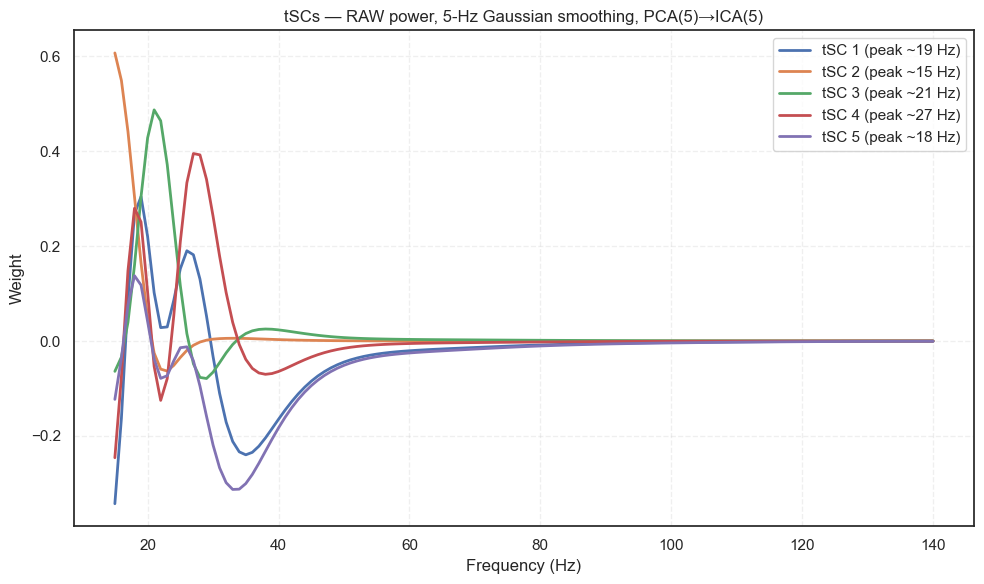

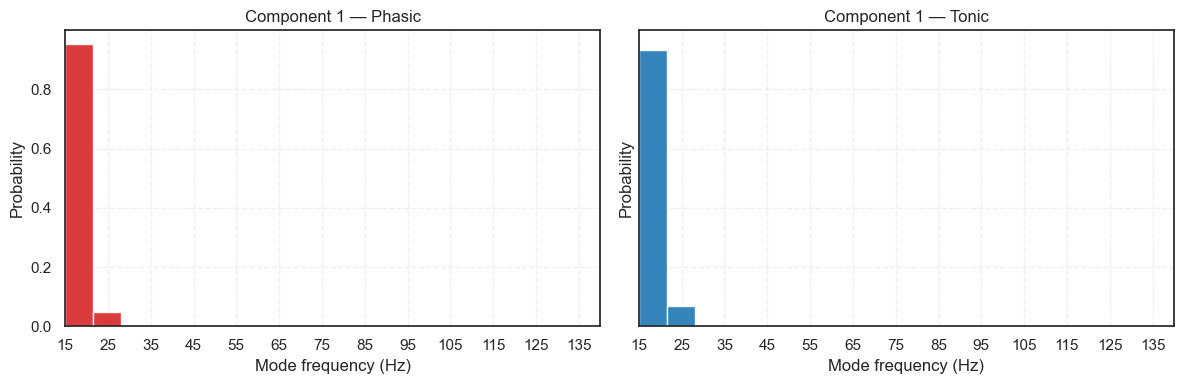

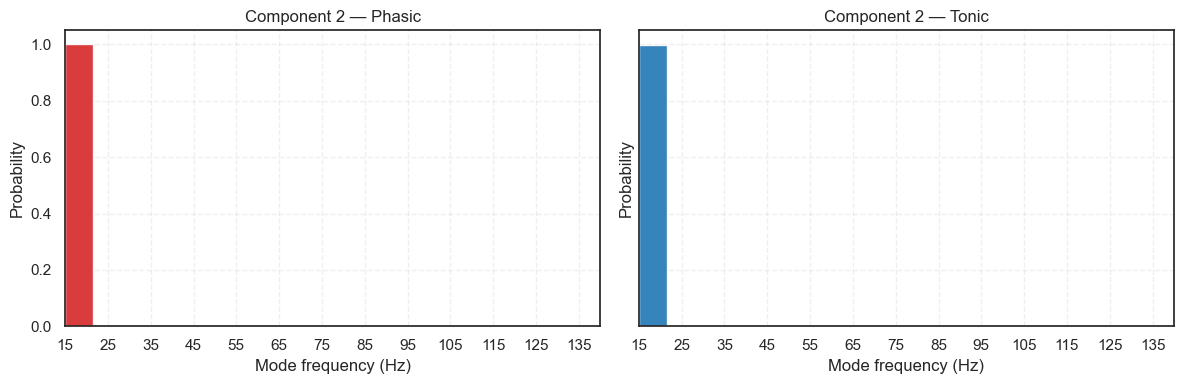

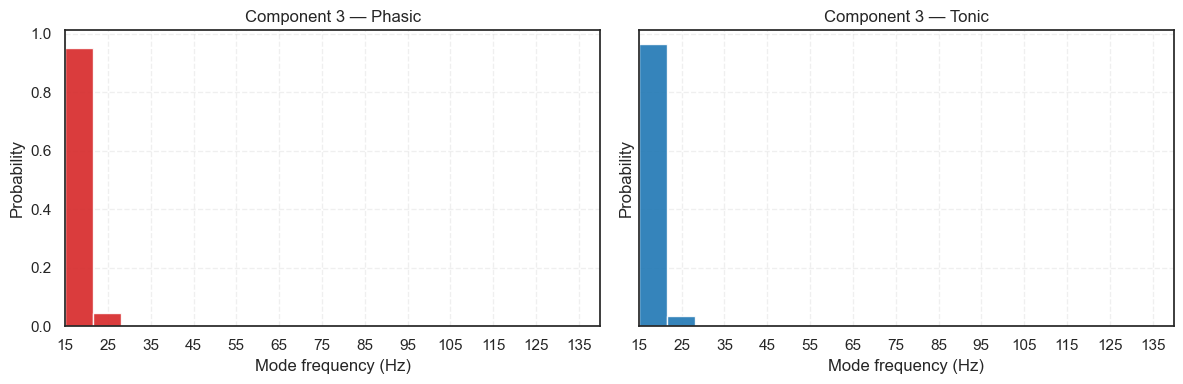

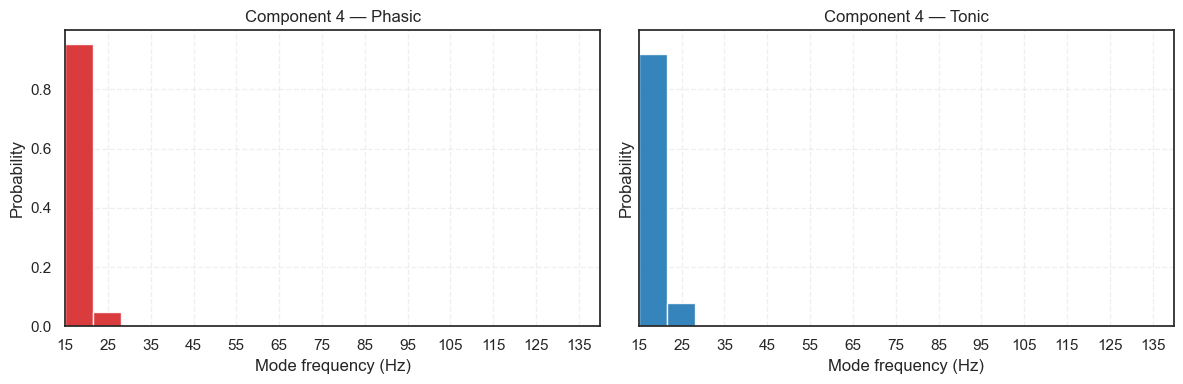

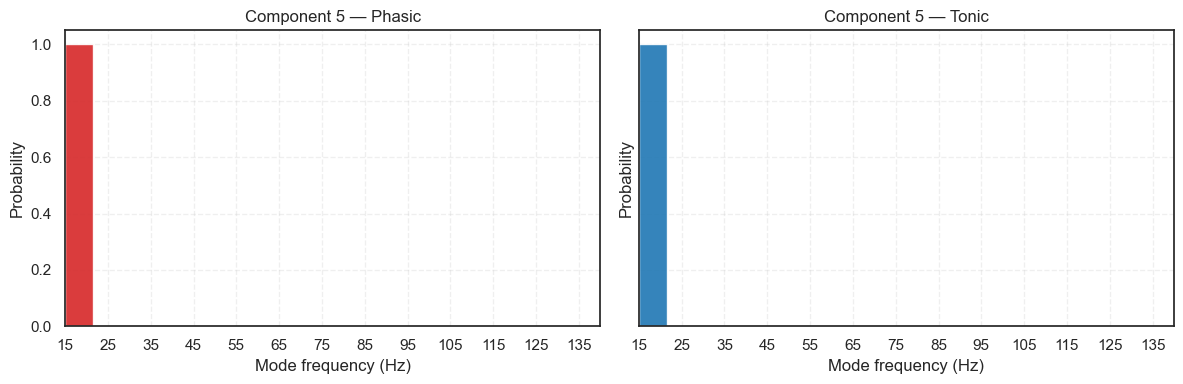

MAD thresholds per tSC: [1.15513567e+08 3.87880818e+08 2.73996878e+08 1.15738502e+08
 8.41028611e+07]


In [99]:
# ============================================================
# tSC extraction — faithful to Lopes-dos-Santos et al.
# EXACT operations:
#   • use cycle signatures = Morlet POWER averaged within each theta cycle (your existing code already does this)
#   • NO log transform, NO per-cycle normalization, NO 1/f regression
#   • smooth each cycle’s spectrum with a 5-Hz Gaussian across frequency
#   • PCA (fixed 5 PCs), then FastICA (5 ICs) on those PCs
#   • tSCs = ICA components mapped back to frequency space
#   • Strength of a tSC in a cycle = projection of the (centered) smoothed signature onto that tSC
#   • “Strong cycle” = MAD threshold on strengths (per component)
#   • Mode frequency of a cycle = argmax of its *smoothed* signature (no log)
#
# Assumes you already ran your extraction and have:
#   phasic_sigs, tonic_sigs  -> lists of (n_cycles x n_freqs) RAW Morlet POWER (15..140 Hz)
#   trials_df                -> per-cycle metadata incl. 'cycle_type' ('phasic'/'tonic')
#   frequencies              -> np.arange(15,141,1)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

# --- Gaussian smoothing across frequency (FWHM 5 Hz) ---
try:
    from scipy.ndimage import gaussian_filter1d as _gauss1d
except Exception:
    _gauss1d = None

def _gauss_smooth_rows(SIG, fwhm_hz=5.0, df_hz=1.0):
    """Gaussian smooth each row along frequency axis."""
    if SIG.size == 0 or fwhm_hz <= 0:
        return SIG
    sigma_bins = max(fwhm_hz / 2.355 / max(df_hz, 1e-9), 1e-9)
    if _gauss1d is not None:
        return _gauss1d(SIG, sigma=sigma_bins, axis=1, mode='reflect')
    # manual discrete kernel if SciPy unavailable
    half = int(np.ceil(4*sigma_bins))
    x = np.arange(-half, half+1)
    k = np.exp(-(x**2)/(2*sigma_bins**2)); k /= k.sum()
    SIG_pad = np.pad(SIG, ((0,0),(half,half)), mode='reflect')
    return np.apply_along_axis(lambda v: np.convolve(v, k, mode='valid'), axis=1, arr=SIG_pad)

def _stack_sigs(sig_list, n_freqs):
    sig_list = [a for a in sig_list if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[1] == n_freqs and a.shape[0] > 0]
    return np.vstack(sig_list) if sig_list else np.empty((0, n_freqs))

def _mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m))

def _robust_thr(x):
    return np.median(x) + (2.0/0.6745)*_mad(x)

# ---------------------------
# 1) Stack raw (power) signatures
# ---------------------------
nF = len(frequencies)
X_phasic_raw = _stack_sigs(phasic_sigs, nF)
X_tonic_raw  = _stack_sigs(tonic_sigs,  nF)
X_all_raw    = np.vstack([X_phasic_raw, X_tonic_raw]) if (X_phasic_raw.size or X_tonic_raw.size) else np.empty((0, nF))
print("Raw signatures:", X_phasic_raw.shape, X_tonic_raw.shape, X_all_raw.shape)

# sanity with trials_df ordering (phasic rows first, then tonic)
nP = int((trials_df['cycle_type'].str.lower() == 'phasic').sum())
nT = int((trials_df['cycle_type'].str.lower()  == 'tonic').sum())
assert X_phasic_raw.shape[0] == nP and X_tonic_raw.shape[0] == nT, "Cycle counts don’t match trials_df."

# ---------------------------
# 2) Smooth across frequency (5 Hz Gaussian) — NO log, NO normalization
# ---------------------------
df_hz = float(np.median(np.diff(frequencies)))
X_all_sm     = _gauss_smooth_rows(X_all_raw,     fwhm_hz=5.0, df_hz=df_hz)
X_phasic_sm  = _gauss_smooth_rows(X_phasic_raw,  fwhm_hz=5.0, df_hz=df_hz)
X_tonic_sm   = _gauss_smooth_rows(X_tonic_raw,   fwhm_hz=5.0, df_hz=df_hz)

# ---------------------------
# 3) PCA (fixed 5 PCs) -> ICA (5 ICs) on ALL cycles
#     sklearn PCA centers features internally; that matches the paper.
# ---------------------------
n_pcs = 5
n_ics = 5

pca = PCA(n_components=n_pcs, random_state=42, whiten=True)
Z_all = pca.fit_transform(X_all_sm)                 # (Ncycles, 5)

ica = FastICA(n_components=n_ics, random_state=42, whiten="unit-variance", max_iter=1000)
S_all = ica.fit_transform(Z_all)                    # (Ncycles, 5)

# Map ICs back to frequency space (tSCs)
W = ica.components_.dot(pca.components_)            # (5, n_freqs)

# Orient each tSC so the mean projection is positive
strengths_all = (X_all_sm - pca.mean_) @ W.T        # project in original feature space
sgn = np.sign(strengths_all.mean(axis=0, keepdims=True)); sgn[sgn==0] = 1
W *= sgn.T
strengths_all *= sgn

# ---------------------------
# 4) Project PHASIC / TONIC using same centering as PCA
# ---------------------------
X_phasic_c = X_phasic_sm - pca.mean_
X_tonic_c  = X_tonic_sm  - pca.mean_

S_phasic = X_phasic_c @ W.T                         # (nP, 5) strengths per cycle
S_tonic  = X_tonic_c  @ W.T                         # (nT, 5)

# ---------------------------
# 5) Robust thresholds (MAD) to mark "strong" cycles per tSC
# ---------------------------
thr = np.array([_robust_thr(strengths_all[:, j]) for j in range(W.shape[0])])
phasic_strong = S_phasic >= thr.reshape(1, -1)
tonic_strong  = S_tonic  >= thr.reshape(1, -1)

# ---------------------------
# 6) Mode frequency per cycle = argmax of the *smoothed raw power* spectrum
# ---------------------------
def _mode_from_row(v, freqs, fmin=15):
    f = np.asarray(freqs, float)
    m = f >= float(fmin)
    if not np.any(m): return np.nan
    vv, ff = v[m], f[m]
    return float(ff[int(np.argmax(vv))])

modes_phasic = np.array([_mode_from_row(row, frequencies, fmin=15) for row in X_phasic_sm], dtype=float)
modes_tonic  = np.array([_mode_from_row(row, frequencies, fmin=15) for row in X_tonic_sm],  dtype=float)

# ---------------------------
# 7) Attach results to trials_df
# ---------------------------
trials_df = trials_df.copy()
maskP = trials_df['cycle_type'].str.lower().eq('phasic').values
maskT = trials_df['cycle_type'].str.lower().eq('tonic').values

trials_df.loc[maskP, 'mode_freqs_sig'] = modes_phasic
trials_df.loc[maskT, 'mode_freqs_sig'] = modes_tonic
for k in range(W.shape[0]):
    trials_df.loc[maskP, f"tSC{k+1}_strong"] = phasic_strong[:, k]
    trials_df.loc[maskT, f"tSC{k+1}_strong"] = tonic_strong[:,  k]

# ---------------------------
# 8) Plots (tSCs and mode-frequency histograms)
# ---------------------------
plt.figure(figsize=(10, 6))
for i in range(W.shape[0]):
    w = W[i]
    pk = np.argmax(w)
    plt.plot(frequencies, w, lw=2, label=f"tSC {i+1} (peak ~{frequencies[pk]} Hz)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Weight")
plt.title("tSCs — RAW power, 5-Hz Gaussian smoothing, PCA(5)→ICA(5)")
plt.grid(alpha=0.3, ls='--'); plt.legend(); plt.tight_layout(); plt.show()

bins   = np.linspace(15, 140, 20)
xticks = np.arange(15, 141, 10)

for k in range(W.shape[0]):
    col = f"tSC{k+1}_strong"
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for j, ctype in enumerate(['phasic', 'tonic']):
        ax = axes[j]
        sub = trials_df[trials_df['cycle_type'].str.lower().eq(ctype)]
        # show only strong cycles (paper’s convention in figures)
        sub = sub[sub[col] == True]
        vals = sub['mode_freqs_sig'].to_numpy(dtype=float)
        vals = vals[np.isfinite(vals) & (vals >= 15) & (vals <= 140)]
        if vals.size:
            ax.hist(vals, bins=bins, weights=np.ones_like(vals)/vals.size, alpha=0.9,
                    color=('tab:red' if ctype=='phasic' else 'tab:blue'))
        ax.set(title=f"Component {k+1} — {ctype.capitalize()}",
               xlabel="Mode frequency (Hz)", ylabel="Probability", xlim=(15, 140))
        ax.set_xticks(xticks); ax.grid(alpha=0.3, ls='--')
    plt.tight_layout(); plt.show()

print("MAD thresholds per tSC:", thr)

# old

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

# --- 1. Define Constants & Load Your Data ---
# These parameters must match what you used in your data generation pipeline
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

# --- UNCOMMENT YOUR LOADING CODE HERE ---
# save_folder = "Os_Basic_Dataset_FPPs"
# phasic_filename = os.path.join(save_folder, "Os_Basic_Dataset_arrays_of_phasic_fpps.npy")
# tonic_filename = os.path.join(save_folder, "Os_Basic_Dataset_arrays_of_tonic_fpps.npy")

# print("Loading the saved arrays...")
# phasic_fpps = np.load(phasic_filename, allow_pickle=True)
# tonic_fpps = np.load(tonic_filename, allow_pickle=True)
# print("Successfully loaded arrays.")
# ----------------------------------------

# --- 2. Data Flattening Function (Handles the 3D Array Structure) ---
def flatten_fpp_data_final(fpps_by_rat):
    """
    Correctly flattens the Array[List[3D Array]] structure into a single
    flat list of 2D FPP arrays.
    """
    all_2d_fpps = []
    # Level 1: Iterate over each rat
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list):
            continue
        # Level 2: Iterate over each interval's 3D array
        for interval_3d_array in rat_data_list:
            # Check if it's a 3D numpy array with at least one cycle
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] > 0:
                # Level 3: Iterate through each cycle (the first dimension)
                # and append the 2D FPP to our master list.
                for i in range(interval_3d_array.shape[0]):
                    all_2d_fpps.append(interval_3d_array[i, :, :])
    return all_2d_fpps

print("--- Flattening Data ---")
flattened_phasic = flatten_fpp_data_final(all_phasic_fpps)
flattened_tonic = flatten_fpp_data_final(all_tonic_fpps)

print(f"Total number of Phasic FPPs found: {len(flattened_phasic)}")
print(f"Total number of Tonic FPPs found: {len(flattened_tonic)}")
print("-" * 20)

--- Flattening Data ---
Total number of Phasic FPPs found: 2899
Total number of Tonic FPPs found: 58272
--------------------


In [38]:
# --- 3. Data Processing Function ---
def process_fpps_for_plotting(fpp_list, description=""):
    """
    Takes a flat list of 2D FPPs, filters them for consistent shapes,
    and computes the necessary averages for plotting.
    Returns a dictionary with processed data, or None if no valid data.
    """
    if not fpp_list:
        print(f"No FPPs to process for {description}.")
        return None

    # Filter for arrays with the most common, valid shape to avoid errors
    shape_counts = Counter(arr.shape for arr in fpp_list if isinstance(arr, np.ndarray))
    if not shape_counts:
        print(f"No valid NumPy arrays found for {description}.")
        return None
        
    most_common_shape = shape_counts.most_common(1)[0][0]
    valid_fpps = [arr for arr in fpp_list if hasattr(arr, 'shape') and arr.shape == most_common_shape]
    
    print(f"Processing '{description}':")
    print(f"  - Found {len(valid_fpps)} valid FPPs with shape {most_common_shape}.")
    if len(valid_fpps) < len(fpp_list):
        print(f"  - Ignored {len(fpp_list) - len(valid_fpps)} entries with inconsistent shapes or types.")
    
    if not valid_fpps:
        return None

    # Stack the valid FPPs into a single 3D array
    stacked_fpps = np.stack(valid_fpps, axis=0)

    # --- Calculations for Plots ---
    # 1. For the averaged spectrogram
    avg_fpp = np.mean(stacked_fpps, axis=0)

    # 2. For the spectral signature
    all_signatures = np.mean(stacked_fpps, axis=2) # Average over phase angles
    mean_signature = np.mean(all_signatures, axis=0)
    std_signature = np.std(all_signatures, axis=0)

    # Return all processed data in a dictionary
    return {
        'avg_fpp': avg_fpp,
        'mean_signature': mean_signature,
        'std_signature': std_signature,
        'n_valid': len(valid_fpps),
        'shape': most_common_shape
    }

print("\n--- Processing Flattened Data ---")
phasic_processed = process_fpps_for_plotting(flattened_phasic, "Phasic REM")
tonic_processed = process_fpps_for_plotting(flattened_tonic, "Tonic REM")
print("-" * 20)



--- Processing Flattened Data ---
Processing 'Phasic REM':
  - Found 2899 valid FPPs with shape (126, 19).
Processing 'Tonic REM':
  - Found 58272 valid FPPs with shape (126, 19).
--------------------


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
from collections import defaultdict, Counter
from sklearn.decomposition import PCA, FastICA

# New imports for interactive plotting
import plotly.graph_objects as go
import networkx as nx

# ===================================================================
# ---              UNCHANGED FUNCTIONS (Parts 1-3)                ---
# ===================================================================
def extract_sss_by_episode(fpps_by_rat):
    episodes_sss_list = []
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list): continue
        for interval_3d_array in rat_data_list:
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] > 1:
                current_episode_sss = []
                for i in range(interval_3d_array.shape[0]):
                    fpp_2d = interval_3d_array[i, :, :]
                    fpp_abs = np.abs(fpp_2d)
                    norm_sum = np.sum(fpp_abs)
                    normalized_fpp = fpp_abs / norm_sum if norm_sum > 1e-9 else fpp_abs
                    signature_1d = np.sum(normalized_fpp, axis=1)
                    signature_smoothed = np.convolve(signature_1d, np.ones(5)/5, mode='same')
                    sig_min, sig_max = np.min(signature_smoothed), np.max(signature_smoothed)
                    if (sig_max - sig_min) > 1e-9:
                       signature_final = (signature_smoothed - sig_min) / (sig_max - sig_min)
                    else:
                        signature_final = np.zeros_like(signature_1d)
                    current_episode_sss.append(signature_final)
                episodes_sss_list.append(np.array(current_episode_sss))
    return episodes_sss_list

def train_global_ica_model(all_sss_data, n_components):
    print(f"Training global PCA/ICA model with {n_components} components...")
    if all_sss_data.shape[0] < n_components: return None, None
    pca = PCA(n_components=n_components, random_state=42)
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000, tol=0.001)
    pca_result = pca.fit_transform(all_sss_data)
    ica.fit(pca_result)
    print("Model training complete.")
    return pca, ica

def plot_ica_components(pca_model, ica_model, frequencies, title_suffix, save_path):
    tSCs_weights_original = np.dot(ica_model.components_, pca_model.components_)
    n_components = ica_model.components_.shape[0]
    colors = plt.cm.viridis(np.linspace(0, 1, n_components))
    plt.figure(figsize=(12, 7))
    for i in range(n_components):
        weights = tSCs_weights_original[i, :]
        peak_idx = np.argmax(np.abs(weights))
        peak_freq = frequencies[peak_idx]
        plt.plot(frequencies, weights, color=colors[i], label=f'tSC {i+1} (Peak: {peak_freq:.1f} Hz)')
        plt.scatter(peak_freq, weights[peak_idx], color=colors[i], edgecolor='k', s=50, zorder=5)
    plt.xlabel('Frequency (Hz)', fontsize=14); plt.ylabel('Weight', fontsize=14); plt.title(f'Theta Spectral Components (tSCs) - {title_suffix}', fontsize=16)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig(save_path, format='svg'); plt.show()

def get_component_sequences(sss_by_episode, pca_model, ica_model):
    all_sequences = []
    for episode_sss in sss_by_episode:
        episode_pca = pca_model.transform(episode_sss)
        episode_tSCs = ica_model.transform(episode_pca)
        component_sequence = np.argmax(np.abs(episode_tSCs), axis=1)
        all_sequences.append(component_sequence)
    return all_sequences

def calculate_transition_matrix(component_sequences):
    """
    Calculates a transition count matrix from a list of component sequences.
    """
    if not any(len(seq) > 0 for seq in component_sequences):
        return np.array([])
        
    max_id = 0
    for seq in component_sequences:
        if len(seq) > 0:
            max_id = max(max_id, np.max(seq))
    n_comp = max_id + 1
    
    transition_matrix = np.zeros((n_comp, n_comp), dtype=int)

    for seq in component_sequences:
        for i in range(len(seq) - 1):
            # --- CORRECTED LOGIC ---
            from_comp = seq[i]
            to_comp = seq[i+1]
            # -----------------------
            transition_matrix[from_comp, to_comp] += 1
            
    return transition_matrix


# def plot_transition_matrix(transition_counts, title, save_path):
#     if transition_counts.size == 0: return
#     row_sums = transition_counts.sum(axis=1, keepdims=True)
#     with np.errstate(divide='ignore', invalid='ignore'): prob_matrix = np.nan_to_num(transition_counts / row_sums)
#     prob_matrix_viz = prob_matrix.copy()
#     np.fill_diagonal(prob_matrix_viz, 0)
#     plt.figure(figsize=(10, 8)); ax = sns.heatmap(prob_matrix_viz, annot=prob_matrix, fmt=".2f", cmap="hot", linewidths=.5, cbar_kws={'label': 'Transition Probability'})
#     labels = [f'tSC {i+1}' for i in range(prob_matrix.shape[0])]
#     ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels, rotation=0)
#     ax.set_xlabel("To Component", fontsize=14); ax.set_ylabel("From Component", fontsize=14); ax.set_title(title, fontsize=16)
#     plt.tight_layout(); plt.savefig(save_path, format='svg'); plt.show()

def plot_transition_matrix(transition_counts, title, save_path):
    if transition_counts.size == 0:
        return

    row_sums = transition_counts.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_matrix = np.nan_to_num(transition_counts / row_sums)

    prob_matrix_viz = prob_matrix.copy()
    np.fill_diagonal(prob_matrix_viz, 0)

    # ------- changed block starts here -------
    cmap = plt.cm.get_cmap('bwr')          # blue-white-red
    ax = sns.heatmap(
        prob_matrix_viz,
        annot=prob_matrix,
        fmt=".2f",
        cmap=cmap,
        vmin=0, vmax=1,                    # full probability range
        center=0.5,                        # make 0.5 the neutral (white) midpoint
        linewidths=.5,
        cbar_kws={
            'label': 'Transition Probability',
            'ticks': [0, 0.25, 0.5, 0.75, 1]
        }
    )
    # ------- changed block ends here -------

    labels = [f'tSC {i+1}' for i in range(prob_matrix.shape[0])]
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_xlabel("To Component", fontsize=14)
    ax.set_ylabel("From Component", fontsize=14)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, format='svg')
    plt.show()

def plot_interactive_transition_graph(prob_matrix, node_counts, title, prob_threshold=0.05):
    n_components = prob_matrix.shape[0]
    G = nx.DiGraph()

    min_node_size, max_node_size = 15, 50
    total_cycles = np.sum(node_counts)
    if total_cycles == 0: total_cycles = 1
    node_sizes = min_node_size + (node_counts / total_cycles) * (max_node_size - min_node_size)
    colors = plt.cm.viridis(np.linspace(0, 1, n_components))

    for i in range(n_components):
        G.add_node(i, size=node_sizes[i], label=f"tSC {i+1}", color=mcolors.to_hex(colors[i]), hover_text=f"tSC {i+1}<br>Cycle Count: {node_counts[i]}")

    for i in range(n_components):
        for j in range(n_components):
            prob = prob_matrix[i, j]
            if prob > prob_threshold and i != j:
                G.add_edge(i, j, weight=prob, label=f"{prob:.2f}")

    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]; x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None]); edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
    node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x); node_y.append(y); node_text.append(G.nodes[node]['hover_text'])
        node_size.append(G.nodes[node]['size']); node_color.append(G.nodes[node]['color'])

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=[G.nodes[node]['label'] for node in G.nodes()], textposition="top center",
        hoverinfo='text', hovertext=node_text, marker=dict(showscale=False, colorscale='Viridis', reversescale=True, color=node_color, size=node_size, line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title=f'<br><b>{title}</b>', titlefont_size=16, showlegend=False, hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40), annotations=[dict(text=f"Edge arrows show transition probability > {prob_threshold}", showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002)],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False), yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]; x1, y1 = pos[edge[1]]
        fig.add_annotation(ax=x0, ay=y0, axref='x', ayref='y', x=x0*0.2 + x1*0.8, y=y0*0.2 + y1*0.8, xref='x', yref='y', showarrow=True, arrowhead=2, arrowsize=2, arrowwidth=1)
        fig.add_annotation(x=(x0+x1)/2, y=(y0+y1)/2, text=edge[2]['label'], showarrow=False, font=dict(size=10, color="black"))
    return fig


--- Step 1: Processing data ---

--- Step 2: Training global model ---
Training global PCA/ICA model with 5 components...
Model training complete.

--- Step 3: Visualizing global components ---


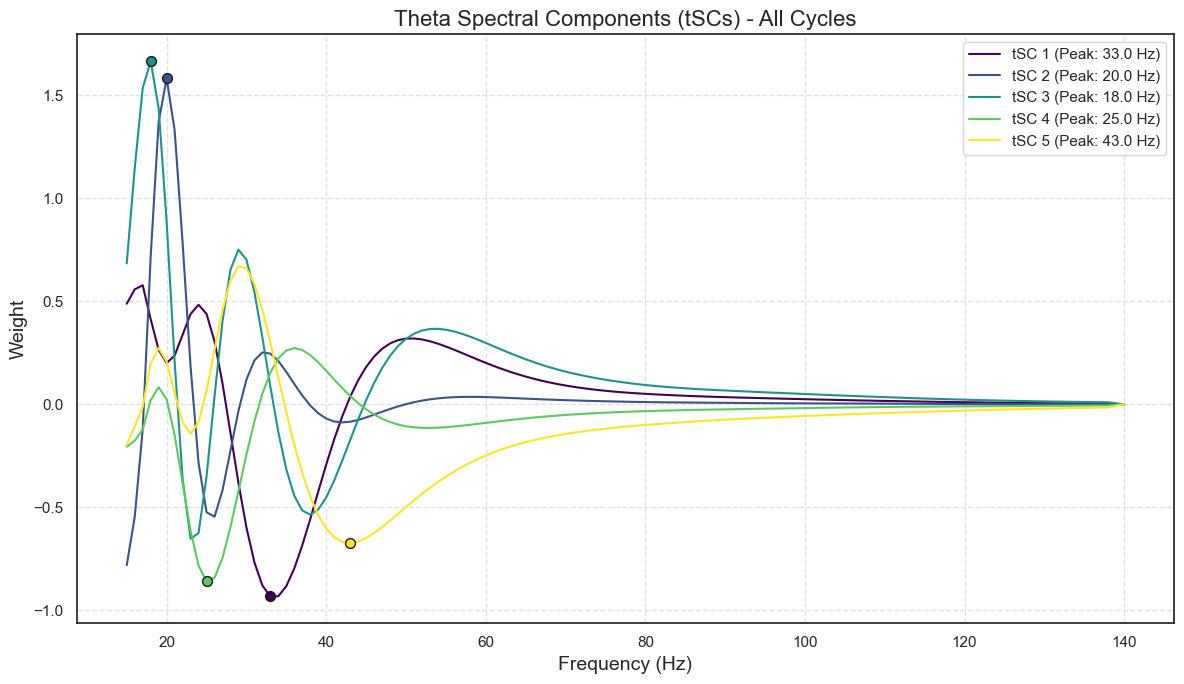


--- Step 4: Assigning components and calculating transitions ---

Component Composition:
  Component 1: 369 phasic cycles, 10596 tonic cycles
  Component 2: 783 phasic cycles, 15074 tonic cycles
  Component 3: 469 phasic cycles, 9396 tonic cycles
  Component 4: 835 phasic cycles, 13832 tonic cycles
  Component 5: 443 phasic cycles, 9373 tonic cycles


In [47]:
frequencies = np.arange(15, 141, 1)

print("--- Step 1: Processing data ---")
phasic_sss_by_episode = extract_sss_by_episode(all_phasic_fpps)
tonic_sss_by_episode = extract_sss_by_episode(all_tonic_fpps)
combined_all_sss = np.concatenate(phasic_sss_by_episode + tonic_sss_by_episode, axis=0)

print("\n--- Step 2: Training global model ---")
n_components_pca = 5
pca_model, ica_model = train_global_ica_model(combined_all_sss, n_components_pca)
if ica_model is None: exit()

print("\n--- Step 3: Visualizing global components ---")
plot_ica_components(pca_model, ica_model, frequencies, "All Cycles", "spectral_components_combined.svg")

print("\n--- Step 4: Assigning components and calculating transitions ---")
phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
tonic_sequences = get_component_sequences(tonic_sss_by_episode, pca_model, ica_model)

print("\nComponent Composition:")
all_phasic_comps = np.concatenate(phasic_sequences) if phasic_sequences else np.array([])
all_tonic_comps = np.concatenate(tonic_sequences) if tonic_sequences else np.array([])
phasic_counts_counter = Counter(all_phasic_comps); tonic_counts_counter = Counter(all_tonic_comps)
phasic_node_counts = np.array([phasic_counts_counter.get(i, 0) for i in range(n_components_pca)])
tonic_node_counts = np.array([tonic_counts_counter.get(i, 0) for i in range(n_components_pca)])
for i in range(n_components_pca): print(f"  Component {i+1}: {phasic_node_counts[i]} phasic cycles, {tonic_node_counts[i]} tonic cycles")

In [ ]:
all_cycles_count = 0
for i in range(n_components_pca):
    all_cycles_count += phasic_node_counts[i] + tonic_node_counts[i]
print(f"\nTotal cycles processed: {all_cycles_count} (Phasic: {np.sum(phasic_node_counts)}, Tonic: {np.sum(tonic_node_counts)})")
print(f"Precentage of Phasic Cycles: {np.sum(phasic_node_counts) / all_cycles_count * 100 if all_cycles_count > 0 else 0}")
print(f"Precentage of Tonic Cycles: {np.sum(tonic_node_counts) / all_cycles_count * 100 if all_cycles_count > 0 else 0}")


In [ ]:
def extract_sss_by_episode(fpps_by_rat):
    episodes_sss_list = []
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list):
            continue
        for interval_3d_array in rat_data_list:
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] >= 1:
                current_episode_sss = []
                for i in range(interval_3d_array.shape[0]):
                    fpp_2d = interval_3d_array[i, :, :]
                    fpp_abs = np.abs(fpp_2d)
                    norm_sum = np.sum(fpp_abs)
                    normalized_fpp = fpp_abs / norm_sum if norm_sum > 1e-9 else fpp_abs
                    signature_1d = np.sum(normalized_fpp, axis=1)
                    signature_smoothed = np.convolve(signature_1d, np.ones(5)/5, mode='same')
                    sig_min, sig_max = np.min(signature_smoothed), np.max(signature_smoothed)
                    if (sig_max - sig_min) > 1e-9:
                        signature_final = (signature_smoothed - sig_min) / (sig_max - sig_min)
                    else:
                        signature_final = np.zeros_like(signature_smoothed)
                    current_episode_sss.append(signature_final)
                episodes_sss_list.append(np.array(current_episode_sss))
    return episodes_sss_list

In [ ]:
# Re-extract (now including 1-cycle episodes)
phasic_sss_by_episode = extract_sss_by_episode(phasic_fpps)
tonic_sss_by_episode  = extract_sss_by_episode(tonic_fpps)

# Option A: reuse existing PCA/ICA
phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
tonic_sequences  = get_component_sequences(tonic_sss_by_episode,  pca_model, ica_model)

# Option B (optional): retrain with all cycles included
# combined_all_sss = np.concatenate(phasic_sss_by_episode + tonic_sss_by_episode, axis=0)
# pca_model, ica_model = train_global_ica_model(combined_all_sss, n_components_pca)
# phasic_sequences = get_component_sequences(phasic_sss_by_episode, pca_model, ica_model)
# tonic_sequences  = get_component_sequences(tonic_sss_by_episode,  pca_model, ica_model)

In [ ]:
phasic_labels = np.concatenate(phasic_sequences) if phasic_sequences else np.array([], dtype=int)
tonic_labels  = np.concatenate(tonic_sequences)  if tonic_sequences  else np.array([], dtype=int)

is_phasic = trials_df['cycle_type'].str.lower().eq('phasic')
is_tonic  = trials_df['cycle_type'].str.lower().eq('tonic')

n_phasic_rows = int(is_phasic.sum())
n_tonic_rows  = int(is_tonic.sum())

print(f"phasic rows vs labels: {n_phasic_rows} vs {len(phasic_labels)}")
print(f"tonic  rows vs labels: {n_tonic_rows}  vs {len(tonic_labels)}")

# If they still mismatch, stop and inspect
assert len(phasic_labels) == n_phasic_rows, "Phasic count mismatch"
assert len(tonic_labels)  == n_tonic_rows,  "Tonic count mismatch"

trials_df = trials_df.copy()
trials_df['tSC_component'] = -1
trials_df.loc[is_phasic, 'tSC_component'] = phasic_labels
trials_df.loc[is_tonic,  'tSC_component'] = tonic_labels

trials_df['tSC_component_1based'] = trials_df['tSC_component'] + 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- choose how to normalize: "prob" (sum of bars = 1) or "pdf" (area = 1) ---
normalization = "prob"  # change to "pdf" if you prefer probability density

components = sorted(trials_df["tSC_component_1based"].dropna().unique().astype(int))
bins = np.linspace(15, 140, 20)  # 19 bins -> uniform bin width
xlim = (15, 140)
xticks = np.arange(15, 141, 10)  # ticks every 10 Hz

# Keep only clean data
df = trials_df.loc[
    trials_df["mode_freqs"].between(15, 140) &
    trials_df["tSC_component_1based"].isin(components) &
    trials_df["cycle_type"].isin(["phasic", "tonic"])
].copy()

# strict y limit
ymax = 0.25 if normalization == "prob" else 0.05  # adjust pdf case as needed

for comp in components:
    # create a new figure per component, 1 row × 2 cols: [phasic, tonic]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for j, ctype in enumerate(["phasic", "tonic"]):
        ax = axes[j]
        sub = df[(df["tSC_component_1based"] == comp) & (df["cycle_type"] == ctype)]
        values = sub["mode_freqs"].to_numpy()

        if values.size > 0:
            if normalization == "prob":
                weights = np.ones_like(values, dtype=float) / values.size
                ax.hist(values, bins=bins, weights=weights,
                        color="red" if ctype == "phasic" else "blue", alpha=0.7)
                ylabel = "Probability"
            elif normalization == "pdf":
                ax.hist(values, bins=bins, density=True,
                        color="red" if ctype == "phasic" else "blue", alpha=0.7)
                ylabel = "Probability density (1/Hz)"
        else:
            ylabel = "Probability" if normalization == "prob" else "Probability density (1/Hz)"

        ax.set_xlim(*xlim)
        ax.set_xticks(xticks)
        ax.tick_params(labelbottom=True)   # show xtick labels on all subplots
        ax.set_xlabel("Mode frequency (Hz)")
        ax.set_ylabel(ylabel)
        ax.set_title(f"Component {comp} — {ctype.capitalize()}")
        ax.set_ylim(0, ymax)  # <-- strict y-axis

    plt.tight_layout()
    plt.show()
    # Optionally save each figure:
    # fig.savefig(f"component_{comp:02d}_hist.png", dpi=200, bbox_inches="tight")

## new-v2


In [ ]:
import os
import pandas as pd
import numpy as np
import re

# Updated frequency range to match paper
FREQUENCIES_CORRECTED = np.arange(15, 141, 1)  # 15-140 Hz with 1 Hz steps
ANGLES = np.linspace(-180, 180, 19)

def prepare_data_for_umap_corrected(imfs, freqs, frequency_range=(15, 140)):
    """
    Modified version of prepare_data_for_umap with corrected frequency range
    and enhanced quality control
    """
    # Filter frequencies to match the corrected range
    freq_mask = (freqs >= frequency_range[0]) & (freqs <= frequency_range[1])
    filtered_freqs = freqs[freq_mask]
    
    waveforms_list = []
    trials_list = []
    fpps_list = []
    
    for cycle_idx, imf_data in enumerate(imfs):
        if imf_data is None or len(imf_data) == 0:
            continue
            
        # Your existing FPP calculation logic here, but with filtered frequencies
        # This would depend on your specific implementation
        # Example structure:
        try:
            # Calculate FPP with corrected frequency range
            fpp = calculate_fpp_with_frequency_range(imf_data, filtered_freqs)
            
            # Quality check: ensure FPP has reasonable power distribution
            if is_fpp_quality_acceptable(fpp):
                fpps_list.append(fpp)
                
                # Extract other features as before
                waveform_features = extract_waveform_features(imf_data)
                trial_features = extract_trial_features(imf_data)
                
                waveforms_list.append(waveform_features)
                trials_list.append(trial_features)
                
        except Exception as e:
            print(f"Warning: Failed to process cycle {cycle_idx}: {e}")
            continue
    
    # Convert to DataFrames
    waveforms_df = pd.DataFrame(waveforms_list) if waveforms_list else pd.DataFrame()
    trials_df = pd.DataFrame(trials_list) if trials_list else pd.DataFrame()
    
    return waveforms_df, trials_df, fpps_list

def is_fpp_quality_acceptable(fpp, min_power_ratio=1.5, min_nonzero_ratio=0.7):
    """
    Check if FPP meets quality criteria before including in analysis
    """
    if fpp is None or fpp.size == 0:
        return False
        
    # Check 1: Sufficient dynamic range
    fpp_abs = np.abs(fpp)
    max_power = np.max(fpp_abs)
    median_power = np.median(fpp_abs)
    
    if median_power == 0 or max_power / median_power < min_power_ratio:
        return False
    
    # Check 2: Sufficient non-zero elements
    nonzero_ratio = np.sum(fpp_abs > 0.01 * max_power) / fpp_abs.size
    if nonzero_ratio < min_nonzero_ratio:
        return False
        
    # Check 3: No NaN or inf values
    if np.any(~np.isfinite(fpp)):
        return False
        
    return True

def calculate_fpp_with_frequency_range(imf_data, target_frequencies):
    """
    Calculate FPP ensuring output matches target frequency range
    This is a placeholder - you'll need to adapt your existing FPP calculation
    """
    # Your existing FPP calculation logic here
    # Make sure the output frequency dimension matches len(target_frequencies)
    
    # Placeholder return - replace with your actual calculation
    n_freqs = len(target_frequencies)
    n_angles = len(ANGLES)
    fpp = np.random.random((n_freqs, n_angles)) + 1j * np.random.random((n_freqs, n_angles))
    return fpp

def extract_data_for_rat_corrected(rat_id, use_corrected_pipeline=True):
    """
    Modified version of extract_data_for_rat with optional corrected pipeline
    """
    # Define the base path to OS Basic datasets
    base_path = '/Users/amir/Desktop/for Abdel/OS Basic'
    fs = 2500  # Sample frequency

    # Initialize empty DataFrames for concatenation across all recordings and trials for the specified rat
    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()
    all_phasic_fpps = []
    all_tonic_fpps = []

    rat_path = os.path.join(base_path, str(rat_id))

    # Check if the specified rat folder exists
    if not os.path.isdir(rat_path):
        print(f"Rat folder {rat_id} does not exist.")
        return None, None, None, None

    # List all recording folders in the rat directory
    recording_folders = [
        f for f in os.listdir(rat_path)
        if os.path.isdir(os.path.join(rat_path, f))
    ]

    if not recording_folders:
        print(f"No recording folders found for Rat {rat_id}.")
        return None, None, None, None

    # Loop over each recording folder
    for recording_folder in recording_folders:
        print(f"Processing recording folder: {recording_folder}")
        recording_path = os.path.join(rat_path, recording_folder)

        # Use regular expressions to parse the folder name
        match = re.match(r'^Rat-OS-Ephys_(Rat\d+)_SD(\d+)_([\w-]+)_([\d-]+)$', recording_folder)
        if not match:
            print(f"Unexpected folder name format: {recording_folder}. Skipping...")
            continue

        rat_id_part = match.group(1)       # e.g., 'Rat6'
        sd_number = match.group(2)         # e.g., '4'
        condition = match.group(3)         # e.g., 'CON'
        date_part = match.group(4)         # e.g., '22-02-2018'

        rat_id_from_folder = ''.join(filter(str.isdigit, rat_id_part))

        # Check if rat_id_from_folder matches rat_id
        if rat_id_from_folder != str(rat_id):
            print(f"Rat ID mismatch in folder {recording_folder}. Expected Rat{rat_id}, found Rat{rat_id_from_folder}. Skipping...")
            continue

        # Detect all trial folders and filter for post_trial2 to post_trial5
        trial_folders = [
            f for f in os.listdir(recording_path)
            if os.path.isdir(os.path.join(recording_path, f)) and
            re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', f)
        ]

        if not trial_folders:
            print(f"No trial folders found in {recording_folder}.")
            continue

        for trial_folder in trial_folders:
            print(f"Processing trial folder: {trial_folder}")
            trial_path = os.path.join(recording_path, trial_folder)

            # Search for LFP and state files in the trial folder
            lfp_file = None
            state_file = None

            for file_name in os.listdir(trial_path):
                if 'HPC' in file_name and file_name.endswith('.mat'):
                    lfp_file = os.path.join(trial_path, file_name)
                elif 'states' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)
                elif 'States' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)

            # Ensure both LFP and state files were found
            if not lfp_file or not state_file:
                print(f"Missing LFP or state file in {trial_path}. Skipping...")
                continue

            # Extract trial number from folder name
            trial_number_match = re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', trial_folder)
            if trial_number_match:
                trial_number = int(trial_number_match.group(1))
            else:
                print(f"Unable to extract trial number from folder name: {trial_folder}. Skipping...")
                continue

            # Load data using custom functions (your existing functions)
            try:
                lfpHPC, hypno, _ = get_data(lfp_file, state_file)

                # Extract phasic and tonic intervals, handling cases with no REM sleep
                try:
                    phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
                except ValueError as e:
                    print(f"No REM sleep found in {trial_folder} for Rat {rat_id}, Condition {condition}. Filling with empty intervals.")
                    phasic_interval, tonic_interval, lfp = [[], [], []]

                # Extract IMFs and frequencies for phasic and tonic intervals if intervals are not empty
                if phasic_interval and tonic_interval:
                    # Assume 'config' is defined elsewhere in your code
                    tonic_imfs, tonic_freqs, tonic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                    phasic_imfs, phasic_freqs, phasic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, phasic_interval, config, return_imfs_freqs=True)

                    # Use corrected or original data preparation
                    if use_corrected_pipeline:
                        # Use corrected version with quality control
                        phasic_waveforms, phasic_trials, phasic_fpps = prepare_data_for_umap_corrected(
                            phasic_imfs, phasic_freqs, frequency_range=(10, 200)
                        )
                        tonic_waveforms, tonic_trials, tonic_fpps = prepare_data_for_umap_corrected(
                            tonic_imfs, tonic_freqs, frequency_range=(10, 200)
                        )
                    else:
                        # Use original version
                        phasic_waveforms, phasic_trials, phasic_fpps = prepare_data_for_umap(phasic_imfs, phasic_freqs)
                        tonic_waveforms, tonic_trials, tonic_fpps = prepare_data_for_umap(tonic_imfs, tonic_freqs)

                    # Add metadata columns, including cycle type labels
                    for df in [phasic_waveforms, phasic_trials]:
                        if not df.empty:
                            df['rat_id'] = rat_id
                            df['condition'] = condition
                            df['trial'] = trial_number
                            df['cycle_type'] = 'phasic'
                            df['SD'] = sd_number
                            df['date'] = date_part

                    for df in [tonic_waveforms, tonic_trials]:
                        if not df.empty:
                            df['rat_id'] = rat_id
                            df['condition'] = condition
                            df['trial'] = trial_number
                            df['cycle_type'] = 'tonic'
                            df['SD'] = sd_number
                            df['date'] = date_part

                    # Concatenate into combined DataFrames
                    all_combined_waveforms = pd.concat(
                        [all_combined_waveforms, phasic_waveforms, tonic_waveforms], ignore_index=True)
                    all_combined_trials = pd.concat(
                        [all_combined_trials, phasic_trials, tonic_trials], ignore_index=True)
                    all_phasic_fpps.extend(phasic_fpps)
                    all_tonic_fpps.extend(tonic_fpps)

            except FileNotFoundError:
                print(f"Data not found in {trial_path}. Skipping...")
            except Exception as e:
                print(f"Error processing {trial_path}: {e}")

    if all_combined_waveforms.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None, None, None

    print(f"Successfully extracted data for Rat {rat_id}:")
    print(f"  - Waveforms: {len(all_combined_waveforms)} cycles")
    print(f"  - Trials: {len(all_combined_trials)} cycles") 
    print(f"  - Phasic FPPs: {len(all_phasic_fpps)} intervals")
    print(f"  - Tonic FPPs: {len(all_tonic_fpps)} intervals")

    return all_combined_waveforms, all_combined_trials, all_phasic_fpps, all_tonic_fpps

# Updated usage example
def run_full_corrected_analysis(rat_id='11'):
    """
    Complete analysis pipeline using corrected functions
    """
    print("=== RUNNING FULL CORRECTED ANALYSIS ===")
    
    # Step 1: Extract data with corrected pipeline
    print(f"\n--- Extracting data for Rat {rat_id} ---")
    waveforms_df, trials_df, all_phasic_FPPs, all_tonic_FPPs = extract_data_for_rat_corrected(
        rat_id, use_corrected_pipeline=True
    )
    
    if trials_df is None:
        print("No data extracted. Exiting.")
        return None
    
    # Step 2: Prepare FPPs in correct format for corrected pipeline
    phasic_fpps = np.empty(1, dtype=object)
    phasic_fpps[0] = all_phasic_FPPs
    
    tonic_fpps = np.empty(1, dtype=object)
    tonic_fpps[0] = all_tonic_FPPs
    
    # Step 3: Run corrected TSC pipeline
    print("\n--- Running corrected TSC pipeline ---")
    results = run_corrected_pipeline(phasic_fpps, tonic_fpps, trials_df, n_components=5)
    
    if results is None:
        print("TSC pipeline failed. Exiting.")
        return None
    
    return {
        'waveforms_df': waveforms_df,
        'trials_df': trials_df,
        'tsc_results': results,
        'phasic_fpps': phasic_fpps,
        'tonic_fpps': tonic_fpps
    }

# Example usage:
# full_results = run_full_corrected_analysis(rat_id='11')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.decomposition import PCA, FastICA
import plotly.graph_objects as go
import networkx as nx
import re

# Updated frequency range to match the paper
frequencies = np.arange(15, 141, 1)  # 15-140 Hz with 1 Hz steps
angles = np.linspace(-180, 180, 19)

def extract_spectral_signature_corrected(fpp_2d):
    """
    Extract spectral signature by averaging across phase angles (corrected method)
    fpp_2d shape: (frequencies, phase_angles)
    """
    fpp_abs = np.abs(fpp_2d)
    # Average across phase angles to get frequency signature
    signature_1d = np.mean(fpp_abs, axis=1)
    return signature_1d

def filter_quality_signatures(signatures, min_peak_ratio=2.0):
    """
    Filter out signatures without clear spectral peaks
    """
    filtered_signatures = []
    quality_indices = []
    
    for i, sig in enumerate(signatures):
        if len(sig) == 0 or np.all(sig == 0):
            continue
            
        peak_val = np.max(sig)
        # Use bottom quartile as baseline
        baseline = np.mean(np.sort(sig)[:max(1, len(sig)//4)])
        
        if baseline > 0 and peak_val / baseline > min_peak_ratio:
            filtered_signatures.append(sig)
            quality_indices.append(i)
    
    return np.array(filtered_signatures), quality_indices

def extract_sss_by_episode_corrected(fpps_by_rat, apply_quality_filter=True):
    """
    Corrected version of spectral signature extraction
    """
    episodes_sss_list = []
    episodes_quality_indices = []  # Track which cycles pass quality filter
    
    for rat_data_list in fpps_by_rat:
        if not isinstance(rat_data_list, list):
            continue
            
        for interval_3d_array in rat_data_list:
            if isinstance(interval_3d_array, np.ndarray) and interval_3d_array.ndim == 3 and interval_3d_array.shape[0] >= 1:
                current_episode_sss = []
                current_episode_indices = []
                
                for i in range(interval_3d_array.shape[0]):
                    fpp_2d = interval_3d_array[i, :, :]
                    
                    # Use corrected spectral signature extraction
                    signature_1d = extract_spectral_signature_corrected(fpp_2d)
                    
                    # Optional smoothing (lighter than before)
                    signature_smoothed = np.convolve(signature_1d, np.ones(3)/3, mode='same')
                    
                    # Normalize to [0, 1] range
                    sig_min, sig_max = np.min(signature_smoothed), np.max(signature_smoothed)
                    if (sig_max - sig_min) > 1e-9:
                        signature_final = (signature_smoothed - sig_min) / (sig_max - sig_min)
                    else:
                        signature_final = np.zeros_like(signature_smoothed)
                    
                    current_episode_sss.append(signature_final)
                    current_episode_indices.append(i)
                
                if current_episode_sss:
                    signatures_array = np.array(current_episode_sss)
                    
                    if apply_quality_filter:
                        # Filter for quality
                        filtered_sigs, quality_idx = filter_quality_signatures(signatures_array)
                        if len(filtered_sigs) > 0:
                            episodes_sss_list.append(filtered_sigs)
                            # Map back to original indices
                            original_indices = [current_episode_indices[idx] for idx in quality_idx]
                            episodes_quality_indices.append(original_indices)
                    else:
                        episodes_sss_list.append(signatures_array)
                        episodes_quality_indices.append(current_episode_indices)
    
    return episodes_sss_list, episodes_quality_indices

def calculate_robust_threshold(tsc_strengths, method='mad', factor=2.0):
    """
    Calculate threshold using robust statistics (matching paper's approach)
    """
    abs_strengths = np.abs(tsc_strengths)
    
    if method == 'mad':
        median_val = np.median(abs_strengths)
        mad = np.median(np.abs(abs_strengths - median_val))
        threshold = median_val + factor * mad / 0.6745
    elif method == 'percentile':
        threshold = np.percentile(abs_strengths, 75) + factor * np.std(abs_strengths)
    else:
        threshold = np.mean(abs_strengths) + factor * np.std(abs_strengths)
    
    return threshold

def assign_components_with_threshold(episode_tSCs, threshold_factor=2.0, min_strength=0.1):
    """
    Assign components using threshold-based method (similar to paper's Equation 1)
    Only assign cycles that strongly represent a component
    """
    component_sequence = []
    assignment_strengths = []
    
    for cycle_tSCs in episode_tSCs:
        abs_tSCs = np.abs(cycle_tSCs)
        
        # Calculate dynamic threshold
        threshold = calculate_robust_threshold(cycle_tSCs, factor=threshold_factor)
        
        # Find components above threshold
        strong_components = np.where(abs_tSCs > max(threshold, min_strength))[0]
        
        if len(strong_components) == 1:
            # Clear single component assignment
            assigned_comp = strong_components[0]
            component_sequence.append(assigned_comp)
            assignment_strengths.append(abs_tSCs[assigned_comp])
        elif len(strong_components) > 1:
            # Multiple strong components - assign to strongest
            strongest_idx = strong_components[np.argmax(abs_tSCs[strong_components])]
            # But only if it's significantly stronger than the second strongest
            sorted_strengths = np.sort(abs_tSCs[strong_components])[::-1]
            if len(sorted_strengths) > 1 and sorted_strengths[0] > 1.5 * sorted_strengths[1]:
                component_sequence.append(strongest_idx)
                assignment_strengths.append(abs_tSCs[strongest_idx])
            else:
                # Too ambiguous - don't assign
                component_sequence.append(-1)
                assignment_strengths.append(0)
        else:
            # No strong components
            component_sequence.append(-1)
            assignment_strengths.append(0)
    
    return np.array(component_sequence), np.array(assignment_strengths)

def train_global_ica_model_robust(all_sss_data, n_components, variance_threshold=0.85):
    """
    Robust PCA/ICA training with better parameter selection
    """
    print(f"Training global PCA/ICA model with {n_components} components...")
    
    if all_sss_data.shape[0] < n_components:
        print(f"Warning: Not enough samples ({all_sss_data.shape[0]}) for {n_components} components")
        return None, None
    
    # PCA with variance threshold
    pca = PCA(random_state=42)
    pca_result = pca.fit_transform(all_sss_data)
    
    # Find number of components for desired variance
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components_var = np.where(cumsum_var >= variance_threshold)[0]
    if len(n_components_var) > 0:
        n_components_optimal = min(n_components, n_components_var[0] + 1)
    else:
        n_components_optimal = n_components
    
    print(f"Using {n_components_optimal} components (explains {cumsum_var[n_components_optimal-1]:.3f} of variance)")
    
    # Refit PCA with optimal components
    pca_final = PCA(n_components=n_components_optimal, random_state=42)
    pca_result_final = pca_final.fit_transform(all_sss_data)
    
    # ICA with better parameters
    ica = FastICA(
        n_components=n_components_optimal, 
        random_state=42, 
        max_iter=2000,  # Increased iterations
        tol=0.0001,     # Stricter tolerance
        algorithm='parallel',  # Often more stable
        fun='logcosh'   # Good default contrast function
    )
    
    try:
        ica.fit(pca_result_final)
        print("Model training complete.")
        return pca_final, ica
    except Exception as e:
        print(f"ICA failed: {e}")
        return pca_final, None

def get_component_sequences_robust(sss_by_episode, pca_model, ica_model, threshold_factor=2.0):
    """
    Get component sequences using robust threshold-based assignment
    """
    all_sequences = []
    all_strengths = []
    assignment_stats = {'assigned': 0, 'unassigned': 0}
    
    for episode_sss in sss_by_episode:
        if len(episode_sss) == 0:
            continue
            
        # Transform to component space
        episode_pca = pca_model.transform(episode_sss)
        episode_tSCs = ica_model.transform(episode_pca)
        
        # Robust component assignment
        component_sequence, strengths = assign_components_with_threshold(
            episode_tSCs, threshold_factor=threshold_factor
        )
        
        all_sequences.append(component_sequence)
        all_strengths.append(strengths)
        
        # Track assignment statistics
        assignment_stats['assigned'] += np.sum(component_sequence >= 0)
        assignment_stats['unassigned'] += np.sum(component_sequence < 0)
    
    print(f"Assignment stats: {assignment_stats['assigned']} assigned, {assignment_stats['unassigned']} unassigned "
          f"({assignment_stats['assigned']/(assignment_stats['assigned']+assignment_stats['unassigned'])*100:.1f}% assigned)")
    
    return all_sequences, all_strengths

def plot_ica_components_enhanced(pca_model, ica_model, frequencies, title_suffix, save_path):
    """
    Enhanced visualization of ICA components
    """
    # Get component weights in original frequency space
    tSCs_weights_original = np.dot(ica_model.components_, pca_model.components_)
    n_components = ica_model.components_.shape[0]
    
    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Individual components with peaks marked
    colors = plt.cm.viridis(np.linspace(0, 1, n_components))
    
    for i in range(n_components):
        weights = tSCs_weights_original[i, :]
        peak_idx = np.argmax(np.abs(weights))
        peak_freq = frequencies[peak_idx]
        
        axes[0].plot(frequencies, weights, color=colors[i], 
                    label=f'tSC {i+1} (Peak: {peak_freq:.1f} Hz)', linewidth=2)
        axes[0].scatter(peak_freq, weights[peak_idx], color=colors[i], 
                       edgecolor='k', s=80, zorder=5)
    
    axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
    axes[0].set_ylabel('Weight', fontsize=12)
    axes[0].set_title(f'Theta Spectral Components (tSCs) - {title_suffix}', fontsize=14)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot 2: Heatmap of component weights
    im = axes[1].imshow(tSCs_weights_original, aspect='auto', cmap='RdBu_r', 
                       extent=[frequencies[0], frequencies[-1], n_components-0.5, -0.5])
    axes[1].set_xlabel('Frequency (Hz)', fontsize=12)
    axes[1].set_ylabel('Component', fontsize=12)
    axes[1].set_title('Component Weight Matrix', fontsize=14)
    axes[1].set_yticks(range(n_components))
    axes[1].set_yticklabels([f'tSC {i+1}' for i in range(n_components)])
    
    plt.colorbar(im, ax=axes[1], label='Weight')
    plt.tight_layout()
    plt.savefig(save_path, format='svg', bbox_inches='tight', dpi=300)
    plt.show()

# Main corrected pipeline
def run_corrected_pipeline(phasic_fpps, tonic_fpps, trials_df, n_components=5):
    """
    Main pipeline with all corrections applied
    """
    print("=== CORRECTED THETA SPECTRAL COMPONENTS PIPELINE ===")
    
    # Step 1: Extract spectral signatures with corrections
    print("\n--- Step 1: Extracting corrected spectral signatures ---")
    phasic_sss_by_episode, phasic_quality_idx = extract_sss_by_episode_corrected(phasic_fpps, apply_quality_filter=True)
    tonic_sss_by_episode, tonic_quality_idx = extract_sss_by_episode_corrected(tonic_fpps, apply_quality_filter=True)
    
    # Combine all signatures for global model training
    all_sss_list = []
    for episode_sss in phasic_sss_by_episode + tonic_sss_by_episode:
        all_sss_list.extend(episode_sss)
    
    if len(all_sss_list) == 0:
        print("ERROR: No valid spectral signatures found!")
        return None
    
    combined_all_sss = np.array(all_sss_list)
    print(f"Total spectral signatures for training: {combined_all_sss.shape[0]}")
    
    # Step 2: Train robust PCA/ICA model
    print("\n--- Step 2: Training robust global model ---")
    pca_model, ica_model = train_global_ica_model_robust(combined_all_sss, n_components)
    
    if ica_model is None:
        print("ERROR: ICA training failed!")
        return None
    
    # Step 3: Visualize components
    print("\n--- Step 3: Visualizing global components ---")
    plot_ica_components_enhanced(pca_model, ica_model, frequencies, 
                               "All Cycles (Corrected)", "spectral_components_corrected.svg")
    
    # Step 4: Robust component assignment
    print("\n--- Step 4: Robust component assignment ---")
    phasic_sequences, phasic_strengths = get_component_sequences_robust(
        phasic_sss_by_episode, pca_model, ica_model, threshold_factor=2.0
    )
    tonic_sequences, tonic_strengths = get_component_sequences_robust(
        tonic_sss_by_episode, pca_model, ica_model, threshold_factor=2.0
    )
    
    # Step 5: Create updated dataframe with robust assignments
    print("\n--- Step 5: Updating dataframe with robust assignments ---")
    
    # Flatten sequences (only assigned cycles)
    phasic_labels = []
    tonic_labels = []
    
    for seq in phasic_sequences:
        phasic_labels.extend([label for label in seq if label >= 0])
    
    for seq in tonic_sequences:
        tonic_labels.extend([label for label in seq if label >= 0])
    
    print(f"Robust assignments - Phasic: {len(phasic_labels)}, Tonic: {len(tonic_labels)}")
    
    # Component statistics
    print("\n--- Component Statistics ---")
    all_phasic_comps = np.array(phasic_labels)
    all_tonic_comps = np.array(tonic_labels)
    
    phasic_counts = Counter(all_phasic_comps)
    tonic_counts = Counter(all_tonic_comps)
    
    for i in range(ica_model.n_components):
        p_count = phasic_counts.get(i, 0)
        t_count = tonic_counts.get(i, 0)
        total = p_count + t_count
        print(f"  Component {i+1}: {p_count} phasic, {t_count} tonic, {total} total")
    
    total_assigned = len(phasic_labels) + len(tonic_labels)
    print(f"\nTotal assigned cycles: {total_assigned}")
    print(f"Phasic percentage: {len(phasic_labels)/total_assigned*100:.1f}%")
    print(f"Tonic percentage: {len(tonic_labels)/total_assigned*100:.1f}%")
    
    return {
        'pca_model': pca_model,
        'ica_model': ica_model,
        'phasic_sequences': phasic_sequences,
        'tonic_sequences': tonic_sequences,
        'phasic_strengths': phasic_strengths,
        'tonic_strengths': tonic_strengths,
        'phasic_labels': phasic_labels,
        'tonic_labels': tonic_labels,
        'frequencies': frequencies
    }

# Example usage:
# results = run_corrected_pipeline(phasic_fpps, tonic_fpps, trials_df, n_components=5)

# very new


In [7]:
# version 1

def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    # Check if any cycles satisfy the conditions
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs

In [8]:
# ========= NEW HELPERS (non-invasive) =========
import numpy as np
import warnings
import pandas as pd
import sails
import emd
from emd.spectra import frequency_transform  # for Hilbert IP/IF/IA

def _choose_theta_imf(imf, fs, theta_band=(5.0, 12.0), min_inband_frac=0.60):
    """
    Only used as a fallback if IMF index 5 is not valid/theta-like.
    Prefers IMFs spending >= min_inband_frac inside theta_band; else nearest median IF.
    """
    n_imf = imf.shape[1]
    lo, hi = theta_band
    IFs = []
    for k in range(n_imf):
        _, IF_k, _ = frequency_transform(imf[:, k], fs, 'hilbert')
        IFs.append(IF_k)
    IFs = np.vstack(IFs)                     # [n_imf, n_samples]
    frac_inband = ((IFs >= lo) & (IFs <= hi)).mean(axis=1)
    med_if = np.median(IFs, axis=1)
    band_center = 0.5 * (lo + hi)
    cand = np.where(frac_inband >= min_inband_frac)[0]
    if cand.size:
        return int(cand[np.argmin(np.abs(med_if[cand] - band_center))])
    warnings.warn("No IMF met min_inband_frac; using IMF with median IF closest to theta center.")
    return int(np.argmin(np.abs(med_if - band_center)))

def _cycle_time_indices_from_bins(cycles_inds):
    """
    Your FPP path gives phase-binned indices per cycle.
    Convert each cycle’s bins to a flat, unique list of time indices.
    """
    out = []
    for cyc in cycles_inds:
        arr = np.asarray(cyc)
        flat = arr.ravel()
        flat = flat[np.isfinite(flat)]
        if flat.size == 0:
            out.append(np.array([], dtype=int))
            continue
        flat = flat.astype(int, copy=False)
        flat = flat[(flat >= 0)]
        out.append(np.unique(flat))
    return out

def _spectral_signatures_time_mean(supra_sig, fs, cycle_time_idx_list,
                                   freqs=np.arange(15, 141, 1), wavelet_ncycles=5):
    """
    Paper-faithful signatures: Morlet power on supra-theta signal (15–140 Hz),
    then per-cycle MEAN across time samples inside that cycle (no phase binning / z-scoring).
    Returns:
        sigs  -> (n_cycles, n_freq)
        tf    -> (n_freq, n_time) full time-frequency power (useful for debugging)
    """
    tf = sails.wavelet.morlet(
        supra_sig, freqs=freqs, sample_rate=fs,
        ncycles=wavelet_ncycles, ret_mode='power', normalise=None
    )
    sigs = []
    T = tf.shape[1]
    for tids in cycle_time_idx_list:
        tids = np.asarray(tids)
        tids = tids[(tids >= 0) & (tids < T)]
        if tids.size == 0:
            sigs.append(np.full(len(freqs), np.nan))
        else:
            sigs.append(tf[:, tids].mean(axis=1))
    if len(sigs) == 0:
        return np.zeros((0, len(freqs))), tf
    return np.vstack(sigs), tf

def prepare_time_signatures(imfs, imf_frequencies, lfp_segments,
                            fs=2500, theta_imf_index_prefer=5,
                            theta_band=(5.0, 12.0),
                            freq_vec=np.arange(15, 141, 1)):
    """
    Parallel to your `prepare_data_for_umap`, but produces paper-faithful
    per-cycle spectral signatures (15–140 Hz) using supra-theta = raw - theta_imf.
    We keep YOUR cycle extraction & conditions exactly as-is.

    Inputs are per-interval lists:
        imfs[i]            -> (n_samples, n_imf)
        imf_frequencies[i] -> (n_imf,) or (n_imf, n_time) freq tags
        lfp_segments[i]    -> (n_samples,) raw segment used for IMFs
    Returns:
        time_signatures_list -> list of 2D arrays per interval (n_cycles × n_freq)
    """
    time_signatures_list = []

    for idx, imf in enumerate(imfs):
        # 1) pick theta IMF (use index 5 if valid; else fallback chooser)
        if imf.shape[1] > theta_imf_index_prefer:
            theta_idx = theta_imf_index_prefer
        else:
            theta_idx = _choose_theta_imf(imf, fs, theta_band=theta_band)

        # 2) get cycles via YOUR current logic
        cycle_data = get_cycle_data(imf[:, theta_idx], fs=fs)
        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/12
        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
        if all_cycles is None or all_cycles.chain_vect.size == 0:
            time_signatures_list.append(np.zeros((0, len(freq_vec))))
            continue

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        # convert your phase-binned indices to plain time-index lists
        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)
        tids = _cycle_time_indices_from_bins(cycles_inds)

        # 3) supra-theta = raw - theta_imf (paper-faithful construction)
        raw_seg = np.asarray(lfp_segments[idx]).squeeze()
        theta_imf = imf[:, theta_idx]
        supra_theta_sig = raw_seg - theta_imf

        # 4) per-cycle time-mean signatures @ 15–140 Hz
        sigs_time, _tf = _spectral_signatures_time_mean(
            supra_theta_sig, fs, tids, freqs=freq_vec, wavelet_ncycles=5
        )
        time_signatures_list.append(sigs_time)

    return time_signatures_list

# ========= WIRING INTO YOUR EXISTING EXTRACTOR =========
# Only tiny edits: capture lfp segments returned by your IMF extractor,
# run prepare_time_signatures() for phasic & tonic, and return them too.

# --- edit in your extract_data_for_rat() ---
# (We will replace the function body below with a minimally changed version)


def extract_data_for_rat(rat_id):
    # Define the base path to OS Basic datasets
    base_path = '/Users/amir/Desktop/for Abdel/OS Basic'
    fs = 2500  # Sample frequency

    # Initialize empty DataFrames for concatenation across all recordings and trials for the specified rat
    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()
    all_phasic_fpps = []
    all_tonic_fpps = []

    all_phasic_time_sigs = []
    all_tonic_time_sigs = []

    rat_path = os.path.join(base_path, str(rat_id))

    # Check if the specified rat folder exists
    if not os.path.isdir(rat_path):
        print(f"Rat folder {rat_id} does not exist.")
        return None, None

    # List all recording folders in the rat directory
    recording_folders = [
        f for f in os.listdir(rat_path)
        if os.path.isdir(os.path.join(rat_path, f))
    ]

    if not recording_folders:
        print(f"No recording folders found for Rat {rat_id}.")
        return None, None

    # Loop over each recording folder
    for recording_folder in recording_folders:
        print(f"Processing recording folder: {recording_folder}")
        recording_path = os.path.join(rat_path, recording_folder)

        # Use regular expressions to parse the folder name
        match = re.match(r'^Rat-OS-Ephys_(Rat\d+)_SD(\d+)_([\w-]+)_([\d-]+)$', recording_folder)
        if not match:
            print(f"Unexpected folder name format: {recording_folder}. Skipping...")
            continue

        rat_id_part = match.group(1)       # e.g., 'Rat6'
        sd_number = match.group(2)         # e.g., '4'
        condition = match.group(3)         # e.g., 'CON'
        date_part = match.group(4)         # e.g., '22-02-2018'

        rat_id_from_folder = ''.join(filter(str.isdigit, rat_id_part))

        # Check if rat_id_from_folder matches rat_id
        if rat_id_from_folder != str(rat_id):
            print(f"Rat ID mismatch in folder {recording_folder}. Expected Rat{rat_id}, found Rat{rat_id_from_folder}. Skipping...")
            continue

        # Detect all trial folders and filter for post_trial2 to post_trial5, considering various folder name formats
        trial_folders = [
            f for f in os.listdir(recording_path)
            if os.path.isdir(os.path.join(recording_path, f)) and
            re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', f)
        ]

        if not trial_folders:
            print(f"No trial folders found in {recording_folder}.")
            continue

        for trial_folder in trial_folders:
            print(f"Processing trial folder: {trial_folder}")
            trial_path = os.path.join(recording_path, trial_folder)

            # Search for LFP and state files in the trial folder
            lfp_file = None
            state_file = None

            for file_name in os.listdir(trial_path):
                if 'HPC' in file_name and file_name.endswith('.mat'):
                    lfp_file = os.path.join(trial_path, file_name)
                elif 'states' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)
                elif 'States' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)

            # Ensure both LFP and state files were found
            if not lfp_file or not state_file:
                print(f"Missing LFP or state file in {trial_path}. Skipping...")
                continue

            # Extract trial number from folder name
            trial_number_match = re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', trial_folder)
            if trial_number_match:
                trial_number = int(trial_number_match.group(1))
            else:
                print(f"Unable to extract trial number from folder name: {trial_folder}. Skipping...")
                continue

            # Load data using custom functions
            try:
                lfpHPC, hypno, _ = get_data(lfp_file, state_file)

                # Extract phasic and tonic intervals, handling cases with no REM sleep
                try:
                    phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
                except ValueError as e:
                    print(f"No REM sleep found in {trial_folder} for Rat {rat_id}, Condition {condition}. Filling with empty intervals.")
                    phasic_interval, tonic_interval, lfp = [[], [], []]

                # Extract IMFs and frequencies for phasic and tonic intervals if intervals are not empty
                if phasic_interval and tonic_interval:
                    # Get IMFs + imf_freqs + raw segments per interval
                    tonic_imfs, tonic_freqs, tonic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                    phasic_imfs, phasic_freqs, phasic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, phasic_interval, config, return_imfs_freqs=True)

                    # === existing path: FPP/UMAP ===
                    phasic_waveforms, phasic_trials, phasic_fpps = prepare_data_for_umap(phasic_imfs, phasic_freqs)
                    tonic_waveforms,  tonic_trials,  tonic_fpps  = prepare_data_for_umap(tonic_imfs,  tonic_freqs)

                    # === NEW parallel path: 15–140 Hz time-mean spectral signatures ===
                    phasic_time_sigs = prepare_time_signatures(
                        phasic_imfs, phasic_freqs, phasic_lpf, fs=fs,
                        theta_imf_index_prefer=5, theta_band=(5,12),
                        freq_vec=np.arange(15,141,1)
                    )
                    tonic_time_sigs = prepare_time_signatures(
                        tonic_imfs, tonic_freqs, tonic_lpf, fs=fs,
                        theta_imf_index_prefer=5, theta_band=(5,12),
                        freq_vec=np.arange(15,141,1)
                    )

                    # Add metadata columns, including cycle type labels
                    for df in [phasic_waveforms, phasic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'phasic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    for df in [tonic_waveforms, tonic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'tonic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    # Concatenate into combined DataFrames / lists
                    all_combined_waveforms = pd.concat(
                        [all_combined_waveforms, phasic_waveforms, tonic_waveforms], ignore_index=True)
                    all_combined_trials = pd.concat(
                        [all_combined_trials, phasic_trials, tonic_trials], ignore_index=True)
                    all_phasic_fpps.extend(phasic_fpps)
                    all_tonic_fpps.extend(tonic_fpps)

                    # NEW: collect time-mean signature sets
                    all_phasic_time_sigs.extend(phasic_time_sigs)
                    all_tonic_time_sigs.extend(tonic_time_sigs)

            except FileNotFoundError:
                print(f"Data not found in {trial_path}. Skipping...")

    if all_combined_waveforms.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None

    # NOTE: we append two NEW return values (time-mean signatures) at the end.
    return (all_combined_waveforms, all_combined_trials,
            all_phasic_fpps, all_tonic_fpps,
            all_phasic_time_sigs, all_tonic_time_sigs)

In [9]:
rat_id = '11'
waveforms_df,trials_df, all_phasic_FPPs, all_tonic_FPPs,phasic_time_signatures, tonic_time_signatures= extract_data_for_rat(rat_id)

print(f"FPPs — phasic intervals: {len(all_phasic_FPPs)}, tonic intervals: {len(all_tonic_FPPs)}")
print(f"Time-mean signatures — phasic intervals: {len(phasic_time_signatures)}, tonic intervals: {len(tonic_time_signatures)}")

Processing recording folder: Rat-OS-Ephys_Rat11_SD1_CON_29-10-2018
Processing trial folder: 2018-10-29_12-41-45_Post_Trial2
There was 0 in the dataset
Number of detected Tonic intrevals:7
Number of detected Tonic intrevals after threshold:7
 Checking Cycles inputs - trimming singleton from input 'IP'
5515
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
4335
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2460
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2460
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
3080
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
93120
 Checking phase_align inputs - t

In [10]:
# ====== CELL: PCA→ICA on 15–140 Hz time-mean signatures + outputs ======
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt

# -------------------------
# 0) config
# -------------------------
freq_vec = np.arange(15, 141, 1)     # 15–140 Hz
n_pca = 5                             # paper-style default
zscore_features = True                # z-score across cycles (per frequency)
mad_k = 2.0                           # robust threshold factor

# -------------------------
# 1) flatten helpers
# -------------------------
def _flatten_sig_list(sig_list, label):
    """sig_list: list of arrays (n_cycles_i × n_freq). Returns (X, meta_rows)"""
    rows = []
    meta = []
    for i, arr in enumerate(sig_list):
        if not isinstance(arr, np.ndarray) or arr.size == 0:
            continue
        # keep only rows with all finite values
        mask = np.isfinite(arr).all(axis=1)
        Xi = arr[mask]
        rows.append(Xi)
        # metadata per cycle
        for j in range(Xi.shape[0]):
            meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
    if len(rows) == 0:
        return np.zeros((0, len(freq_vec))), []
    X = np.vstack(rows)
    return X, meta

X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures,  "tonic")

X = np.vstack([X_phasic, X_tonic])
meta = meta_phasic + meta_tonic
if X.shape[0] == 0:
    raise RuntimeError("No valid cycles in time-mean signatures. Check earlier steps.")

# -------------------------
# 2) feature normalization (optional but recommended)
# -------------------------
if zscore_features:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
    Xz = (X - mu) / sd
else:
    Xz = X

# -------------------------
# 3) PCA → ICA
# -------------------------
pca = PCA(n_components=n_pca, random_state=42)
Z = pca.fit_transform(Xz)             # (n_cycles × n_pca)
ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
S = ica.fit_transform(Z)              # (n_cycles × n_pca) = cycle-wise tSC strengths (pre sign-fix)

# Map ICA comps back to frequency space (weights per frequency bin)
# tSC weights shape: (n_pca × n_freq)
W_freq = ica.components_ @ pca.components_

# -------------------------
# 4) fix arbitrary ICA sign: make mean projection positive
# -------------------------
mean_proj = S.mean(axis=0, keepdims=True)  # (1 × n_pca)
signs = np.sign(mean_proj)
signs[signs == 0] = 1
S *= signs                                  # flip strengths
W_freq *= signs.T                           # flip weights to match

# -------------------------
# 5) robust strong-cycle thresholds (per component)
# -------------------------
def _mad_threshold(x, k=2.0):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    # gaussian-consistent scale ~ mad/0.6745; many groups just use med + k*MAD
    return med + k * (mad / 0.6745)

absS = np.abs(S)
thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])

# # -------------------------
# # 6) component peak frequencies (paper-style)
# # -------------------------
# # peak = argmax |weight| per component
# peak_idx = np.argmax(np.abs(W_freq), axis=1)
# component_peaks_hz = freq_vec[peak_idx]

# # -------------------------
# # 7) per-cycle labels & mode frequency
# # -------------------------
# # tSC assignment = argmax |strength|
# labels_0based = np.argmax(absS, axis=1)
# labels_1based = labels_0based + 1

# # mode frequency per cycle = argmax over frequency of the cycle signature (pre-zscored)
# mode_idx = np.argmax(X, axis=1)
# mode_freq_hz = freq_vec[mode_idx]

# # strong flags per component
# strong_flags = absS >= thr_per_comp  # (n_cycles × n_pca)

# # -------------------------
# # 8) tidy DataFrame of cycles
# # -------------------------
# cycles_df = pd.DataFrame(meta)
# cycles_df["mode_freq_hz"] = mode_freq_hz
# cycles_df["tSC_label"] = labels_1based
# for k in range(n_pca):
#     cycles_df[f"tSC{k+1}_strength"] = S[:, k]
#     cycles_df[f"tSC{k+1}_strong"] = strong_flags[:, k]

# # Attach some globals in a dict you can keep
# tSC_results = {
#     "freq_vec": freq_vec,
#     "pca": pca,
#     "ica": ica,
#     "weights_freq": W_freq,              # shape (n_pca × n_freq)
#     "component_peaks_hz": component_peaks_hz,
#     "strengths": S,                      # (n_cycles × n_pca)
#     "thresholds_abs_strength": thr_per_comp,
#     "X_cycles": X,                       # signatures used (after filtering)
#     "meta": meta
# }

# print("=== PCA/ICA done ===")
# print("n cycles:", X.shape[0], "| n freq:", X.shape[1], "| n_pca:", n_pca)
# print("Explained variance by PCs:", np.round(pca.explained_variance_ratio_, 3))
# print("tSC component peak freqs (Hz):", component_peaks_hz)
# print("Strong-cycle thresholds (|strength|):", np.round(thr_per_comp, 3))

In [11]:
# -------------------------
# NEW: tSC-weighted, within-cycle z-scored mode frequency (edge-safe)
# -------------------------
eps = 1e-12

def tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                           avoid_edge_bins=1, alpha=None):
    """
    For each cycle i:
      1) within-cycle z-score across freqs
      2) weight by |W_freq[assigned_component]|
      3) (optional) keep only bins with |W| >= alpha * max|W|
      4) argmax excluding first/last `avoid_edge_bins` bins
    """
    n_cycles, n_freq = X.shape
    modes = np.empty(n_cycles, dtype=float)

    lo = avoid_edge_bins
    hi = n_freq - avoid_edge_bins
    use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)

    for i in range(n_cycles):
        k = int(labels_0based[i])

        # (1) within-cycle z
        x = X[i]
        xz = (x - x.mean()) / (x.std(ddof=1) + eps)

        # (2) tSC weighting
        w = np.abs(W_freq[k]).copy()

        # (3) optional support mask
        if alpha is not None:
            thr = alpha * np.max(w)
            mask = w >= thr
            if mask.sum() >= 3:
                w[~mask] = 0.0

        y = xz * w  # projected/weighted spectrum

        # (4) argmax with edge exclusion
        yseg = y[use_slice]
        idx_rel = int(np.argmax(yseg))
        idx = (lo + idx_rel) if hi > lo else idx_rel

        modes[i] = freq_vec[idx]
    return modes

# compute projected modes (skip 1st & last bins; restrict to tSC support at alpha=0.4)
labels_0based = np.argmax(absS, axis=1)
mode_freq_hz_proj = tsc_weighted_mode_freq(
    X=X,
    W_freq=W_freq,
    labels_0based=labels_0based,
    freq_vec=freq_vec,
    avoid_edge_bins=1,   # ignores first & last bin
    alpha=0.4            # set None to disable support masking
)

# strong flags per component (you already had absS & thr_per_comp)
strong_flags = absS >= thr_per_comp

# -------------------------
# tidy DataFrame of cycles (augment/keep existing fields)
# -------------------------
cycles_df = pd.DataFrame(meta)
cycles_df["tSC_label"] = labels_0based + 1
cycles_df["mode_freq_hz_proj"] = mode_freq_hz_proj  # <-- use this for plots

for k in range(n_pca):
    cycles_df[f"tSC{k+1}_strength"] = S[:, k]
    cycles_df[f"tSC{k+1}_strong"]   = strong_flags[:, k]

# keep handy for later
tSC_results = {
    "freq_vec": freq_vec,
    "pca": pca,
    "ica": ica,
    "weights_freq": W_freq,
    "strengths": S,
    "thresholds_abs_strength": thr_per_comp,
    "X_cycles": X,
    "meta": meta
}

print("Mode freq (tSC-weighted, within-cycle z): median =",
      np.median(cycles_df["mode_freq_hz_proj"]))

Mode freq (tSC-weighted, within-cycle z): median = 16.0


In [55]:
# -------------------------
# 6) component peak frequencies (paper-style)
# -------------------------
# peak = argmax |weight| per component
peak_idx = np.argmax(np.abs(W_freq), axis=1)
component_peaks_hz = freq_vec[peak_idx]

# -------------------------
# 7) per-cycle labels & mode frequency (from z-scored spectra)
# -------------------------
# tSC assignment = argmax |strength|
labels_0based = np.argmax(absS, axis=1)
labels_1based = labels_0based + 1

# --- NEW: z-score *within each cycle* across frequency bins (removes 1/f per cycle)
eps = 1e-12
X_within_z = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, ddof=1, keepdims=True) + eps)

# mode frequency from within-cycle z-scored signatures
mode_idx = np.argmax(X_within_z, axis=1)
mode_freq_hz = freq_vec[mode_idx]

# (optional) also compute mode from feature-zscored matrix (across cycles), if you want to compare
mode_idx_featZ = np.argmax(Xz, axis=1)
mode_freq_hz_featZ = freq_vec[mode_idx_featZ]

# strong flags per component
strong_flags = absS >= thr_per_comp  # (n_cycles × n_pca)

# -------------------------
# 8) tidy DataFrame of cycles
# -------------------------
cycles_df = pd.DataFrame(meta)
cycles_df["tSC_label"] = labels_1based
cycles_df["mode_freq_hz"] = mode_freq_hz                     # within-cycle z-scored (recommended)
cycles_df["mode_freq_hz_featZ"] = mode_freq_hz_featZ         # optional: from feature-zscored Xz

for k in range(n_pca):
    cycles_df[f"tSC{k+1}_strength"] = S[:, k]
    cycles_df[f"tSC{k+1}_strong"] = strong_flags[:, k]

# Attach some globals in a dict you can keep
tSC_results = {
    "freq_vec": freq_vec,
    "pca": pca,
    "ica": ica,
    "weights_freq": W_freq,              # shape (n_pca × n_freq)
    "component_peaks_hz": component_peaks_hz,
    "strengths": S,                      # (n_cycles × n_pca)
    "thresholds_abs_strength": thr_per_comp,
    "X_cycles": X,                       # raw signatures used
    "X_cycles_withinZ": X_within_z,      # within-cycle z-scored signatures
    "X_cycles_featZ": Xz,                # feature-zscored across cycles
    "meta": meta
}

print("=== PCA/ICA done ===")
print("n cycles:", X.shape[0], "| n freq:", X.shape[1], "| n_pca:", n_pca)
print("Explained variance by PCs:", np.round(pca.explained_variance_ratio_, 3))
print("tSC component peak freqs (Hz):", component_peaks_hz)
print("Strong-cycle thresholds (|strength|):", np.round(thr_per_comp, 3))
print("Mode freq (within-cycle z): median =", np.median(cycles_df['mode_freq_hz']))

=== PCA/ICA done ===
n cycles: 61171 | n freq: 126 | n_pca: 5
Explained variance by PCs: [0.365 0.147 0.088 0.068 0.06 ]
tSC component peak freqs (Hz): [ 55  32 134  80 105]
Strong-cycle thresholds (|strength|): [1.427 1.583 1.134 1.301 1.356]
Mode freq (within-cycle z): median = 17.0


In [147]:

# -------------------------
# 10) OPTIONAL: visualize tSC weights over frequency
# -------------------------
def plot_tSC_weights(weights, freqs, peaks_hz):
    plt.figure(figsize=(12, 6))
    for k in range(weights.shape[0]):
        w = weights[k]
        pk = peaks_hz[k]
        plt.plot(freqs, w, label=f"tSC {k+1} (peak {pk:.1f} Hz)")
        # mark peak
        pk_idx = np.argwhere(freqs == pk).ravel()
        if pk_idx.size:
            plt.scatter([pk], [w[pk_idx[0]]], s=40)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight")
    plt.title("tSC frequency weights")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: uncomment to visualize
plot_tSC_weights(tSC_results["weights_freq"], tSC_results["freq_vec"], tSC_results["component_peaks_hz"])

KeyError: 'component_peaks_hz'

In [40]:
# === Count phasic vs tonic cycles ===
if "cycle_type" in cycles_df.columns:
    counts = cycles_df["cycle_type"].value_counts()
    n_phasic = counts.get("phasic", 0)
    n_tonic  = counts.get("tonic", 0)
    print(f"Phasic cycles: {n_phasic}")
    print(f"Tonic  cycles: {n_tonic}")
else:
    print("No cycle_type column found in cycles_df.")

Phasic cycles: 2899
Tonic  cycles: 58272


In [57]:
def plot_mode_freq_histograms_per_component(df, freq_bins=np.linspace(15,140,20), ymax=0.25):
    comps = sorted(df["tSC_label"].unique())
    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            vals = sub.loc[sub["cycle_type"] == ctype, "mode_freq_hz_proj"].to_numpy()
            vals = vals[np.isfinite(vals)]
            if vals.size > 0:
                weights = np.ones_like(vals, dtype=float) / vals.size
                ax.hist(vals, bins=freq_bins, weights=weights, alpha=0.8)
            ax.set_xlim(15, 140); ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)"); ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")
        plt.tight_layout(); plt.show()

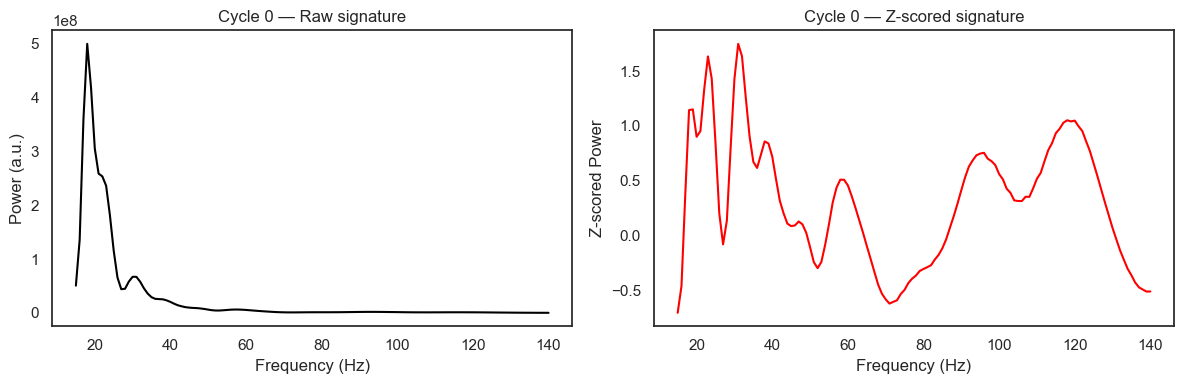

In [41]:
import matplotlib.pyplot as plt

def plot_cycle_signature(cycle_idx, X_raw, X_z, freq_vec):
    """
    Plot spectral signature of a single cycle before and after z-scoring.
    
    cycle_idx : int
        Row index of the cycle in X_raw / X_z
    X_raw : array (n_cycles × n_freq)
        Raw time-mean signatures (before z-scoring)
    X_z : array (n_cycles × n_freq)
        Z-scored signatures (after z-scoring)
    freq_vec : array (n_freq,)
        Frequencies corresponding to columns
    """
    if cycle_idx < 0 or cycle_idx >= X_raw.shape[0]:
        print(f"Invalid cycle_idx {cycle_idx}, max = {X_raw.shape[0]-1}")
        return

    plt.figure(figsize=(12,4))

    # Raw
    plt.subplot(1,2,1)
    plt.plot(freq_vec, X_raw[cycle_idx], color="black")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (a.u.)")
    plt.title(f"Cycle {cycle_idx} — Raw signature")

    # Z-scored
    plt.subplot(1,2,2)
    plt.plot(freq_vec, X_z[cycle_idx], color="red")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Z-scored Power")
    plt.title(f"Cycle {cycle_idx} — Z-scored signature")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_cycle_signature(0, X, Xz, freq_vec)   # plots the first cycle

In [42]:
import matplotlib.pyplot as plt

def plot_multiple_cycle_signatures(cycles_df, X_raw, X_z, freq_vec, 
                                   n_cycles=10, cycle_type="phasic"):
    """
    Loop through and plot spectral signatures (raw + zscored) for multiple cycles.

    cycles_df : DataFrame
        Must contain 'cycle_type' column aligned with rows in X_raw / X_z.
    X_raw : array (n_cycles × n_freq)
        Raw spectral signatures.
    X_z : array (n_cycles × n_freq)
        Z-scored spectral signatures.
    freq_vec : array (n_freq,)
        Frequencies corresponding to columns.
    n_cycles : int
        Number of cycles to plot.
    cycle_type : str ("phasic" or "tonic")
        Which cycles to show.
    """
    # Get indices for requested cycle_type
    idxs = cycles_df.index[cycles_df["cycle_type"] == cycle_type].to_numpy()
    if len(idxs) == 0:
        print(f"No cycles of type '{cycle_type}' found.")
        return

    # Take up to n_cycles
    idxs = idxs[:n_cycles]

    for i, idx in enumerate(idxs, 1):
        plt.figure(figsize=(12, 4))

        # Raw
        plt.subplot(1, 2, 1)
        plt.plot(freq_vec, X_raw[idx], color="black")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power (a.u.)")
        plt.title(f"{cycle_type.capitalize()} cycle {i} (raw)")

        # Z-scored
        plt.subplot(1, 2, 2)
        plt.plot(freq_vec, X_z[idx], color="red")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Z-scored Power")
        plt.title(f"{cycle_type.capitalize()} cycle {i} (z-scored)")

        plt.tight_layout()
        plt.show()

# Example usage:
# Plot 10 phasic cycles
# plot_multiple_cycle_signatures(cycles_df, X, Xz, freq_vec, n_cycles=10, cycle_type="phasic")

# Plot 10 tonic cycles
# plot_multiple_cycle_signatures(cycles_df, X, Xz, freq_vec, n_cycles=10, cycle_type="tonic")

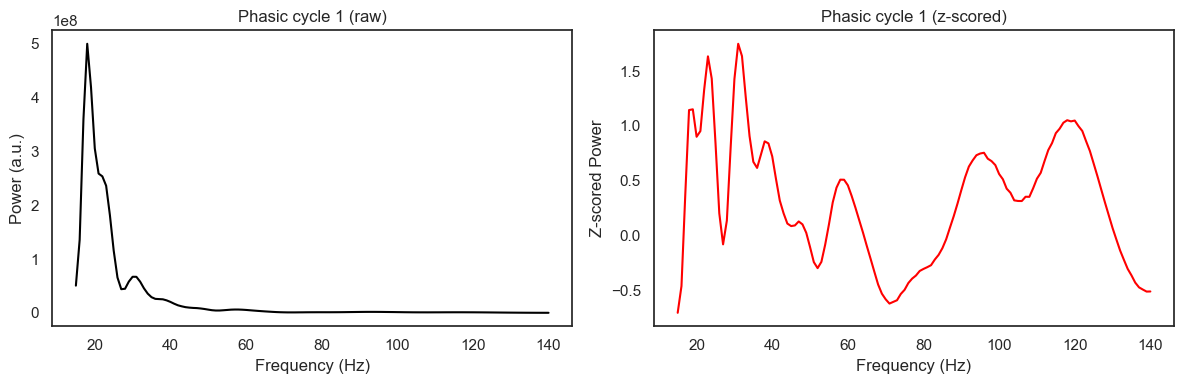

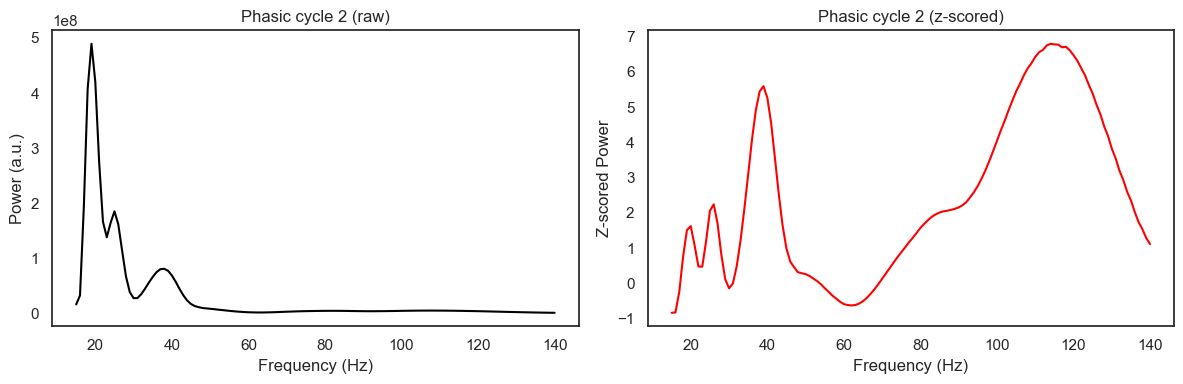

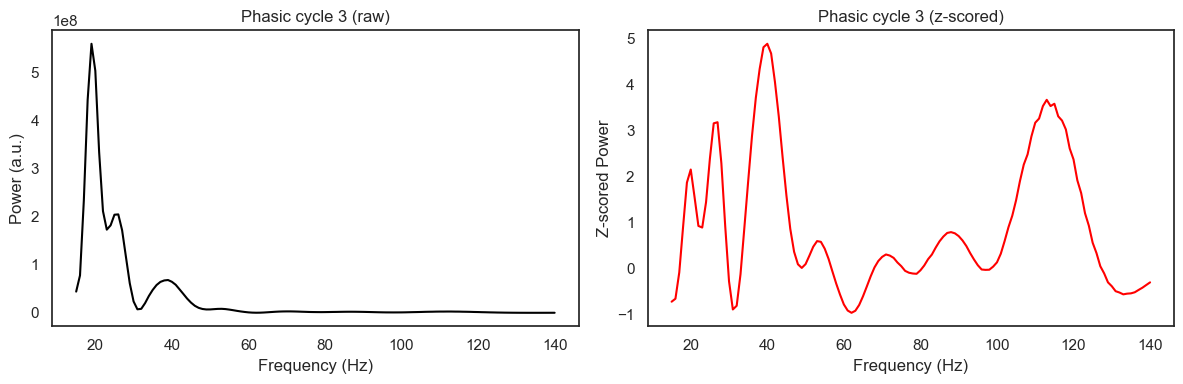

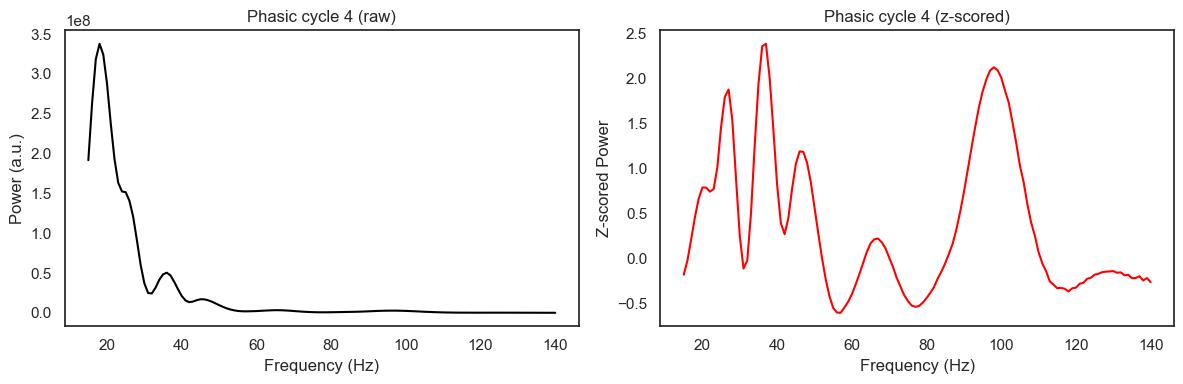

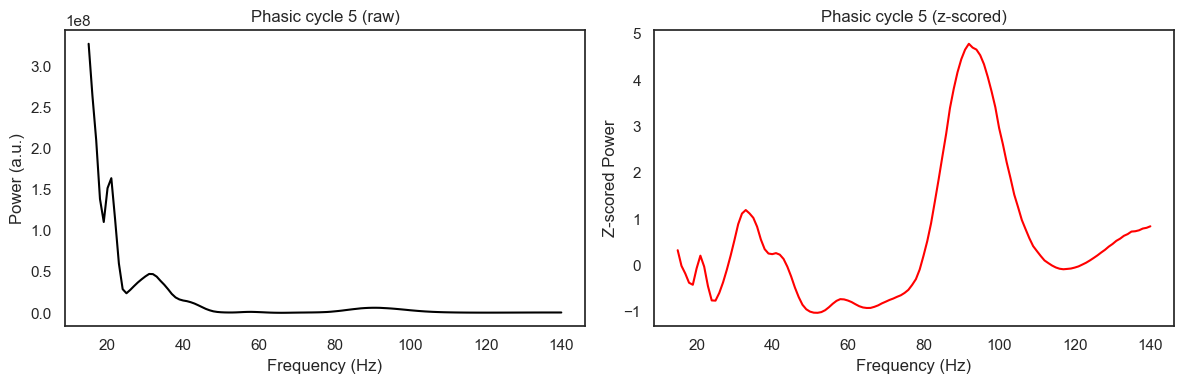

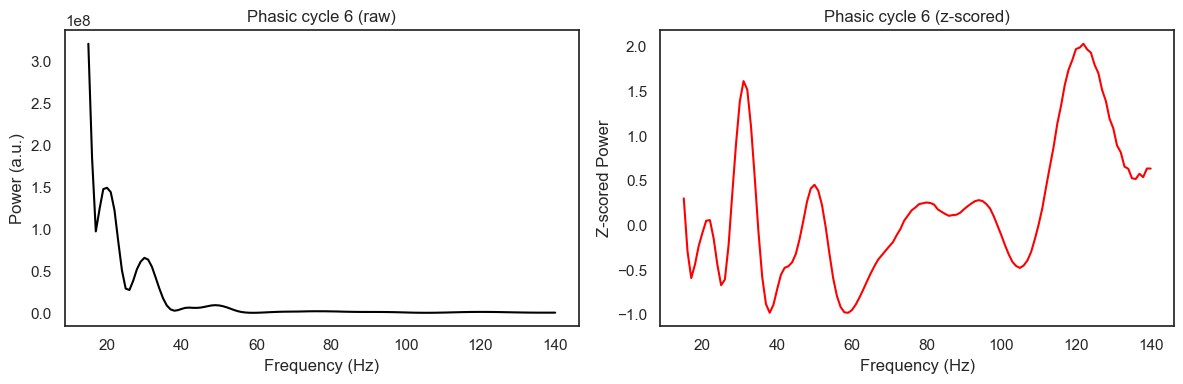

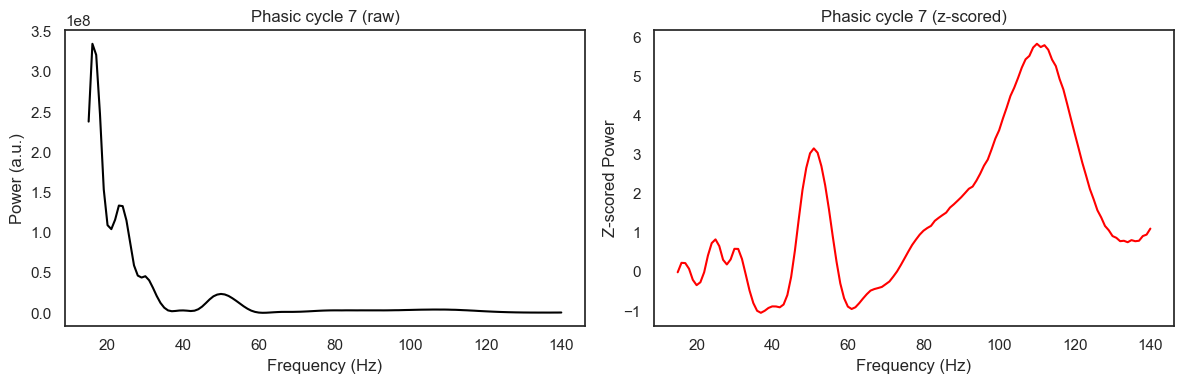

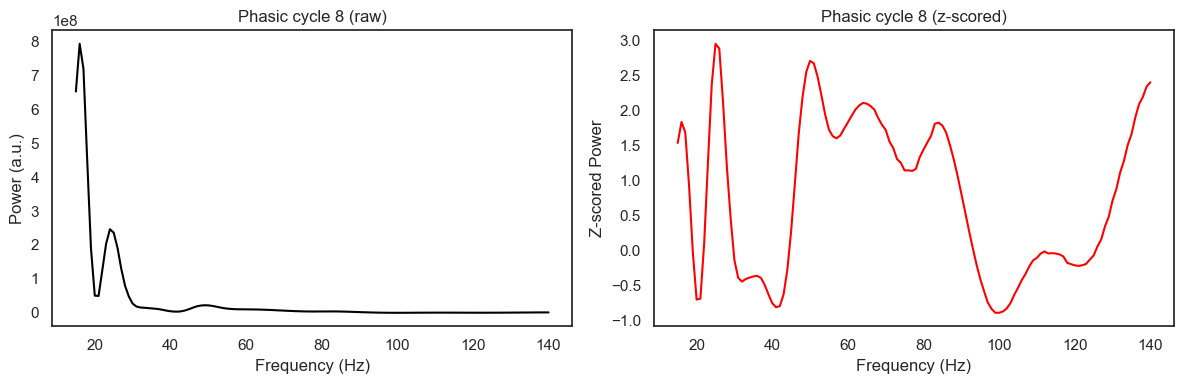

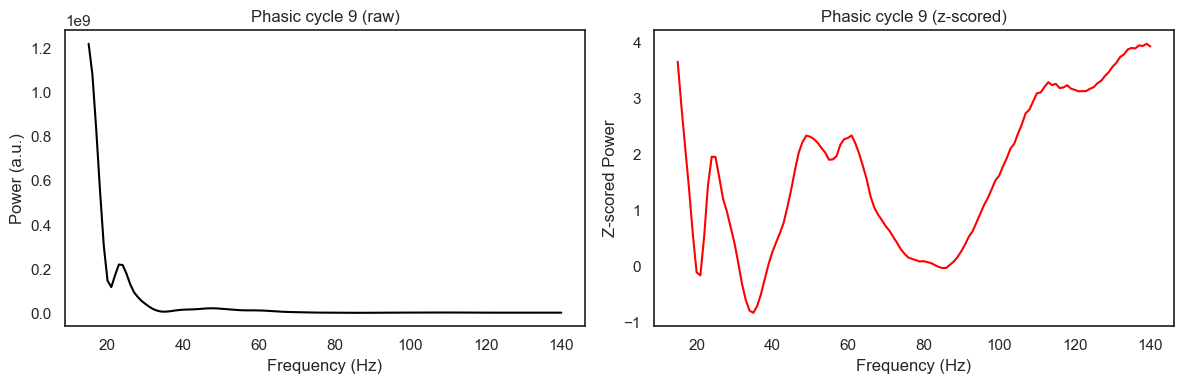

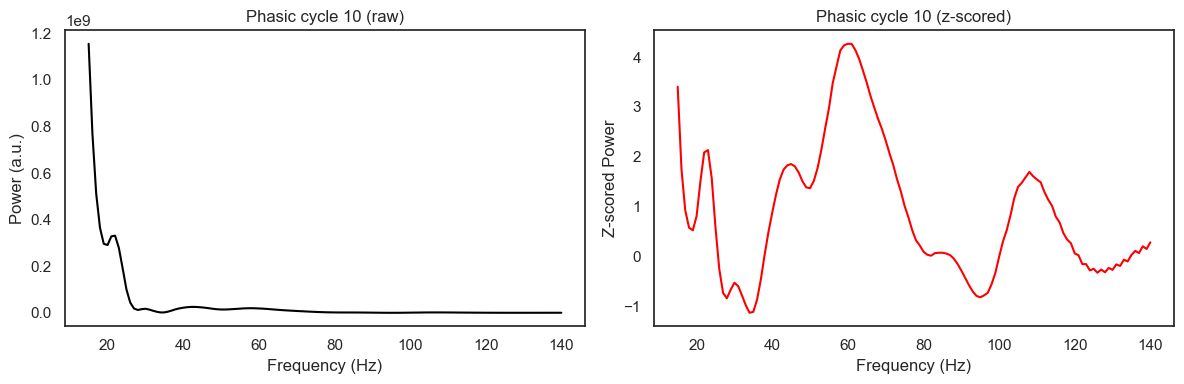

In [43]:
plot_multiple_cycle_signatures(cycles_df, X, Xz, freq_vec, n_cycles=10, cycle_type="phasic")

In [12]:

def run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                     n_pca=5, freq_vec=np.arange(15,141,1), zscore_features=True, mad_k=2.0):
    # 1) flatten
    def _flatten_sig_list(sig_list, label):
        rows, meta = [], []
        for i, arr in enumerate(sig_list):
            if not isinstance(arr, np.ndarray) or arr.size == 0:
                continue
            mask = np.isfinite(arr).all(axis=1)
            Xi = arr[mask]
            if Xi.size == 0: 
                continue
            rows.append(Xi)
            for j in range(Xi.shape[0]):
                meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
        if len(rows) == 0:
            return np.zeros((0, len(freq_vec))), []
        return np.vstack(rows), meta

    X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
    X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures,  "tonic")
    X = np.vstack([X_phasic, X_tonic]); meta = meta_phasic + meta_tonic
    if X.shape[0] == 0:
        raise RuntimeError("No valid cycles to analyze.")

    # 2) feature z-score (across cycles, per freq)
    if zscore_features:
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
        Xz = (X - mu) / sd
    else:
        Xz = X

    # 3) PCA→ICA
    pca = PCA(n_components=n_pca, random_state=42)
    Z = pca.fit_transform(Xz)
    ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
    S = ica.fit_transform(Z)
    W_freq = ica.components_ @ pca.components_     # (n_comp × n_freq)

    # 4) sign fix
    mean_proj = S.mean(axis=0, keepdims=True)
    signs = np.sign(mean_proj); signs[signs == 0] = 1
    S *= signs; W_freq *= signs.T

    # 5) thresholds
    def _mad_threshold(x, k=2.0):
        med = np.median(x); mad = np.median(np.abs(x - med)) + 1e-12
        return med + k * (mad / 0.6745)
    absS = np.abs(S)
    thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])

    # 6) tSC-weighted, within-cycle z-scored mode (ignore first/last bin)
    eps = 1e-12
    labels_0based = np.argmax(absS, axis=1)

    def tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                               avoid_edge_bins=1, alpha=0.4):
        n_cycles, n_freq = X.shape
        modes = np.empty(n_cycles, dtype=float)
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            x = X[i]
            xz = (x - x.mean()) / (x.std(ddof=1) + eps)     # within-cycle z
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                mask = w >= thr
                if mask.sum() >= 3:
                    w[~mask] = 0.0
            y = xz * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg)); idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_proj = tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                                               avoid_edge_bins=1, alpha=0.4)

    # 7) package results
    cycles_df = pd.DataFrame(meta)
    cycles_df["tSC_label"] = labels_0based + 1
    cycles_df["mode_freq_hz_proj"] = mode_freq_hz_proj
    for k in range(n_pca):
        cycles_df[f"tSC{k+1}_strength"] = S[:, k]
        cycles_df[f"tSC{k+1}_strong"]   = (absS[:, k] >= thr_per_comp[k])

    tSC_results = {
        "freq_vec": freq_vec, "pca": pca, "ica": ica,
        "weights_freq": W_freq, "strengths": S,
        "thresholds_abs_strength": thr_per_comp,
        "X_cycles": X, "X_cycles_featZ": Xz, "meta": meta
    }

    print("=== PCA/ICA done ===")
    print("n cycles:", X.shape[0], "| n freq:", X.shape[1], "| n_pca:", n_pca)
    print("Explained variance by PCs:", np.round(pca.explained_variance_ratio_, 3))
    print("Mode freq (tSC-weighted, within-cycle z): median =", np.median(cycles_df['mode_freq_hz_proj']))
    return cycles_df, tSC_results

# ============================================================
# E) SMALL UTILITIES
# ============================================================

def plot_tSC_weights(weights, freqs):
    plt.figure(figsize=(12, 6))
    
    # Color palette avoiding green - using blues, reds, purples, oranges, browns
    color_palette = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange  
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # olive (not green)
        '#17becf',  # cyan
        '#d62728',  # red
        '#ff9896'   # light red
    ]
    
    # Extend palette if needed
    while len(color_palette) < weights.shape[0]:
        color_palette.extend(color_palette)
    
    for k in range(weights.shape[0]):
        w = weights[k]
        pk = freqs[np.argmax(np.abs(w))]
        color = color_palette[k % len(color_palette)]
        plt.plot(freqs, w, label=f"tSC {k+1} (peak {pk:.1f} Hz)", color=color)
        plt.scatter([pk], [w[np.argmax(np.abs(w))]], s=40, color=color)
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mode_freq_histograms_per_component(df, col="mode_freq_hz_proj",
                                            freq_bins=np.linspace(15, 140, 20), ymax=0.25):
    comps = sorted(df["tSC_label"].unique())
    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            vals = sub.loc[sub["cycle_type"] == ctype, col].to_numpy()
            vals = vals[np.isfinite(vals)]
            if vals.size > 0:
                weights = np.ones_like(vals, dtype=float) / vals.size
                ax.hist(vals, bins=freq_bins, weights=weights, alpha=0.8)
            ax.set_xlim(15, 140); ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)"); ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")
        plt.tight_layout(); plt.show()

def print_cycle_counts(cycles_df):
    counts = cycles_df["cycle_type"].value_counts()
    print(f"Phasic cycles: {counts.get('phasic', 0)}")
    print(f"Tonic  cycles: {counts.get('tonic', 0)}")

def plot_cycle_signature(cycle_idx, X_raw, X_z, freq_vec):
    if cycle_idx < 0 or cycle_idx >= X_raw.shape[0]:
        print(f"Invalid cycle_idx {cycle_idx}, max = {X_raw.shape[0]-1}"); return
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(freq_vec, X_raw[cycle_idx], color="black")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Power (a.u.)"); plt.title(f"Cycle {cycle_idx} — Raw signature")
    plt.subplot(1,2,2); plt.plot(freq_vec, X_z[cycle_idx], color="red")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Z-scored Power"); plt.title(f"Cycle {cycle_idx} — Z-scored signature")
    plt.tight_layout(); plt.show()

def plot_multiple_cycle_signatures(cycles_df, X_raw, X_z, freq_vec, n_cycles=10, cycle_type="phasic"):
    idxs = cycles_df.index[cycles_df["cycle_type"] == cycle_type].to_numpy()
    if len(idxs) == 0:
        print(f"No cycles of type '{cycle_type}' found."); return
    idxs = idxs[:n_cycles]
    for i, idx in enumerate(idxs, 1):
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1); plt.plot(freq_vec, X_raw[idx], color="black")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Power (a.u.)"); plt.title(f"{cycle_type.capitalize()} cycle {i} (raw)")
        plt.subplot(1,2,2); plt.plot(freq_vec, X_z[idx], color="red")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Z-scored Power"); plt.title(f"{cycle_type.capitalize()} cycle {i} (z-scored)")
        plt.tight_layout(); plt.show()

# ============================================================
# F) RUN FOR ONE RAT
# ============================================================

cycles_df, tSC_results = run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                                          n_pca=5, freq_vec=np.arange(15,141,1),
                                          zscore_features=True, mad_k=2.0)



=== PCA/ICA done ===
n cycles: 61171 | n freq: 126 | n_pca: 5
Explained variance by PCs: [0.365 0.147 0.088 0.068 0.06 ]
Mode freq (tSC-weighted, within-cycle z): median = 16.0


Phasic cycles: 2899
Tonic  cycles: 58272


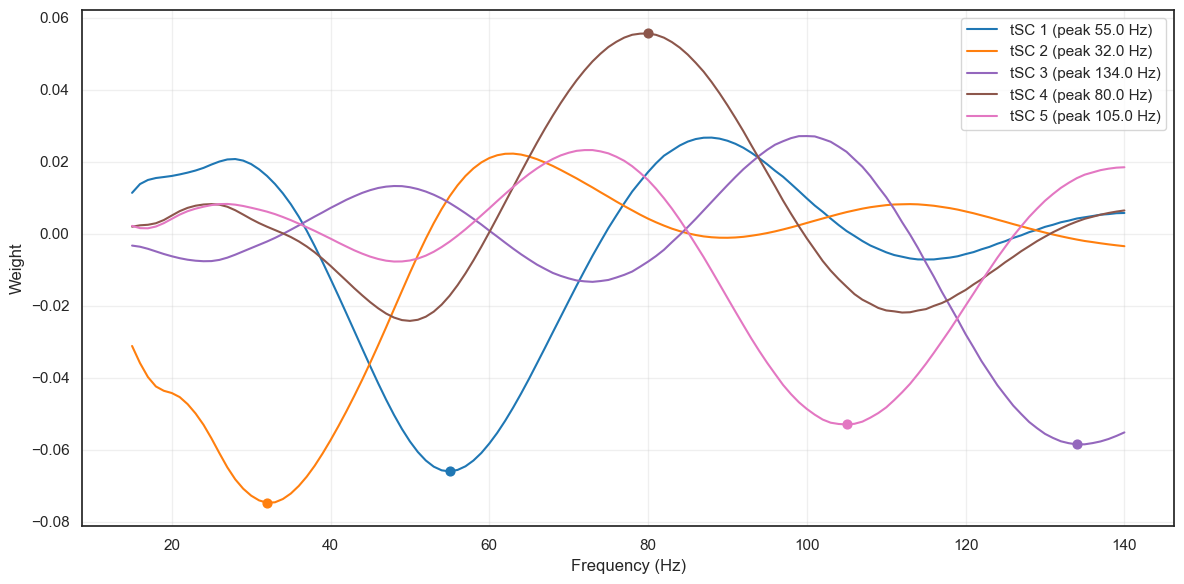

In [13]:
print_cycle_counts(cycles_df)
plot_tSC_weights(tSC_results["weights_freq"], tSC_results["freq_vec"])


In [14]:
from sklearn.decomposition import PCA, FastICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.ndimage import gaussian_filter1d
    _HAS_SCI = True
except Exception:
    _HAS_SCI = False


def run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                     n_pca=5, freq_vec=np.arange(15,141,1),
                     zscore_features=True, mad_k=2.0,
                     weighted_alpha=0.4,      # support mask for weighted modes; set None to disable
                     ignore_edge_bins=1,      # don’t pick first/last bin
                     smooth_sigma_hz=5.0      # legacy: 5-Hz (reflect) smoother; kept for backward compat
                    ):
    """
    Returns:
      cycles_df with (now) many mode-frequency columns:
        - mode_freq_hz_featZ                   (unsmoothed feature-Z)
        - mode_freq_hz_featZ_smooth            (5 Hz reflect; legacy default)
        - mode_freq_hz_featZ_smooth10          (10 Hz reflect)
        - mode_freq_hz_featZ_smooth5_pad       (5 Hz zero-padding)
        - mode_freq_hz_featZ_smooth10_pad      (10 Hz zero-padding)
        - mode_freq_hz_featZw                  (feature-Z * |W_k|)
        - mode_freq_hz_proj                    (within-Z * |W_k|)
      tSC_results dict with:
        - X_cycles, X_cycles_featZ
        - X_cycles_featZ_smooth                (5 Hz reflect)
        - X_cycles_featZ_smooth10              (10 Hz reflect)
        - X_cycles_featZ_smooth5_pad           (5 Hz zero-padding)
        - X_cycles_featZ_smooth10_pad          (10 Hz zero-padding)
        - weights_freq, strengths, thresholds, meta, freq_vec
    """
    # ---------------- 1) flatten ----------------
    def _flatten_sig_list(sig_list, label):
        rows, meta = [], []
        for i, arr in enumerate(sig_list):
            if not isinstance(arr, np.ndarray) or arr.size == 0:
                continue
            mask = np.isfinite(arr).all(axis=1)
            Xi = arr[mask]
            if Xi.size == 0:
                continue
            rows.append(Xi)
            for j in range(Xi.shape[0]):
                meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
        if len(rows) == 0:
            return np.zeros((0, len(freq_vec))), []
        return np.vstack(rows), meta

    X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
    X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures,  "tonic")
    X = np.vstack([X_phasic, X_tonic]); meta = meta_phasic + meta_tonic
    if X.shape[0] == 0:
        raise RuntimeError("No valid cycles to analyze.")

    # ---------------- 2) feature z-score (across cycles, per freq) ----------------
    if zscore_features:
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
        Xz = (X - mu) / sd
    else:
        Xz = X

    # ---- helper: gaussian smoothing along frequency with selectable boundary mode ----
    def _smooth_rows(mat, sigma_hz, mode="reflect"):
        if _HAS_SCI:
            return gaussian_filter1d(mat, sigma=float(sigma_hz), axis=1, mode=mode)
        # fallback conv if SciPy missing
        sigma = float(sigma_hz)
        rad = int(np.ceil(4 * sigma))
        kx = np.arange(-rad, rad + 1)
        ker = np.exp(-(kx**2) / (2 * sigma**2))
        ker /= ker.sum()
        pad = rad
        out = np.empty_like(mat)
        for i in range(mat.shape[0]):
            row = mat[i]
            if mode == "reflect":
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            elif mode == "constant":  # zero padding
                row_pad = np.r_[np.zeros(pad), row, np.zeros(pad)]
            else:
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            out[i] = np.convolve(row_pad, ker, mode="same")[pad:-pad]
        return out

    # ---------------- 2b) build ALL smoothed versions of Xz ----------------
    # reflect (mirror) boundary
    Xz_smooth5_ref  = _smooth_rows(Xz,  5.0, mode="reflect")
    Xz_smooth10_ref = _smooth_rows(Xz, 10.0, mode="reflect")
    # zero-padding boundary
    Xz_smooth5_pad  = _smooth_rows(Xz,  5.0, mode="constant")
    Xz_smooth10_pad = _smooth_rows(Xz, 10.0, mode="constant")

    # keep old name for backward compat (5 Hz reflect)
    Xz_smooth = Xz_smooth5_ref

    # ---------------- 3) PCA → ICA (fit on Xz as before) ----------------
    pca = PCA(n_components=n_pca, random_state=42)
    Z = pca.fit_transform(Xz)
    ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
    S  = ica.fit_transform(Z)
    W_freq = ica.components_ @ pca.components_     # (n_comp × n_freq)

    # ---------------- 4) sign fix ----------------
    mean_proj = S.mean(axis=0, keepdims=True)
    signs = np.sign(mean_proj); signs[signs == 0] = 1
    S *= signs; W_freq *= signs.T

    # ---------------- 5) robust thresholds ----------------
    def _mad_threshold(x, k=2.0):
        med = np.median(x); mad = np.median(np.abs(x - med)) + 1e-12
        return med + k * (mad / 0.6745)
    absS = np.abs(S)
    thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])

    # ---------------- A) MODE FROM FEATURE-Z (unsmoothed) ----------------
    lo, hi = ignore_edge_bins, (Xz.shape[1] - ignore_edge_bins)
    if hi <= lo:
        idx_featZ = np.argmax(Xz, axis=1)
    else:
        idx_featZ = np.argmax(Xz[:, lo:hi], axis=1) + lo
    mode_freq_hz_featZ = freq_vec[idx_featZ]

    # ---------- A2) MODES FROM EACH SMOOTHED VARIANT (reflect & zero-pad) ----------
    def _mode_from_mat(mat):
        L, R = ignore_edge_bins, (mat.shape[1] - ignore_edge_bins)
        if R <= L:
            idx = np.argmax(mat, axis=1)
        else:
            idx = np.argmax(mat[:, L:R], axis=1) + L
        return freq_vec[idx]

    mode_freq_hz_featZ_smooth       = _mode_from_mat(Xz_smooth5_ref)     # legacy 5 Hz reflect
    mode_freq_hz_featZ_smooth10     = _mode_from_mat(Xz_smooth10_ref)    # 10 Hz reflect
    mode_freq_hz_featZ_smooth5_pad  = _mode_from_mat(Xz_smooth5_pad)     # 5 Hz zero-pad
    mode_freq_hz_featZ_smooth10_pad = _mode_from_mat(Xz_smooth10_pad)    # 10 Hz zero-pad

    # ---------------- optional: weighted by assigned tSC (feature-Z) ----------
    labels_0based = np.argmax(absS, axis=1)

    def mode_from_feature_z_weighted(Xz_like, W_freq, labels_0based, freq_vec,
                                     avoid_edge_bins=1, alpha=None):
        n_cycles, n_freq = Xz_like.shape
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        modes = np.empty(n_cycles, dtype=float)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                m = (w >= thr)
                if m.sum() >= 3:
                    w[~m] = 0.0
            y = Xz_like[i] * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg))
            idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_featZ_weighted = mode_from_feature_z_weighted(
        Xz, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- B) kept: within-cycle-Z + tSC|w| mode -------------------
    eps = 1e-12
    def tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                               avoid_edge_bins=1, alpha=0.4):
        n_cycles, n_freq = X.shape
        modes = np.empty(n_cycles, dtype=float)
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            x = X[i]
            xz = (x - x.mean()) / (x.std(ddof=1) + eps)   # within-cycle z
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                mask = w >= thr
                if mask.sum() >= 3:
                    w[~mask] = 0.0
            y = xz * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg)); idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_proj = tsc_weighted_mode_freq(
        X, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- 7) package results ----------------
    cycles_df = pd.DataFrame(meta)
    cycles_df["tSC_label"]                   = labels_0based + 1
    cycles_df["mode_freq_hz_featZ"]          = mode_freq_hz_featZ
    cycles_df["mode_freq_hz_featZ_smooth"]   = mode_freq_hz_featZ_smooth      # 5 Hz reflect
    cycles_df["mode_freq_hz_featZ_smooth10"] = mode_freq_hz_featZ_smooth10    # 10 Hz reflect
    cycles_df["mode_freq_hz_featZ_smooth5_pad"]  = mode_freq_hz_featZ_smooth5_pad   # 5 Hz zero-pad
    cycles_df["mode_freq_hz_featZ_smooth10_pad"] = mode_freq_hz_featZ_smooth10_pad  # 10 Hz zero-pad
    cycles_df["mode_freq_hz_featZw"]         = mode_freq_hz_featZ_weighted
    cycles_df["mode_freq_hz_proj"]           = mode_freq_hz_proj

    for k in range(n_pca):
        cycles_df[f"tSC{k+1}_strength"] = S[:, k]
        cycles_df[f"tSC{k+1}_strong"]   = (absS[:, k] >= thr_per_comp[k])

    tSC_results = {
        "freq_vec": freq_vec, "pca": pca, "ica": ica,
        "weights_freq": W_freq, "strengths": S,
        "thresholds_abs_strength": thr_per_comp,
        "X_cycles": X,
        "X_cycles_featZ": Xz,
        "X_cycles_featZ_smooth":    Xz_smooth5_ref,   # 5 Hz reflect
        "X_cycles_featZ_smooth10":  Xz_smooth10_ref,  # 10 Hz reflect
        "X_cycles_featZ_smooth5_pad":  Xz_smooth5_pad,   # 5 Hz zero-pad
        "X_cycles_featZ_smooth10_pad": Xz_smooth10_pad,  # 10 Hz zero-pad
        "meta": meta
    }

    print("=== PCA/ICA done ===")
    print("n cycles:", X.shape[0], "| n freq:", X.shape[1], "| n_pca:", n_pca)
    print("Explained variance (PCs):", np.round(pca.explained_variance_ratio_, 3))
    print("Mode — featZ (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ']))
    print("Mode — featZ 5Hz reflect (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth']))
    print("Mode — featZ 10Hz reflect (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth10']))
    print("Mode — featZ 5Hz pad0 (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth5_pad']))
    print("Mode — featZ 10Hz pad0 (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth10_pad']))
    print("Mode — featZ + tSC|w| (median):", np.nanmedian(cycles_df['mode_freq_hz_featZw']))
    print("Mode — within-Z + tSC|w| (median):", np.nanmedian(cycles_df['mode_freq_hz_proj']))
    return cycles_df, tSC_results

In [15]:
cycles_df, tSC_results = run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                                          n_pca=5, freq_vec=np.arange(15,141,1),
                                          zscore_features=True, mad_k=2.0)

=== PCA/ICA done ===
n cycles: 61171 | n freq: 126 | n_pca: 5
Explained variance (PCs): [0.365 0.147 0.088 0.068 0.06 ]
Mode — featZ (median): 42.0
Mode — featZ 5Hz reflect (median): 63.0
Mode — featZ 10Hz reflect (median): 70.0
Mode — featZ 5Hz pad0 (median): 64.0
Mode — featZ 10Hz pad0 (median): 71.0
Mode — featZ + tSC|w| (median): 52.0
Mode — within-Z + tSC|w| (median): 16.0


Phasic cycles: 2899
Tonic  cycles: 58272


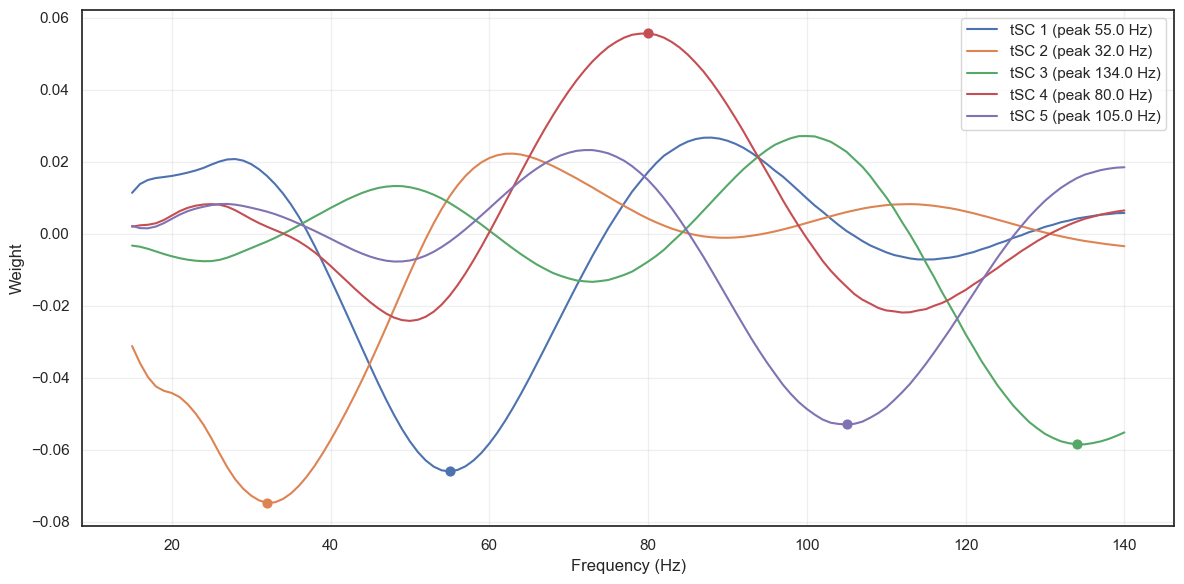

In [79]:
print_cycle_counts(cycles_df)
plot_tSC_weights(tSC_results["weights_freq"], tSC_results["freq_vec"])


In [ ]:
def plot_mode_freq_histograms_per_component(
        df,
        col="mode_freq_hz_featZ_smooth",   # can be str or list[str]
        freq_bins=np.linspace(15, 140, 20),
        ymax=0.25,
        peaks_hz=None,              # optional: array of component peak freqs
        weights=None, freq_vec=None # or pass weights+freq_vec to compute peaks
    ):
    """
    Plot per-component histograms for phasic/tonic.
    `col` can be a single column name (str) or a list of column names to overlay.

    Recognized columns include:
      'mode_freq_hz_featZ', 'mode_freq_hz_featZ_smooth', 'mode_freq_hz_featZ_smooth10',
      'mode_freq_hz_featZ_smooth5_pad', 'mode_freq_hz_featZ_smooth10_pad',
      'mode_freq_hz_featZw', 'mode_freq_hz_proj'
    """
    # allow col to be list for overlays
    cols = [col] if isinstance(col, str) else list(col)
    palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(cols))))

    comps = sorted(df["tSC_label"].dropna().unique().astype(int))

    # Derive peaks if not provided but weights+freq_vec are available
    if peaks_hz is None and (weights is not None) and (freq_vec is not None):
        weights = np.asarray(weights)
        freq_vec = np.asarray(freq_vec)
        peak_idx = np.argmax(np.abs(weights), axis=1)
        computed_peaks = freq_vec[peak_idx]
        peaks_map = {k+1: computed_peaks[k] for k in range(weights.shape[0])}
    else:
        peaks_map = {}
        if peaks_hz is not None:
            peaks_hz = np.asarray(peaks_hz)
            for i, p in enumerate(peaks_hz, start=1):
                peaks_map[i] = p

    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            for ci, c in enumerate(cols):
                vals = sub.loc[sub["cycle_type"] == ctype, c].to_numpy(dtype=float)
                vals = vals[np.isfinite(vals)]
                if vals.size > 0:
                    weights_norm = np.ones_like(vals, dtype=float) / vals.size
                    ax.hist(vals, bins=freq_bins, weights=weights_norm,
                            alpha=0.5, color=palette[ci], label=c)
            ax.set_xlim(freq_bins.min(), freq_bins.max())
            ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)")
            if j == 0:
                ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")

            # vertical line at component peak
            if comp in peaks_map and np.isfinite(peaks_map[comp]):
                pk = float(peaks_map[comp])
                ax.axvline(pk, ls="--", lw=2, color="k", alpha=0.9)
                ax.text(pk, ymax*0.95, f"{pk:.1f} Hz", ha="center", va="top")

            if j == 1:
                ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

In [ ]:
# # with coloring

# def plot_mode_freq_histograms_per_component(
#         df,
#         col="mode_freq_hz_featZ_smooth",   # can be str or list[str]
#         freq_bins=np.linspace(15, 140, 20),
#         ymax=0.25,
#         peaks_hz=None,              # optional: array of component peak freqs
#         weights=None, freq_vec=None # or pass weights+freq_vec to compute peaks
#     ):
#     """
#     Plot per-component histograms for phasic/tonic.
#     `col` can be a single column name (str) or a list of column names to overlay.

#     Recognized columns include:
#       'mode_freq_hz_featZ', 'mode_freq_hz_featZ_smooth', 'mode_freq_hz_featZ_smooth10',
#       'mode_freq_hz_featZ_smooth5_pad', 'mode_freq_hz_featZ_smooth10_pad',
#       'mode_freq_hz_featZw', 'mode_freq_hz_proj'
#     """
#     # allow col to be list for overlays
#     cols = [col] if isinstance(col, str) else list(col)
    
#     # Color palette avoiding green - using blues, reds, purples, oranges, browns
#     color_palette = [
#         '#1f77b4',  # blue
#         '#ff7f0e',  # orange  
#         '#9467bd',  # purple
#         '#8c564b',  # brown
#         '#e377c2',  # pink
#         '#7f7f7f',  # gray
#         '#bcbd22',  # olive
#         '#17becf',  # cyan
#         '#d62728',  # red
#         '#ff9896'   # light red
#     ]
    
#     # Extend palette if needed
#     while len(color_palette) < len(cols):
#         color_palette.extend(color_palette)
#     palette = color_palette[:len(cols)]

#     comps = sorted(df["tSC_label"].dropna().unique().astype(int))

#     # Derive peaks if not provided but weights+freq_vec are available
#     if peaks_hz is None and (weights is not None) and (freq_vec is not None):
#         weights = np.asarray(weights)
#         freq_vec = np.asarray(freq_vec)
#         peak_idx = np.argmax(np.abs(weights), axis=1)
#         computed_peaks = freq_vec[peak_idx]
#         peaks_map = {k+1: computed_peaks[k] for k in range(weights.shape[0])}
#     else:
#         peaks_map = {}
#         if peaks_hz is not None:
#             peaks_hz = np.asarray(peaks_hz)
#             for i, p in enumerate(peaks_hz, start=1):
#                 peaks_map[i] = p

#     for comp in comps:
#         sub = df[df["tSC_label"] == comp]
#         fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

#         for j, ctype in enumerate(["phasic", "tonic"]):
#             ax = axes[j]
#             for ci, c in enumerate(cols):
#                 vals = sub.loc[sub["cycle_type"] == ctype, c].to_numpy(dtype=float)
#                 vals = vals[np.isfinite(vals)]
#                 if vals.size > 0:
#                     weights_norm = np.ones_like(vals, dtype=float) / vals.size
#                     ax.hist(vals, bins=freq_bins, weights=weights_norm,
#                             alpha=0.5, color=palette[ci], label=c)
#             ax.set_xlim(freq_bins.min(), freq_bins.max())
#             ax.set_ylim(0, ymax)
#             ax.set_xlabel("Mode frequency (Hz)")
#             if j == 0:
#                 ax.set_ylabel("Probability")
#             ax.set_title(f"tSC {comp} — {ctype.capitalize()}")

#             # vertical line at component peak
#             if comp in peaks_map and np.isfinite(peaks_map[comp]):
#                 pk = float(peaks_map[comp])
#                 ax.axvline(pk, ls="--", lw=2, color="k", alpha=0.9)
#                 ax.text(pk, ymax*0.95, f"{pk:.1f} Hz", ha="center", va="top")

#             if j == 1:
#                 ax.legend(fontsize=8)

#         plt.tight_layout()
#         plt.show()


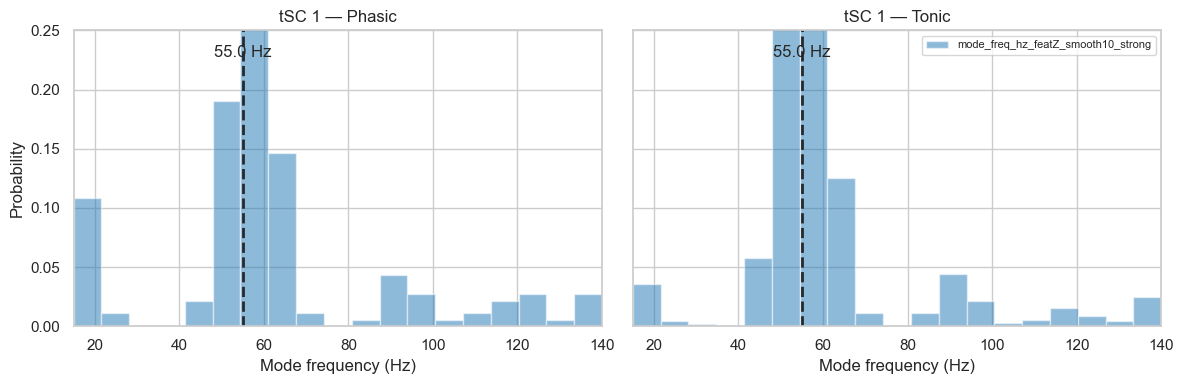

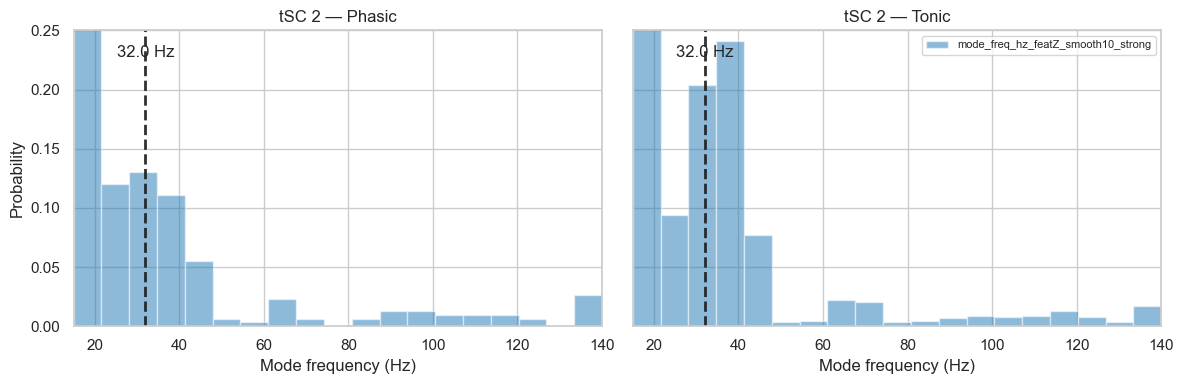

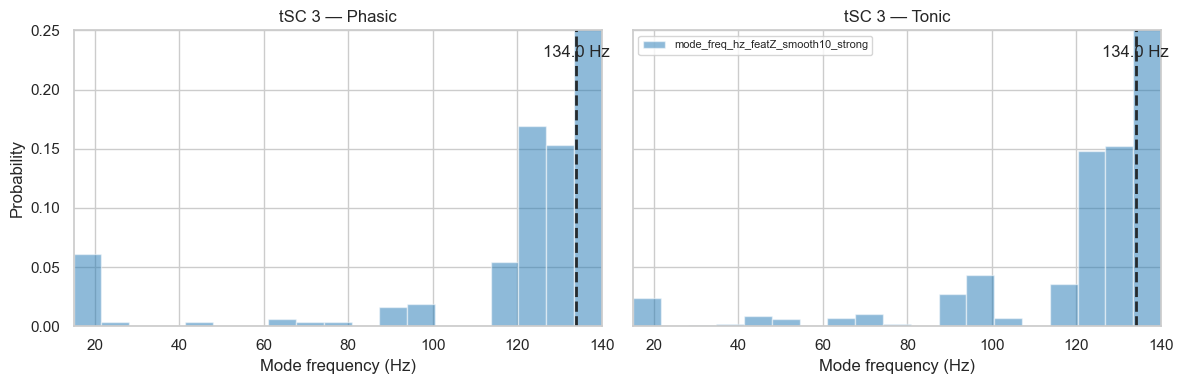

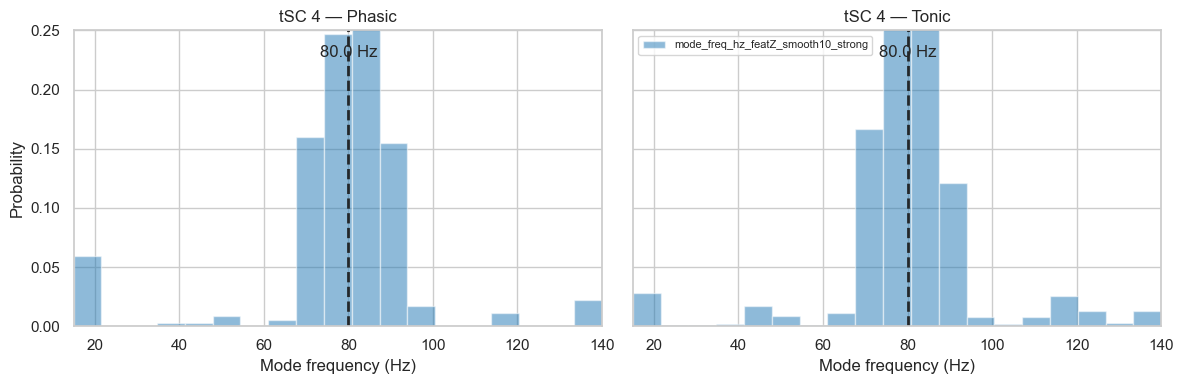

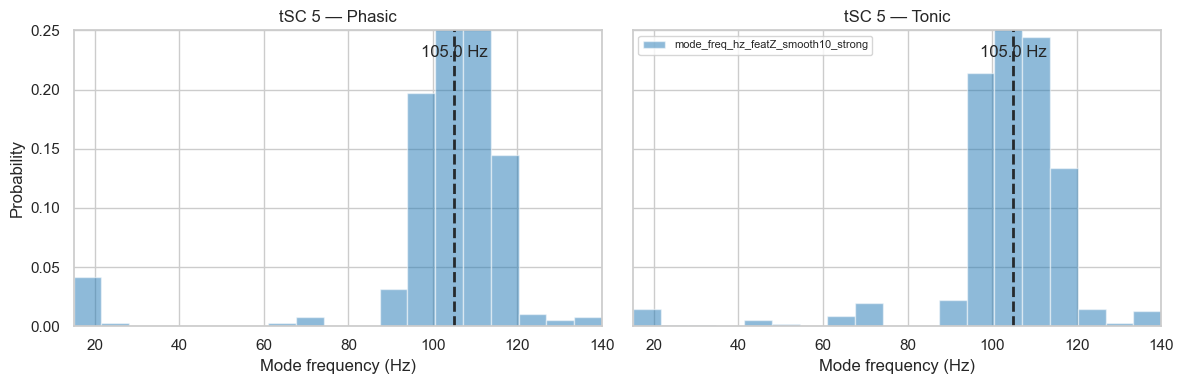

In [127]:
plot_mode_freq_histograms_per_component(
    cycles_df,
    col=["mode_freq_hz_featZ_smooth10_strong"],
    freq_bins=np.linspace(15, 140, 20),
    ymax=0.25,
    weights=tSC_results["weights_freq"],
    freq_vec=tSC_results["freq_vec"]
)

In [143]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import blended_transform_factory
from scipy.stats import mannwhitneyu

def plot_component_box_swarm_pro(
    cycles_df,
    comp,
    col="mode_freq_hz_featZ_smooth",
    ymin=15, ymax=140,
    yticks=np.arange(15, 141, 10),
    palette={"phasic": "red", "tonic": "blue"},
    max_points_per_group=3000,
    seed=0,
    savepath=None,
):
    """
    Professional layout:
      - Dedicated header axis for stats (no collisions with the plot)
      - Box + side-swarm per cycle type
      - Median labels and n above boxes
    Works directly with your cycles_df / new mode-frequency columns.
    """
    # ----- prep data -----
    if col not in cycles_df.columns:
        raise ValueError(f"{col} not found in cycles_df")

    df = cycles_df.rename(columns={"tSC_label": "tSC_component_1based", col: "mode_freqs"}).copy()
    sub = df[
        (df["tSC_component_1based"] == int(comp)) &
        (df["cycle_type"].isin(["phasic", "tonic"])) &
        (df["mode_freqs"].between(ymin, ymax))
    ].copy()
    if sub.empty:
        print(f"No rows for component {comp} in '{col}'.")
        return

    order = ["phasic", "tonic"]
    counts = sub.groupby("cycle_type")["mode_freqs"].size().reindex(order, fill_value=0)
    meds   = sub.groupby("cycle_type")["mode_freqs"].median().reindex(order)

    # ----- figure with header axis + main axis -----
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(9.2, 6.2))
    gs = GridSpec(nrows=2, ncols=1, height_ratios=[0.28, 1.0], hspace=0.1, figure=fig)
    ax_header = fig.add_subplot(gs[0])
    ax       = fig.add_subplot(gs[1])
    ax_header.axis("off")  # header is text-only

    # ----- main boxplot -----
    sns.boxplot(
        data=sub, x="cycle_type", y="mode_freqs",
        order=order, palette=palette, width=0.5, showfliers=False,
        linewidth=1.8,
        boxprops=dict(edgecolor="black", alpha=0.95),
        medianprops=dict(color="black", linewidth=2.2),
        whiskerprops=dict(color="black", linewidth=1.8),
        capprops=dict(color="black", linewidth=1.8),
        ax=ax,
    )

    # ----- side swarm (left of phasic, right of tonic) -----
    rng = np.random.default_rng(seed)
    def side_swarm(y, x_center, side, offset=0.42, spread=0.08):
        y = np.asarray(y)
        if y.size > max_points_per_group:
            y = rng.choice(y, size=max_points_per_group, replace=False)
        x = np.full(y.size, x_center + side*offset)
        x += rng.uniform(-spread, spread, size=y.size)
        ax.scatter(x, y, s=9, alpha=0.35, color="black", lw=0, zorder=3)

    for xi, ct in enumerate(order):
        side_swarm(sub.loc[sub["cycle_type"] == ct, "mode_freqs"], xi, -1 if ct=="phasic" else +1)

    # median labels on boxes
    for xi, ct in enumerate(order):
        m = meds[ct]
        if np.isfinite(m):
            ax.text(xi, m, f"{m:.1f} Hz", ha="center", va="center", fontsize=9,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1.4), zorder=4)

    # n labels above boxes (in axis coords, just above top)
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(0, 1.02, f"n={int(counts['phasic'])}", transform=trans, ha="center", va="bottom", fontsize=10)
    ax.text(1, 1.02, f"n={int(counts['tonic'])}",  transform=trans, ha="center", va="bottom", fontsize=10)

    # ----- header text in its own axis (no overlap, clean) -----
    a = sub.loc[sub["cycle_type"]=="phasic", "mode_freqs"].to_numpy()
    b = sub.loc[sub["cycle_type"]=="tonic",  "mode_freqs"].to_numpy()
    header_lines = []
    if (a.size > 0) and (b.size > 0):
        stat_2s, p_2s = mannwhitneyu(a, b, alternative="two-sided", method="auto")
        stat_g,  p_g  = mannwhitneyu(a, b, alternative="greater",   method="auto")
        delta = float(np.median(b) - np.median(a))
        cles  = stat_g / (a.size * b.size)  # P(X_phasic > Y_tonic)

        verdict = "YES" if (p_g < 0.05 and delta < 0) else "NO"
        vcolor  = "green" if verdict == "YES" else "black"

        # three lines, centered
        ax_header.text(0.5, 0.92, f"Phasic > Tonic?  {verdict}",
                       ha="center", va="top", fontsize=12, fontweight="bold", color=vcolor)
        ax_header.text(0.5, 0.66,
                       f"Mann–Whitney U: two-sided p={p_2s:.2e}   |   one-sided (phasic>tonic) p={p_g:.2e}",
                       ha="center", va="top", fontsize=10)
        ax_header.text(0.5, 0.42,
                       f"Δmedian (tonic − phasic) = {delta:+.1f} Hz   |   CLES = {cles:.2f}",
                       ha="center", va="top", fontsize=10)
    # component title under the header block
    ax_header.text(0.5, 0.10,
                   f"Component {comp} — Mode frequency distribution ({col})",
                   ha="center", va="top", fontsize=12)

    # ----- cosmetics -----
    ax.set_xlim(-0.65, 1.65)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_yticks(yticks)
    ax.set_xlabel("Cycle type")
    ax.set_ylabel("Mode frequency (Hz)")
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.grid(axis="x", visible=False)
    if ax.get_legend(): ax.legend_.remove()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()


def plot_all_components_box_swarm_pro(cycles_df, col="mode_freq_hz_featZ_smooth", **kw):
    comps = sorted(cycles_df["tSC_label"].dropna().unique().astype(int))
    for comp in comps:
        plot_component_box_swarm_pro(cycles_df, comp, col=col, **kw)

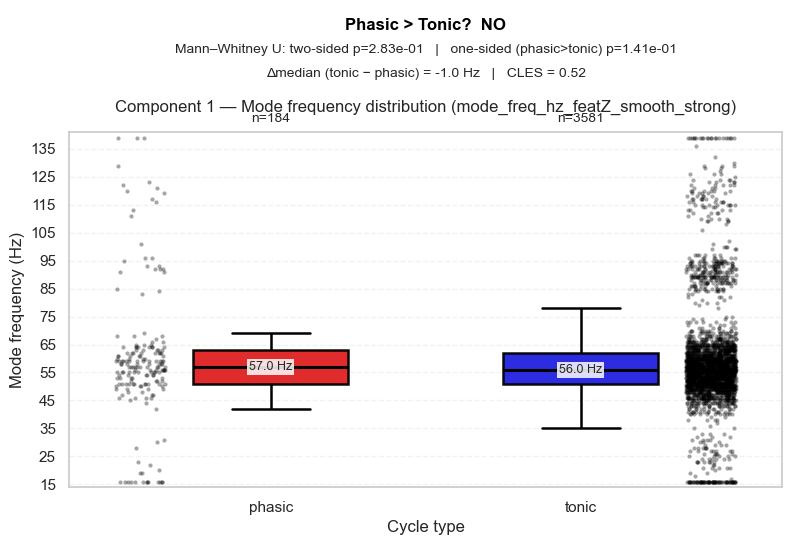

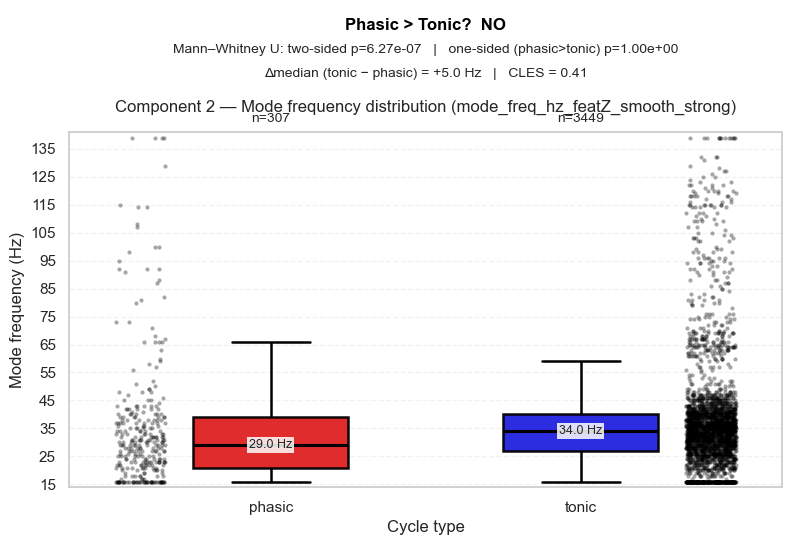

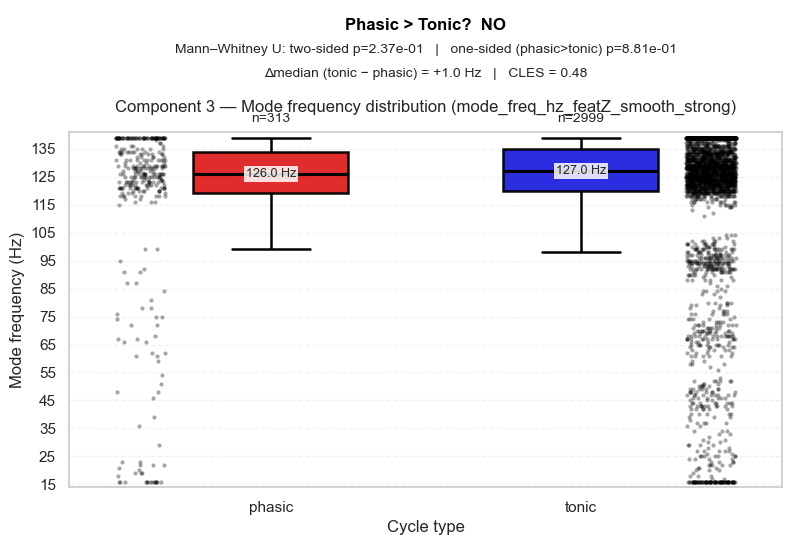

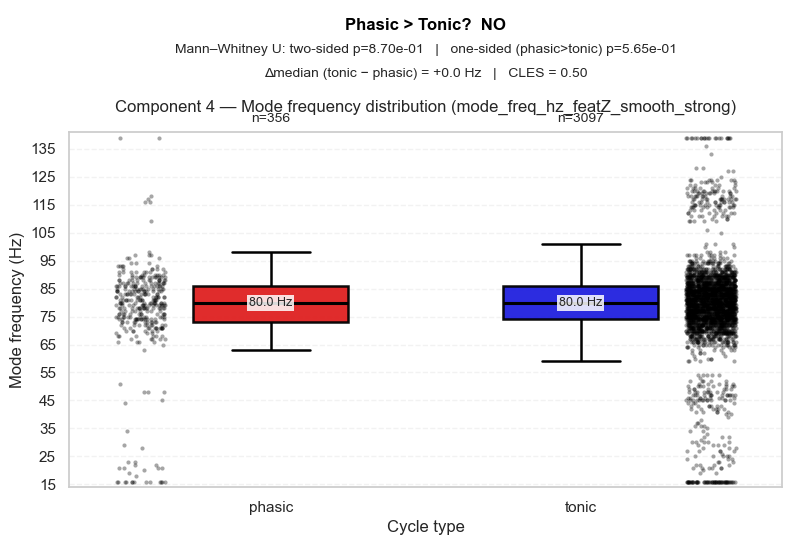

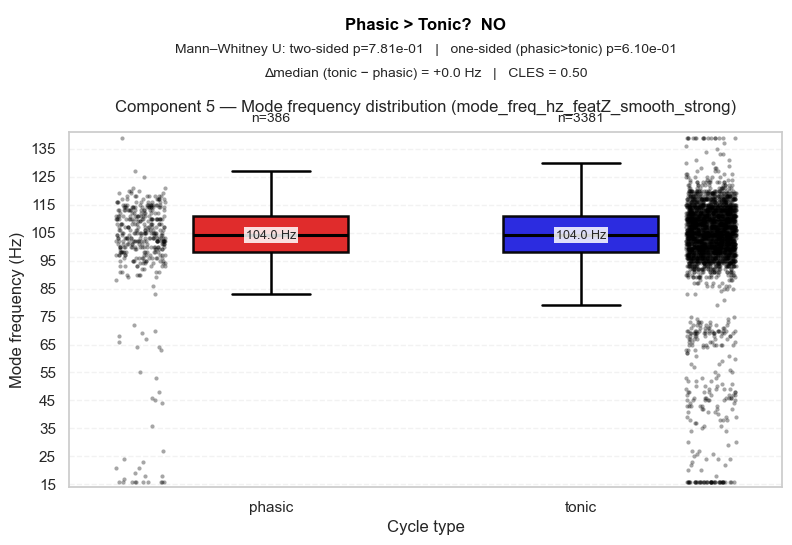

In [146]:
plot_all_components_box_swarm_pro(
    cycles_df,
    col="mode_freq_hz_featZ_smooth_strong"
)

## last version

In [16]:
from sklearn.decomposition import PCA, FastICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.ndimage import gaussian_filter1d
    _HAS_SCI = True
except Exception:
    _HAS_SCI = False


def run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                     n_pca=5, freq_vec=np.arange(15,141,1),
                     zscore_features=True, mad_k=2.0,
                     weighted_alpha=0.4,      # support mask for weighted modes; set None to disable
                     ignore_edge_bins=1       # don’t pick first/last bin
                    ):
    """
    Returns cycles_df with:
      - mode_freq_hz_featZ
      - mode_freq_hz_featZ_smooth       (5 Hz reflect)
      - mode_freq_hz_featZ_smooth10     (10 Hz reflect)
      - mode_freq_hz_featZ_smooth5_pad  (5 Hz pad0)
      - mode_freq_hz_featZ_smooth10_pad (10 Hz pad0)
      - *_strong versions (computed only for cycles above MAD threshold)
      - mode_freq_hz_featZw             (feature-Z * |W_k|)
      - mode_freq_hz_proj               (within-cycle Z * |W_k|)
    """

    # ---------------- 1) flatten ----------------
    def _flatten_sig_list(sig_list, label):
        rows, meta = [], []
        for i, arr in enumerate(sig_list):
            if not isinstance(arr, np.ndarray) or arr.size == 0:
                continue
            mask = np.isfinite(arr).all(axis=1)
            Xi = arr[mask]
            if Xi.size == 0:
                continue
            rows.append(Xi)
            for j in range(Xi.shape[0]):
                meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
        if len(rows) == 0:
            return np.zeros((0, len(freq_vec))), []
        return np.vstack(rows), meta

    X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
    X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures, "tonic")
    X = np.vstack([X_phasic, X_tonic]); meta = meta_phasic + meta_tonic
    if X.shape[0] == 0:
        raise RuntimeError("No valid cycles to analyze.")

    # ---------------- 2) feature z-score ----------------
    if zscore_features:
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
        Xz = (X - mu) / sd
    else:
        Xz = X

    # ---- smoothing helper ----
    def _smooth_rows(mat, sigma_hz, mode="reflect"):
        if _HAS_SCI:
            return gaussian_filter1d(mat, sigma=float(sigma_hz), axis=1, mode=mode)
        # fallback conv
        sigma = float(sigma_hz)
        rad = int(np.ceil(4 * sigma))
        kx = np.arange(-rad, rad + 1)
        ker = np.exp(-(kx**2) / (2 * sigma**2))
        ker /= ker.sum()
        pad = rad
        out = np.empty_like(mat)
        for i in range(mat.shape[0]):
            row = mat[i]
            if mode == "reflect":
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            elif mode == "constant":
                row_pad = np.r_[np.zeros(pad), row, np.zeros(pad)]
            else:
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            out[i] = np.convolve(row_pad, ker, mode="same")[pad:-pad]
        return out

    # ---------------- 2b) smoothed versions ----------------
    Xz_smooth5_ref  = _smooth_rows(Xz,  5.0, mode="reflect")
    Xz_smooth10_ref = _smooth_rows(Xz, 10.0, mode="reflect")
    Xz_smooth5_pad  = _smooth_rows(Xz,  5.0, mode="constant")
    Xz_smooth10_pad = _smooth_rows(Xz, 10.0, mode="constant")

    # ---------------- 3) PCA → ICA ----------------
    pca = PCA(n_components=n_pca, random_state=42)
    Z = pca.fit_transform(Xz)
    ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
    S  = ica.fit_transform(Z)
    W_freq = ica.components_ @ pca.components_

    # ---------------- 4) sign fix ----------------
    mean_proj = S.mean(axis=0, keepdims=True)
    signs = np.sign(mean_proj); signs[signs == 0] = 1
    S *= signs; W_freq *= signs.T

    # ---------------- 5) MAD thresholds ----------------
    def _mad_threshold(x, k=2.0):
        med = np.median(x); mad = np.median(np.abs(x - med)) + 1e-12
        return med + k * (mad / 0.6745)
    absS = np.abs(S)
    thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])
    labels_0based = np.argmax(absS, axis=1)

    strong_mask = np.zeros_like(labels_0based, dtype=bool)
    for k in range(n_pca):
        strong_mask |= (labels_0based == k) & (absS[:, k] >= thr_per_comp[k])

    # ---------------- helper: mode extraction ----------------
    def _mode_from_mat(mat):
        L, R = ignore_edge_bins, (mat.shape[1] - ignore_edge_bins)
        if R <= L:
            idx = np.argmax(mat, axis=1)
        else:
            idx = np.argmax(mat[:, L:R], axis=1) + L
        return freq_vec[idx]

    # ---------------- A) modes ----------------
    mode_freq_hz_featZ          = _mode_from_mat(Xz)
    mode_freq_hz_featZ_smooth   = _mode_from_mat(Xz_smooth5_ref)
    mode_freq_hz_featZ_smooth10 = _mode_from_mat(Xz_smooth10_ref)
    mode_freq_hz_featZ_smooth5_pad  = _mode_from_mat(Xz_smooth5_pad)
    mode_freq_hz_featZ_smooth10_pad = _mode_from_mat(Xz_smooth10_pad)

    # -------- A_strong: restrict to strong cycles --------
    def _mode_strong(mat):
        modes = np.full(mat.shape[0], np.nan)
        modes[strong_mask] = _mode_from_mat(mat[strong_mask])
        return modes

    mode_freq_hz_featZ_strong          = _mode_strong(Xz)
    mode_freq_hz_featZ_smooth_strong   = _mode_strong(Xz_smooth5_ref)
    mode_freq_hz_featZ_smooth10_strong = _mode_strong(Xz_smooth10_ref)

    # ---------------- B) weighted modes ----------------
    def mode_from_feature_z_weighted(Xz_like, W_freq, labels_0based, freq_vec,
                                     avoid_edge_bins=1, alpha=None):
        n_cycles, n_freq = Xz_like.shape
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        modes = np.empty(n_cycles, dtype=float)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                m = (w >= thr)
                if m.sum() >= 3:
                    w[~m] = 0.0
            y = Xz_like[i] * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg))
            idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_featZ_weighted = mode_from_feature_z_weighted(
        Xz, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- C) within-cycle-Z + weights ----------------
    eps = 1e-12
    def tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                               avoid_edge_bins=1, alpha=0.4):
        n_cycles, n_freq = X.shape
        modes = np.empty(n_cycles, dtype=float)
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            x = X[i]
            xz = (x - x.mean()) / (x.std(ddof=1) + eps)
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                mask = w >= thr
                if mask.sum() >= 3:
                    w[~mask] = 0.0
            y = xz * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg))
            idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_proj = tsc_weighted_mode_freq(
        X, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- 7) package ----------------
    cycles_df = pd.DataFrame(meta)
    cycles_df["tSC_label"]                   = labels_0based + 1
    cycles_df["mode_freq_hz_featZ"]          = mode_freq_hz_featZ
    cycles_df["mode_freq_hz_featZ_smooth"]   = mode_freq_hz_featZ_smooth
    cycles_df["mode_freq_hz_featZ_smooth10"] = mode_freq_hz_featZ_smooth10
    cycles_df["mode_freq_hz_featZ_smooth5_pad"]  = mode_freq_hz_featZ_smooth5_pad
    cycles_df["mode_freq_hz_featZ_smooth10_pad"] = mode_freq_hz_featZ_smooth10_pad
    cycles_df["mode_freq_hz_featZ_strong"]       = mode_freq_hz_featZ_strong
    cycles_df["mode_freq_hz_featZ_smooth_strong"]= mode_freq_hz_featZ_smooth_strong
    cycles_df["mode_freq_hz_featZ_smooth10_strong"]= mode_freq_hz_featZ_smooth10_strong
    cycles_df["mode_freq_hz_featZw"]         = mode_freq_hz_featZ_weighted
    cycles_df["mode_freq_hz_proj"]           = mode_freq_hz_proj

    for k in range(n_pca):
        cycles_df[f"tSC{k+1}_strength"] = S[:, k]
        cycles_df[f"tSC{k+1}_strong"]   = (absS[:, k] >= thr_per_comp[k])

    tSC_results = {
        "freq_vec": freq_vec, "pca": pca, "ica": ica,
        "weights_freq": W_freq, "strengths": S,
        "thresholds_abs_strength": thr_per_comp,
        "X_cycles": X,
        "X_cycles_featZ": Xz,
        "X_cycles_featZ_smooth":    Xz_smooth5_ref,
        "X_cycles_featZ_smooth10":  Xz_smooth10_ref,
        "X_cycles_featZ_smooth5_pad":  Xz_smooth5_pad,
        "X_cycles_featZ_smooth10_pad": Xz_smooth10_pad,
        "meta": meta
    }

    print("=== PCA/ICA done ===")
    print("n cycles:", X.shape[0])
    print("Mode — featZ (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ']))
    print("Mode — featZ strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_strong']))
    print("Mode — featZ 5Hz reflect strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth_strong']))
    print("Mode — featZ 10Hz reflect strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth10_strong']))
    return cycles_df, tSC_results

In [17]:
cycles_df, tSC_results = run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                                          n_pca=5, freq_vec=np.arange(15,141,1),
                                          zscore_features=True, mad_k=2.0)

=== PCA/ICA done ===
n cycles: 61171
Mode — featZ (median): 42.0
Mode — featZ strong (median): 59.0
Mode — featZ 5Hz reflect strong (median): 78.0
Mode — featZ 10Hz reflect strong (median): 82.0


In [20]:
cycles_df.head()

interval_idx  cycle_idx_in_interval cycle_type  tSC_label  \
0             0                      0     phasic          2   
1             0                      1     phasic          5   
2             0                      2     phasic          2   
3             0                      3     phasic          2   
4             0                      4     phasic          1   

   mode_freq_hz_featZ  mode_freq_hz_featZ_smooth  mode_freq_hz_featZ_smooth10  \
0                  31                         31                           27   
1                 114                        115                          115   
2                  40                        114                          113   
3                  37                         98                           98   
4                  92                         93                           94   

   mode_freq_hz_featZ_smooth5_pad  mode_freq_hz_featZ_smooth10_pad  \
0                              31                               29   
1                             115                              115   
2                             114                              113   
3                              98                               98   
4                              93                               94   

   mode_freq_hz_featZ_strong  ...  tSC1_strength  tSC1_strong  tSC2_strength  \
0                        NaN  ...       0.193073        False      -1.281653   
1                      114.0  ...       0.687626        False      -2.517572   
2                       40.0  ...      -0.152120        False      -3.010575   
3                       37.0  ...       0.506398        False      -1.880421   
4                       92.0  ...       2.626922         True      -0.591721   

   tSC2_strong  tSC3_strength  tSC3_strong  tSC4_strength  tSC4_strong  \
0        False       0.130369        False      -0.488906        False   
1         True      -2.284584         True      -1.010883        False   
2         True       0.324318        False      -1.073229        False   
3         True       0.972384        False      -0.073882        False   
4        False       0.933687        False       1.484383         True   

   tSC5_strength  tSC5_strong  
0      -0.886338        False  
1      -5.969357         True  
2      -2.217664         True  
3      -1.150395        False  
4      -2.385400         True  

[5 rows x 24 columns]

In [113]:
def plot_mode_freq_histograms_per_component(
    df,
    col="mode_freq_hz_featZ_smooth",   # str or list[str]
    freq_bins=np.linspace(15, 140, 20),
    ymax=0.25,
    peaks_hz=None, weights=None, freq_vec=None
):
    """
    Plot per-component histograms of mode frequencies (phasic vs tonic).
    - `col` can be a single column (str) or list of columns to overlay.
    - Supports *_strong variants as well.
    """
    cols = [col] if isinstance(col, str) else list(col)
    palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(cols))))

    comps = sorted(df["tSC_label"].dropna().unique().astype(int))

    # derive component peaks if not provided
    if peaks_hz is None and (weights is not None) and (freq_vec is not None):
        peak_idx = np.argmax(np.abs(weights), axis=1)
        peaks_map = {k+1: freq_vec[pk] for k, pk in enumerate(peak_idx)}
    elif peaks_hz is not None:
        peaks_map = {i+1: p for i, p in enumerate(np.asarray(peaks_hz))}
    else:
        peaks_map = {}

    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            for ci, c in enumerate(cols):
                if c not in sub.columns:
                    continue
                vals = sub.loc[sub["cycle_type"] == ctype, c].to_numpy(dtype=float)
                vals = vals[np.isfinite(vals)]
                if vals.size > 0:
                    weights_norm = np.ones_like(vals) / vals.size
                    ax.hist(vals, bins=freq_bins, weights=weights_norm,
                            alpha=0.5, color=palette[ci], label=c)
            ax.set_xlim(freq_bins.min(), freq_bins.max())
            ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)")
            if j == 0:
                ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")

            # mark component peak
            if comp in peaks_map:
                pk = float(peaks_map[comp])
                ax.axvline(pk, ls="--", lw=2, color="k", alpha=0.9)
                ax.text(pk, ymax*0.92, f"{pk:.1f} Hz", ha="center", va="top")

            if j == 1 and len(cols) > 1:
                ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

In [114]:
def plot_component_box_swarm_pro(
    cycles_df,
    comp,
    col="mode_freq_hz_featZ_smooth",
    ymin=15, ymax=140,
    yticks=np.arange(15, 141, 10),
    palette={"phasic": "red", "tonic": "blue"},
    max_points_per_group=3000,
    seed=0,
    savepath=None,
):
    """
    Professional layout:
      - Header axis for stats (no overlap with plot)
      - Box + side-swarm per cycle type
      - Median labels and n counts
      - Works with *_strong mode-frequency columns
    """
    if col not in cycles_df.columns:
        raise ValueError(f"{col} not found in cycles_df")

    df = cycles_df.rename(columns={"tSC_label": "tSC_component_1based", col: "mode_freqs"}).copy()
    sub = df[
        (df["tSC_component_1based"] == int(comp)) &
        (df["cycle_type"].isin(["phasic", "tonic"])) &
        (df["mode_freqs"].between(ymin, ymax))
    ].copy()
    if sub.empty:
        print(f"No rows for component {comp} in '{col}'.")
        return

    order = ["phasic", "tonic"]
    counts = sub.groupby("cycle_type")["mode_freqs"].size().reindex(order, fill_value=0)
    meds   = sub.groupby("cycle_type")["mode_freqs"].median().reindex(order)

    # --- figure with header + main ---
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(9.5, 6.5))
    gs = GridSpec(nrows=2, ncols=1, height_ratios=[0.35, 1.0], hspace=0.05, figure=fig)
    ax_header = fig.add_subplot(gs[0]); ax_header.axis("off")
    ax = fig.add_subplot(gs[1])

    # --- main boxplot ---
    sns.boxplot(
        data=sub, x="cycle_type", y="mode_freqs",
        order=order, palette=palette, width=0.5, showfliers=False,
        linewidth=1.8,
        boxprops=dict(edgecolor="black", alpha=0.95),
        medianprops=dict(color="black", linewidth=2.2),
        whiskerprops=dict(color="black", linewidth=1.8),
        capprops=dict(color="black", linewidth=1.8),
        ax=ax,
    )

    # --- side swarm ---
    rng = np.random.default_rng(seed)
    def side_swarm(y, x_center, side, offset=0.42, spread=0.08):
        y = np.asarray(y)
        if y.size > max_points_per_group:
            y = rng.choice(y, size=max_points_per_group, replace=False)
        x = np.full(y.size, x_center + side*offset)
        x += rng.uniform(-spread, spread, size=y.size)
        ax.scatter(x, y, s=9, alpha=0.35, color="black", lw=0, zorder=3)

    for xi, ct in enumerate(order):
        side_swarm(sub.loc[sub["cycle_type"] == ct, "mode_freqs"], xi, -1 if ct=="phasic" else +1)

    # --- median labels on boxes ---
    for xi, ct in enumerate(order):
        m = meds[ct]
        if np.isfinite(m):
            ax.text(xi, m, f"{m:.1f} Hz", ha="center", va="center", fontsize=9,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1.4), zorder=4)

    # --- n labels ---
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(0, 1.02, f"n={int(counts['phasic'])}", transform=trans, ha="center", va="bottom", fontsize=10)
    ax.text(1, 1.02, f"n={int(counts['tonic'])}",  transform=trans, ha="center", va="bottom", fontsize=10)

    # --- header stats (clean block above plot) ---
    a = sub.loc[sub["cycle_type"]=="phasic", "mode_freqs"].to_numpy()
    b = sub.loc[sub["cycle_type"]=="tonic",  "mode_freqs"].to_numpy()
    if a.size > 0 and b.size > 0:
        stat_2s, p_2s = mannwhitneyu(a, b, alternative="two-sided", method="auto")
        stat_g,  p_g  = mannwhitneyu(a, b, alternative="greater",   method="auto")
        delta = np.median(b) - np.median(a)
        cles  = stat_g / (a.size * b.size)

        verdict = "YES" if (p_g < 0.05 and delta < 0) else "NO"
        vcolor  = "green" if verdict == "YES" else "black"

        ax_header.text(0.5, 0.9, f"Phasic > Tonic?  {verdict}",
                       ha="center", va="top", fontsize=12, fontweight="bold", color=vcolor)
        ax_header.text(0.5, 0.65,
                       f"two-sided p={p_2s:.2e} | one-sided (phasic>tonic) p={p_g:.2e}",
                       ha="center", va="top", fontsize=10)
        ax_header.text(0.5, 0.42,
                       f"Δmedian (tonic − phasic) = {delta:+.1f} Hz   |   CLES = {cles:.2f}",
                       ha="center", va="top", fontsize=10)

    ax_header.text(0.5, 0.12, f"Component {comp} — Mode distribution ({col})",
                   ha="center", va="top", fontsize=12)

    # --- cosmetics ---
    ax.set_xlim(-0.65, 1.65)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_yticks(yticks)
    ax.set_xlabel("Cycle type"); ax.set_ylabel("Mode frequency (Hz)")
    ax.grid(axis="y", linestyle="--", alpha=0.25); ax.grid(axis="x", visible=False)

    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()


def plot_all_components_box_swarm_pro(cycles_df, col="mode_freq_hz_featZ_smooth", **kw):
    comps = sorted(cycles_df["tSC_label"].dropna().unique().astype(int))
    for comp in comps:
        plot_component_box_swarm_pro(cycles_df, comp, col=col, **kw)

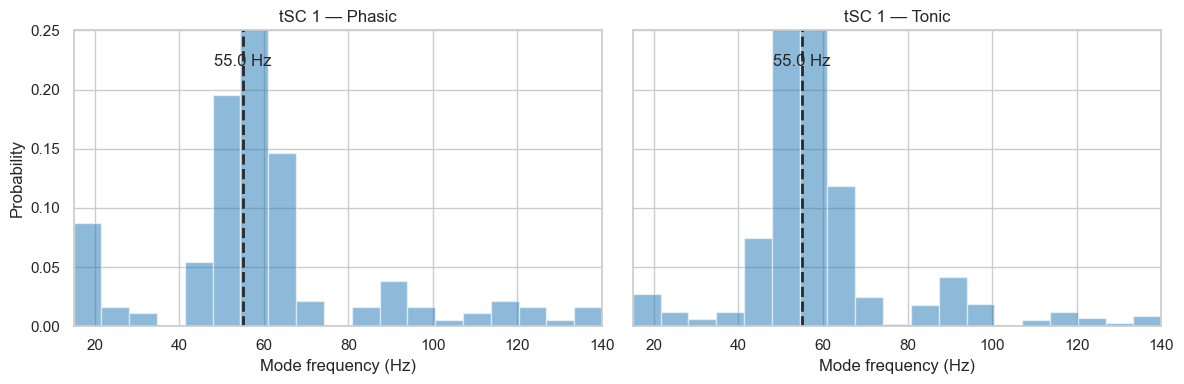

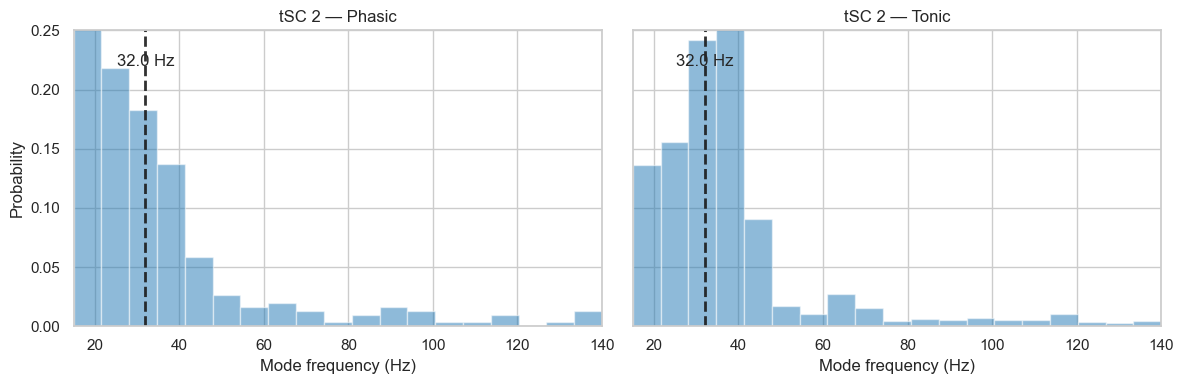

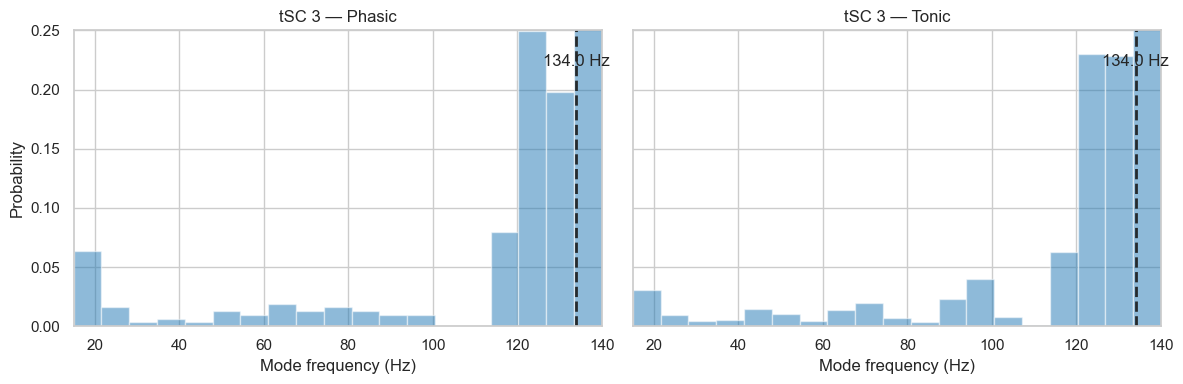

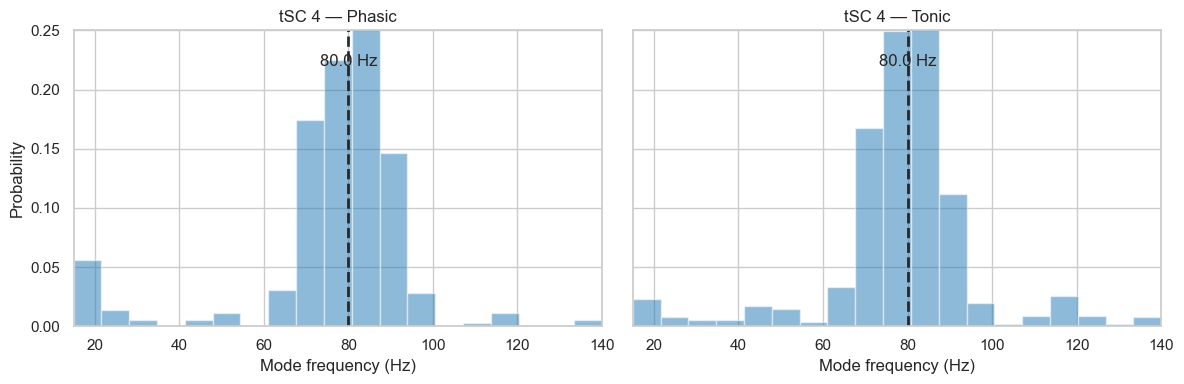

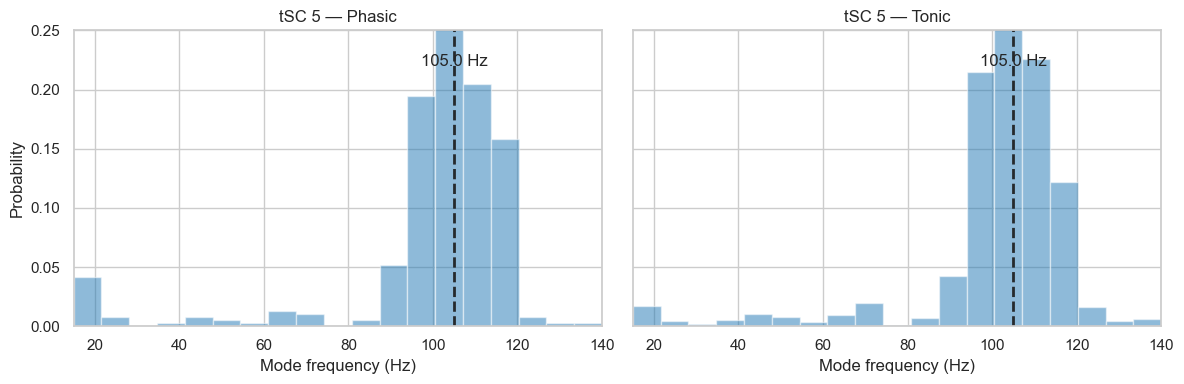

In [115]:
plot_mode_freq_histograms_per_component(
    cycles_df,
    col=["mode_freq_hz_featZ_smooth_strong"],
    freq_bins=np.linspace(15, 140, 20),
    ymax=0.25,
    weights=tSC_results["weights_freq"],
    freq_vec=tSC_results["freq_vec"]
)

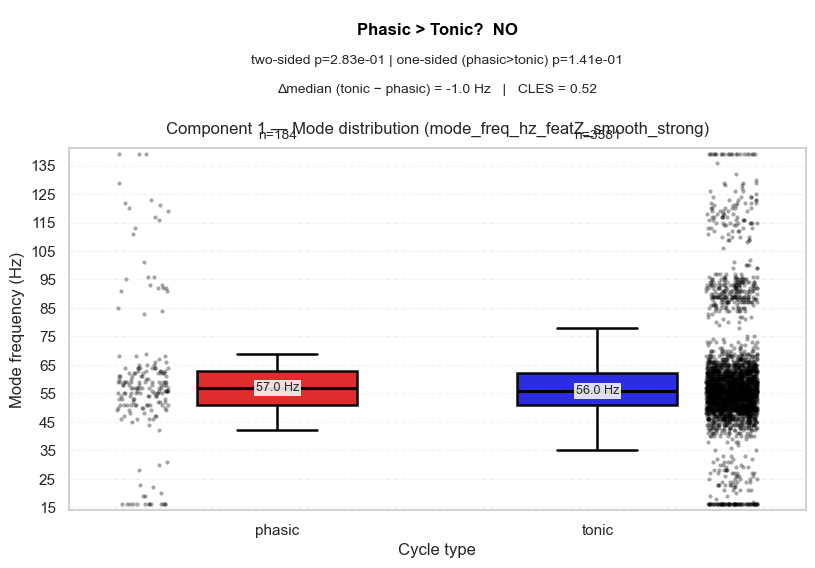

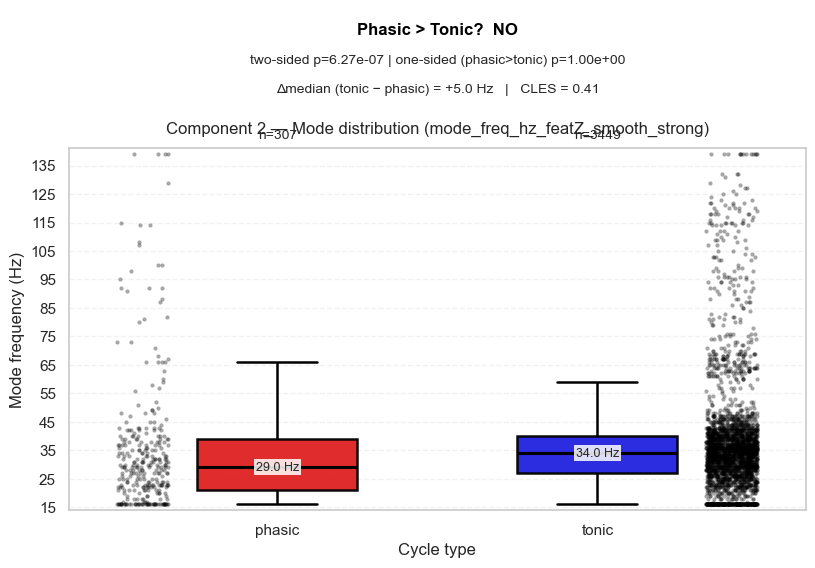

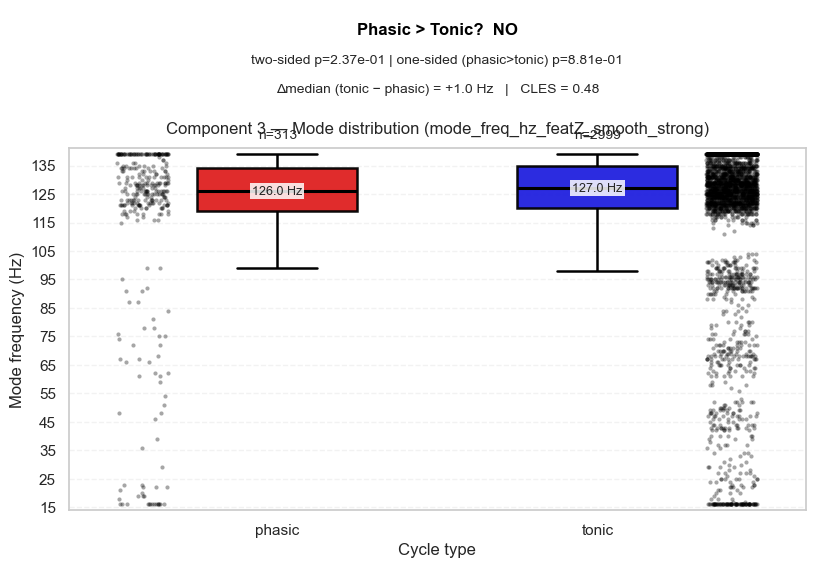

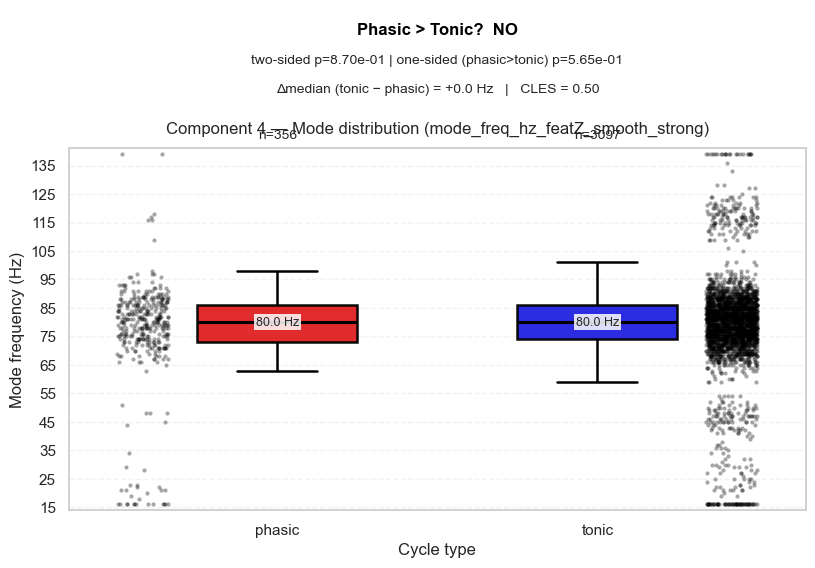

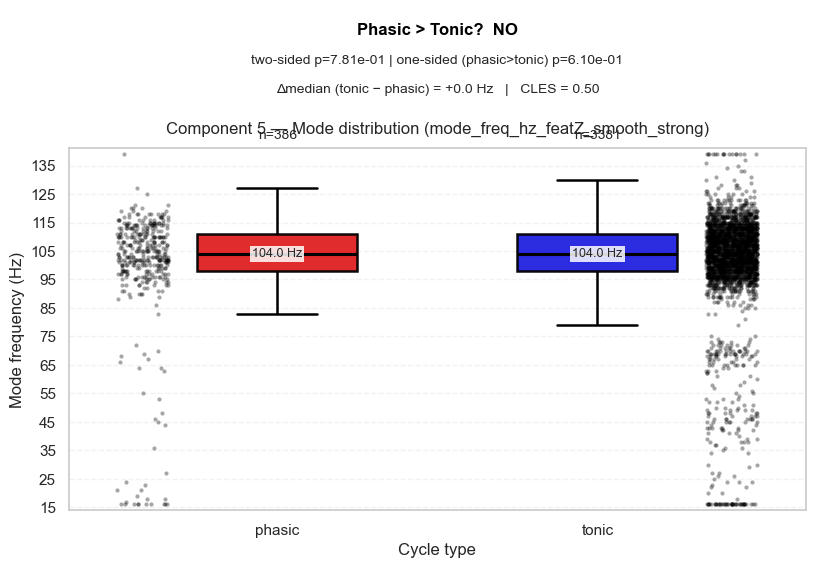

In [116]:
plot_all_components_box_swarm_pro(
    cycles_df,
    col="mode_freq_hz_featZ_smooth_strong"
)

In [106]:
def count_strong_and_total_cycles(cycles_df, n_pca):
    """
    Count strong cycles AND total cycles per component, split by cycle type.
    Returns a DataFrame with columns:
      component, phasic_strong, tonic_strong, total_strong,
      phasic_total, tonic_total, total_cycles
    """
    results = []
    for k in range(1, n_pca+1):
        strong_col = f"tSC{k}_strong"
        if strong_col not in cycles_df.columns:
            continue

        # total cycles assigned to this component
        sub = cycles_df[cycles_df["tSC_label"] == k]
        totals = sub["cycle_type"].value_counts()

        # strong cycles
        strong_counts = sub.groupby("cycle_type")[strong_col].sum()

        results.append({
            "component": k,
            "phasic_strong": int(strong_counts.get("phasic", 0)),
            "tonic_strong": int(strong_counts.get("tonic", 0)),
            "total_strong": int(strong_counts.sum()),
            "phasic_total": int(totals.get("phasic", 0)),
            "tonic_total": int(totals.get("tonic", 0)),
            "total_cycles": int(totals.sum())
        })

    return pd.DataFrame(results)

# Example usage
summary_df = count_strong_and_total_cycles(cycles_df, n_pca=5)
print(summary_df)

   component  phasic_strong  tonic_strong  total_strong  phasic_total  \
0          1            184          3581          3765           504   
1          2            307          3449          3756           702   
2          3            313          2999          3312           471   
3          4            356          3097          3453           579   
4          5            386          3381          3767           643   

   tonic_total  total_cycles  
0        12598         13102  
1        16184         16886  
2         7762          8233  
3         9937         10516  
4        11791         12434  


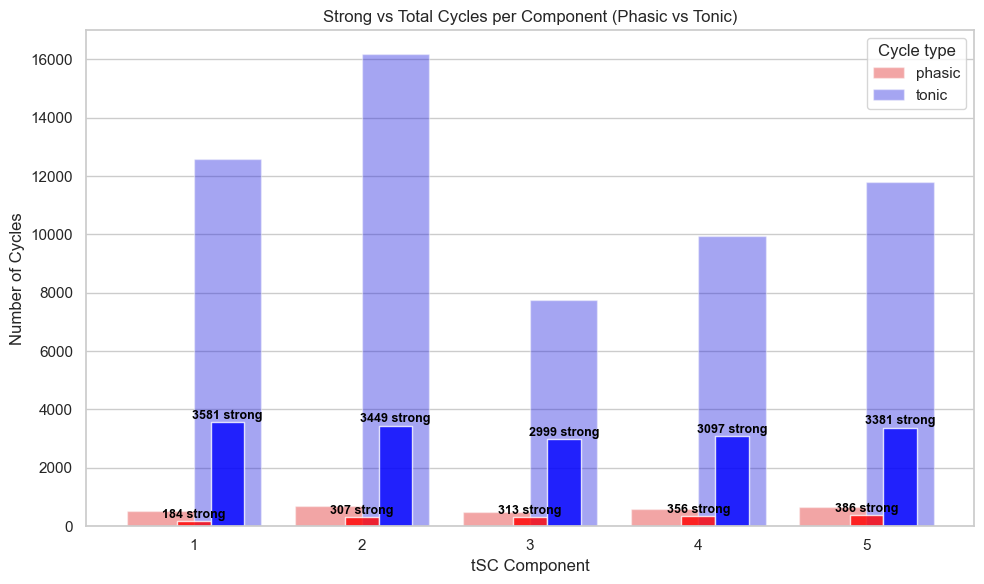

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_strong_vs_total(summary_df):
    """
    Visualize strong vs total cycles per component and cycle type.
    Input = output of count_strong_and_total_cycles().
    """
    # --- reshape data for easier plotting ---
    df_long = []
    for _, row in summary_df.iterrows():
        for ctype in ["phasic", "tonic"]:
            df_long.append({
                "component": row["component"],
                "cycle_type": ctype,
                "total": row[f"{ctype}_total"],
                "strong": row[f"{ctype}_strong"]
            })
    df_long = pd.DataFrame(df_long)

    # --- barplot: total cycles with strong overlay ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,6))

    # plot total cycles (bars)
    sns.barplot(
        data=df_long, x="component", y="total", hue="cycle_type",
        palette={"phasic": "red", "tonic": "blue"}, alpha=0.4,
        ax=ax
    )

    # overlay strong counts (hollow markers)
    for i, row in df_long.iterrows():
        ax.text(
            x=row["component"]-1 + (0 if row["cycle_type"]=="phasic" else 0.2),
            y=row["strong"] + 5, 
            s=f"{row['strong']} strong",
            ha="center", va="bottom", fontsize=9, color="black", fontweight="bold"
        )
        ax.bar(
            row["component"]-1 + (0 if row["cycle_type"]=="phasic" else 0.2),
            row["strong"], width=0.2, 
            color=("red" if row["cycle_type"]=="phasic" else "blue"),
            alpha=0.8
        )

    ax.set_xlabel("tSC Component")
    ax.set_ylabel("Number of Cycles")
    ax.set_title("Strong vs Total Cycles per Component (Phasic vs Tonic)")
    ax.legend(title="Cycle type", loc="upper right")
    plt.tight_layout()
    plt.show()

# Example usage
plot_strong_vs_total(summary_df)

Total cycles to be analyzed: 61171
Running PCA (5 components) followed by ICA...
=== Pipeline Complete ===
Explained variance by PCs: [0.635 0.208 0.091 0.033 0.015]


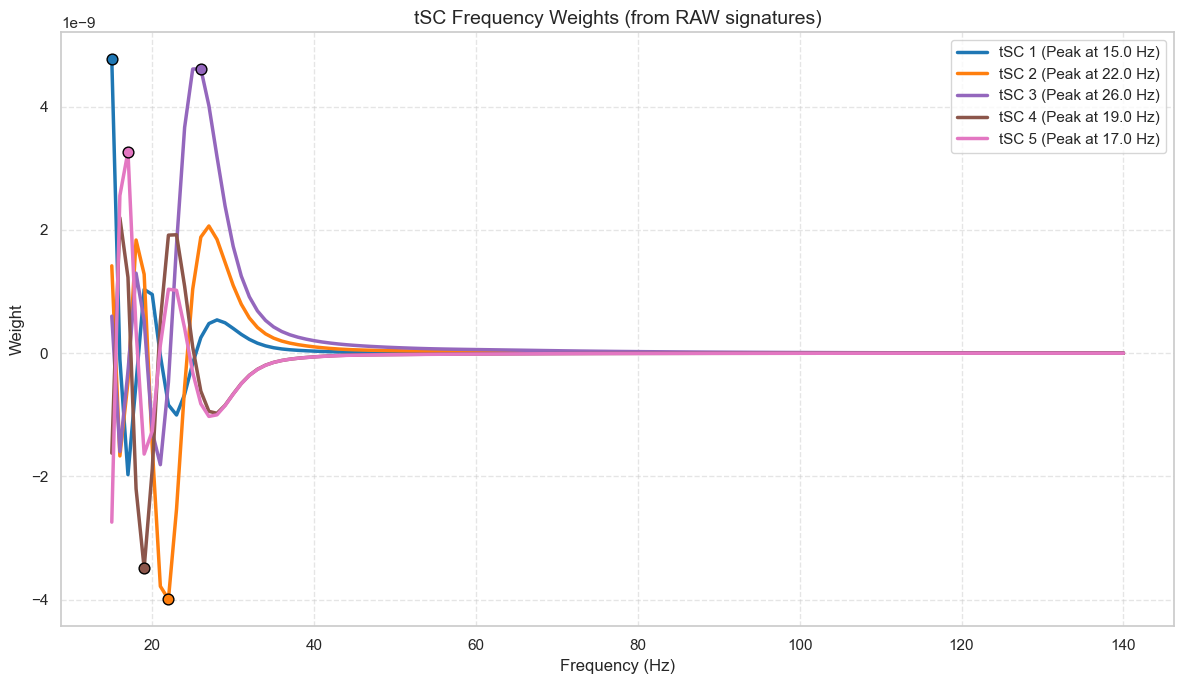


First 5 rows of the resulting cycle dataframe:
   interval_idx  cycle_idx_in_interval cycle_type  tSC_label  tSC1_strength  \
0             0                      0     phasic          3      -1.126603   
1             0                      1     phasic          4      -0.506878   
2             0                      2     phasic          3      -0.360381   
3             0                      3     phasic          3      -0.229557   
4             0                      4     phasic          3       0.555924   

   tSC2_strength  tSC3_strength  tSC4_strength  tSC5_strength  
0      -0.714109       1.190036      -0.908561       0.286224  
1       0.161726       1.976589      -2.016729      -1.080713  
2      -0.086447       2.507602      -2.293159      -1.147356  
3      -0.223406       1.545289      -0.603887      -0.099651  
4      -0.125177      -0.658583       0.157505      -0.341173  


In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

def run_tSC_pipeline_on_raw_signatures(
    phasic_time_signatures,
    tonic_time_signatures,
    n_pca=5,
    freq_vec=np.arange(15, 141, 1)
):
    """
    Performs PCA-ICA analysis directly on raw (non-z-scored) spectral signatures
    to find theta spectral components (tSCs).

    Args:
        phasic_time_signatures (list): List of numpy arrays, where each array is
                                       (n_cycles x n_freqs) for a phasic interval.
        tonic_time_signatures (list): List of numpy arrays for tonic intervals.
        n_pca (int): Number of principal/independent components to extract.
        freq_vec (np.array): Array of frequencies corresponding to the signatures.

    Returns:
        cycles_df (pd.DataFrame): A dataframe with information for each cycle,
                                  including its assigned tSC label and strength.
        tSC_results (dict): A dictionary containing the trained models (PCA, ICA),
                            tSC frequency weights, and cycle strengths.
    """
    # 1. Flatten signature lists from all intervals into a single data matrix (X)
    def _flatten_sig_list(sig_list, label):
        rows, meta = [], []
        for i, arr in enumerate(sig_list):
            if not isinstance(arr, np.ndarray) or arr.size == 0:
                continue
            # Ensure there are no NaN/inf values
            mask = np.isfinite(arr).all(axis=1)
            Xi = arr[mask]
            if Xi.size == 0:
                continue
            rows.append(Xi)
            for j in range(Xi.shape[0]):
                meta.append({
                    "interval_idx": i,
                    "cycle_idx_in_interval": j,
                    "cycle_type": label
                })
        if not rows:
            return np.zeros((0, len(freq_vec))), []
        return np.vstack(rows), meta

    X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
    X_tonic, meta_tonic = _flatten_sig_list(tonic_time_signatures, "tonic")
    X = np.vstack([X_phasic, X_tonic])
    meta = meta_phasic + meta_tonic

    if X.shape[0] == 0:
        raise RuntimeError("No valid cycles found in the input signatures.")

    print(f"Total cycles to be analyzed: {X.shape[0]}")

    # 2. Run PCA -> ICA directly on the raw data matrix X
    print(f"Running PCA ({n_pca} components) followed by ICA...")
    pca = PCA(n_components=n_pca, random_state=42)
    Z = pca.fit_transform(X)

    ica = FastICA(n_components=n_pca, random_state=42, max_iter=2000, tol=1e-4)
    S = ica.fit_transform(Z)

    # 3. Map ICA components back to the original frequency space
    W_freq = ica.components_ @ pca.components_

    # 4. Correct for the arbitrary sign of ICA components
    mean_proj = S.mean(axis=0, keepdims=True)
    signs = np.sign(mean_proj)
    signs[signs == 0] = 1
    S *= signs
    W_freq *= signs.T

    # 5. Assign each cycle to a tSC
    absS = np.abs(S)
    labels_0based = np.argmax(absS, axis=1)

    # 6. Package results
    cycles_df = pd.DataFrame(meta)
    cycles_df["tSC_label"] = labels_0based + 1
    for k in range(n_pca):
        cycles_df[f"tSC{k+1}_strength"] = S[:, k]

    tSC_results = {
        "freq_vec": freq_vec,
        "pca_model": pca,
        "ica_model": ica,
        "weights_freq": W_freq,
        "strengths": S,
        "X_cycles_raw": X,
        "meta": meta
    }

    print("=== Pipeline Complete ===")
    print(f"Explained variance by PCs: {np.round(pca.explained_variance_ratio_, 3)}")
    
    return cycles_df, tSC_results


def plot_tSC_weights(weights, freqs, title="tSC Frequency Weights (from RAW signatures)"):
    """Visualizes the tSC weight vectors over the frequency domain using a custom color palette."""
    plt.figure(figsize=(12, 7))
    n_components = weights.shape[0]
    
    # Use the user-provided color palette
    color_palette = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange  
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # olive (not green)
        '#17becf',  # cyan
        '#d62728',  # red
        '#ff9896'   # light red
    ]
    
    # Extend palette if there are more components than colors
    while len(color_palette) < n_components:
        color_palette.extend(color_palette)

    for k in range(n_components):
        w = weights[k]
        peak_freq = freqs[np.argmax(np.abs(w))]
        color = color_palette[k]
        
        plt.plot(freqs, w, label=f"tSC {k+1} (Peak at {peak_freq:.1f} Hz)", color=color, lw=2.5)
        plt.scatter([peak_freq], [w[np.argmax(np.abs(w))]], s=60, color=color, edgecolor='black', zorder=5)

    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Weight", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
#                      --- EXECUTION ---
# ============================================================
# Run the pipeline on the raw, non-z-scored signatures
cycles_df_raw, tSC_results_raw = run_tSC_pipeline_on_raw_signatures(
    phasic_time_signatures,
    tonic_time_signatures
)

# Plot the resulting tSC weights with the new color palette
plot_tSC_weights(
    tSC_results_raw["weights_freq"],
    tSC_results_raw["freq_vec"]
)

# Display the head of the resulting dataframe
print("\nFirst 5 rows of the resulting cycle dataframe:")
print(cycles_df_raw.head())

In [22]:
# Build cycle packages and labeled waveforms/trials for rat 11
import numpy as np
import pandas as pd

# Ensure expected objects exist
req_objs = ['cycles_df', 'waveforms_df', 'trials_df']
missing_objs = [n for n in req_objs if n not in globals()]
if missing_objs:
    print(f"Missing objects: {missing_objs}. Run earlier cells that create them.")
else:
    # Required columns in cycles_df
    required_cols = ['cycle_type','interval_idx','cycle_idx_in_interval','tSC_label','mode_freq_hz_featZ_smooth']
    miss_cols = [c for c in required_cols if c not in cycles_df.columns]
    if miss_cols:
        print(f"Missing required columns in cycles_df: {miss_cols}")
    else:
        meta = cycles_df[required_cols].copy()

        # Compute packages: consecutive runs within same (cycle_type, interval_idx) having same tSC_label
        sort_cols = ['cycle_type','interval_idx','cycle_idx_in_interval']
        df_sorted = meta.sort_values(sort_cols).copy()
        new_run = (
            (df_sorted['tSC_label'] != df_sorted['tSC_label'].shift(1)) |
            (df_sorted['cycle_type'] != df_sorted['cycle_type'].shift(1)) |
            (df_sorted['interval_idx'] != df_sorted['interval_idx'].shift(1))
        )
        df_sorted['package_id'] = new_run.cumsum() - 1
        sizes = df_sorted['package_id'].value_counts().to_dict()
        df_sorted['package_len'] = df_sorted['package_id'].map(sizes).astype(int)

        # Restore original row order and add sequence index per cycle_type for linkage
        cycles_meta = df_sorted.sort_index().copy()
        cycles_meta['seq_in_type'] = cycles_meta.groupby('cycle_type').cumcount()

        # Prepare waveforms and trials with matching sequence indices
        wf = waveforms_df.copy()
        wf['seq_in_type'] = wf.groupby('cycle_type').cumcount()
        tr = trials_df.copy()
        tr['seq_in_type'] = tr.groupby('cycle_type').cumcount()

        # Sanity check: counts per type
        for ct in ['phasic','tonic']:
            n_wf = int((wf['cycle_type']==ct).sum())
            n_cy = int((cycles_meta['cycle_type']==ct).sum())
            print(f"{ct}: waveforms={n_wf}, cycles={n_cy}")
            if n_wf != n_cy:
                print(f"WARNING: count mismatch for {ct}: waveforms={n_wf} vs cycles={n_cy}")

        # Merge cycles metadata (component, mode freq, package) onto waveforms and trials
        attach_cols = ['cycle_type','seq_in_type','tSC_label','mode_freq_hz_featZ_smooth','package_id','package_len']
        waveforms_labeled_df = wf.merge(cycles_meta[attach_cols], on=['cycle_type','seq_in_type'], how='inner')
        trials_labeled_df    = tr.merge(cycles_meta[attach_cols], on=['cycle_type','seq_in_type'], how='inner')

        # Results summary
        print('waveforms_labeled_df shape:', waveforms_labeled_df.shape)
        print('trials_labeled_df shape:', trials_labeled_df.shape)

        # Keep only packages with length >= 2
        wf_pkgs = waveforms_labeled_df[waveforms_labeled_df['package_len'] >= 2].copy()
        if wf_pkgs.empty:
            print('No packages with length >= 2 found.')
        else:
            # Identify waveform columns (prefer integer or digit-like names) and sort them numerically
            wf_cols_int = [c for c in wf_pkgs.columns if isinstance(c, int)]
            wf_cols_digit = [c for c in wf_pkgs.columns if isinstance(c, str) and c.isdigit()]
            wave_cols = sorted(set(wf_cols_int) | set(int(c) for c in wf_cols_digit))
            # Ensure column names are in the correct type for selection
            # If waveform columns are strings in the DF, convert using their string form
            sel_cols = [c if c in wf_pkgs.columns else str(c) for c in wave_cols]

            packages_list = []
            packages_by_key = {}
            for (ctype, pkg_id), grp in wf_pkgs.groupby(['cycle_type','package_id'], sort=True):
                pkg_len = int(grp['package_len'].iloc[0])
                tsc_label = int(grp['tSC_label'].iloc[0])
                mode_freqs = grp['mode_freq_hz_featZ_smooth'].to_numpy(dtype=float)
                waves = grp[sel_cols].to_numpy(dtype=float)
                rec = {
                    'package': waves,
                    'cycle_type': ctype,
                    'package_id': int(pkg_id),
                    'package_len': pkg_len,
                    'tSC_label': tsc_label,
                    'mode_freq_hz_featZ_smooth': mode_freqs,
                }
                packages_list.append(rec)
                packages_by_key[(ctype, int(pkg_id))] = rec

            print('num_packages_len>=2:', len(packages_list))
            # Quick peek at the first package entry
            if packages_list:
                first = packages_list[0]
                print('first package:', {k: (v.shape if hasattr(v, 'shape') else (len(v) if hasattr(v, '__len__') and not isinstance(v, (str, bytes)) else v)) for k,v in first.items() if k != 'package'})

        # Package length distribution per type (quick view)
        pkg_summary = cycles_meta.groupby(['cycle_type','package_id']).size().reset_index(name='package_len')
        print(pkg_summary.groupby('cycle_type')['package_len'].describe())

        # Preview labeled waveforms with metadata
        display(waveforms_labeled_df.head())


phasic: waveforms=2899, cycles=2899
tonic: waveforms=58272, cycles=58272
waveforms_labeled_df shape: (61171, 111)
trials_labeled_df shape: (61171, 27)
num_packages_len>=2: 11090
first package: {'cycle_type': 'phasic', 'package_id': 2, 'package_len': 2, 'tSC_label': 2, 'mode_freq_hz_featZ_smooth': (2,)}
              count     mean       std  min  25%  50%  75%   max
cycle_type                                                      
phasic       2141.0  1.35404  0.693642  1.0  1.0  1.0  2.0   7.0
tonic       43495.0  1.33974  0.714669  1.0  1.0  1.0  1.0  11.0


0          1          2           3           4           5  \
0  11.696114  35.076560  58.360803   81.414272  104.158310  126.487327   
1  12.219239  36.670456  61.069315   85.324759  109.345319  133.033321   
2  14.757603  44.265278  73.675206  102.900435  131.843811  160.393249   
3  16.331579  48.936299  81.356404  113.450550  145.101046  176.172768   
4  16.355357  49.024108  81.518854  113.711557  145.471115  176.639058   

            6           7           8           9  ...  condition  trial  \
0  148.298889  169.533342  190.027037  209.774806  ...        CON      2   
1  156.258787  178.935508  200.970567  222.297952  ...        CON      2   
2  188.473206  215.971863  242.794195  268.853471  ...        CON      2   
3  206.534283  236.063042  264.665764  292.326650  ...        CON      2   
4  207.114123  236.745623  265.473871  293.167148  ...        CON      2   

   cycle_type  SD        date  seq_in_type  tSC_label  \
0      phasic   1  29-10-2018            0          2   
1      phasic   1  29-10-2018            1          5   
2      phasic   1  29-10-2018            2          2   
3      phasic   1  29-10-2018            3          2   
4      phasic   1  29-10-2018            4          1   

   mode_freq_hz_featZ_smooth  package_id  package_len  
0                         31           0            1  
1                        115           1            1  
2                        114           2            2  
3                         98           2            2  
4                         93           3            1  

[5 rows x 111 columns]

In [36]:
np.save('temp_omid/rat11_cycle_info.npy', packages_list, allow_pickle=True)

In [48]:
packages_list[0]['package'].shape if packages_list else None

(2, 100)

In [43]:
total_packages_ge2 = len(packages_list)
cycles_in_pkgs_ge2 = int(sum(rec['package'].shape[0] for rec in packages_list))

print(f"packages (len>=2): {total_packages_ge2}")
print(f"cycles within those packages: {cycles_in_pkgs_ge2}")

# Optional: per cycle_type breakdown

from collections import Counter
import pandas as pd

pkgs_per_type = Counter(rec['cycle_type'] for rec in packages_list)
cycles_per_type = Counter()
for rec in packages_list:
    cycles_per_type[rec['cycle_type']] += rec['package'].shape[0]

summary = pd.DataFrame({'packages_len>=2': pkgs_per_type, 'cycles_in_packages': cycles_per_type}).fillna(0).astype(int)
print(summary)

packages (len>=2): 11090
cycles within those packages: 26625
        packages_len>=2  cycles_in_packages
phasic              553                1311
tonic             10537               25314


Total packages: 45636
Packages (len>=2): 11090
Cycles within packages (len>=2): 26625


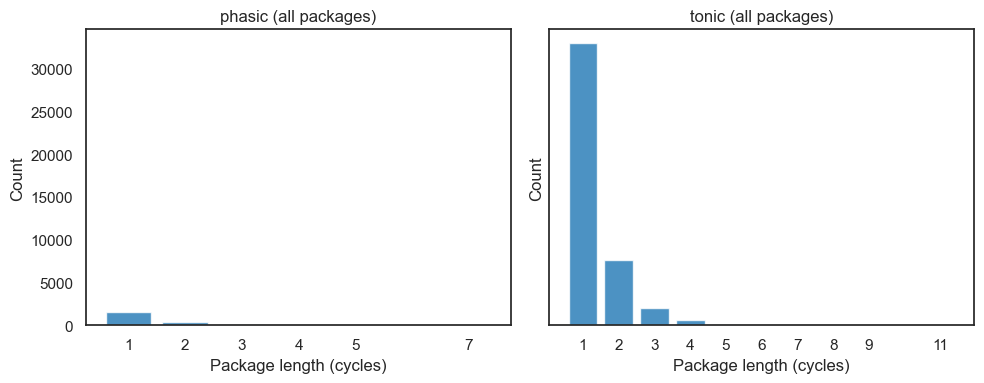

In [44]:
# Plot distribution of package lengths (with adjacency + same tSC within interval)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'cycles_df' not in globals():
    print('cycles_df not found. Run the tSC pipeline cell first.')
else:
    cols = ['cycle_type','interval_idx','cycle_idx_in_interval','tSC_label']
    missing = [c for c in cols if c not in cycles_df.columns]
    if missing:
        print(f'Missing columns in cycles_df: {missing}')
    else:
        df = cycles_df[cols].copy()
        df = df.sort_values(['cycle_type','interval_idx','cycle_idx_in_interval']).copy()
        # previous row metadata for run detection
        df['prev_cycle_type'] = df['cycle_type'].shift(1)
        df['prev_interval_idx'] = df['interval_idx'].shift(1)
        df['prev_tSC_label'] = df['tSC_label'].shift(1)
        df['prev_cycle_idx'] = df['cycle_idx_in_interval'].shift(1)
        group_change = (df['cycle_type'] != df['prev_cycle_type']) | (df['interval_idx'] != df['prev_interval_idx'])
        adjacent = (~group_change) & (df['cycle_idx_in_interval'] == df['prev_cycle_idx'] + 1)
        same_label = (df['tSC_label'] == df['prev_tSC_label'])
        continue_run = adjacent & same_label
        df['package_id'] = (~continue_run).cumsum() - 1
        pkg_sizes = df.groupby(['cycle_type','package_id']).size().reset_index(name='package_len')
        pkg_sizes_ge2 = pkg_sizes[pkg_sizes['package_len'] >= 2]

        # Print counts
        total_packages = int(pkg_sizes.shape[0])
        total_packages_ge2 = int(pkg_sizes_ge2.shape[0])
        cycles_in_pkgs_ge2 = int(pkg_sizes_ge2['package_len'].sum())
        print(f'Total packages: {total_packages}')
        print(f'Packages (len>=2): {total_packages_ge2}')
        print(f'Cycles within packages (len>=2): {cycles_in_pkgs_ge2}')

        # Plot per cycle_type
        types = sorted(pkg_sizes['cycle_type'].unique())
        n = max(1, len(types))
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=True)
        if n == 1:
            axes = [axes]
        for ax, ct in zip(axes, types):
            sub = pkg_sizes[pkg_sizes['cycle_type'] == ct]
            counts = sub['package_len'].value_counts().sort_index()
            ax.bar(counts.index.astype(int), counts.values, color='tab:blue', alpha=0.8)
            ax.set_title(f'{ct} (all packages)')
            ax.set_xlabel('Package length (cycles)')
            ax.set_ylabel('Count')
            ax.set_xticks(counts.index.astype(int))
        plt.tight_layout()
        plt.show()
